In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195594, 2) (49698, 2)
train/valid # (195594, 2) (49698, 2)


rand split across time
train has 195594 records out of 372221 records
valid has 49698 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1528
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1528 [..............................] - ETA: 40:39 - loss: 5.2428 - total_loss: 5.2428 - reg_loss: 5.2428

   6/1528 [..............................] - ETA: 6:59 - loss: 1.9975 - total_loss: 1.9975 - reg_loss: 1.9975 

  11/1528 [..............................] - ETA: 3:55 - loss: 1.4983 - total_loss: 1.4983 - reg_loss: 1.4983

  16/1528 [..............................] - ETA: 2:46 - loss: 1.2265 - total_loss: 1.2265 - reg_loss: 1.2265

  22/1528 [..............................] - ETA: 2:04 - loss: 1.0560 - total_loss: 1.0560 - reg_loss: 1.0560

  28/1528 [..............................] - ETA: 1:40 - loss: 0.9313 - total_loss: 0.9313 - reg_loss: 0.9313

  33/1528 [..............................] - ETA: 1:27 - loss: 0.8604 - total_loss: 0.8604 - reg_loss: 0.8604

  39/1528 [..............................] - ETA: 1:15 - loss: 0.7951 - total_loss: 0.7951 - reg_loss: 0.7951

  44/1528 [..............................] - ETA: 1:08 - loss: 0.7534 - total_loss: 0.7534 - reg_loss: 0.7534

  49/1528 [..............................] - ETA: 1:03 - loss: 0.7158 - total_loss: 0.7158 - reg_loss: 0.7158

  54/1528 [>.............................] - ETA: 58s - loss: 0.6825 - total_loss: 0.6825 - reg_loss: 0.6825 

  59/1528 [>.............................] - ETA: 54s - loss: 0.6554 - total_loss: 0.6554 - reg_loss: 0.6554

  64/1528 [>.............................] - ETA: 51s - loss: 0.6347 - total_loss: 0.6347 - reg_loss: 0.6347

  69/1528 [>.............................] - ETA: 48s - loss: 0.6137 - total_loss: 0.6137 - reg_loss: 0.6137

  74/1528 [>.............................] - ETA: 46s - loss: 0.5975 - total_loss: 0.5975 - reg_loss: 0.5975

  79/1528 [>.............................] - ETA: 44s - loss: 0.5821 - total_loss: 0.5821 - reg_loss: 0.5821

  85/1528 [>.............................] - ETA: 41s - loss: 0.5653 - total_loss: 0.5653 - reg_loss: 0.5653

  90/1528 [>.............................] - ETA: 40s - loss: 0.5549 - total_loss: 0.5549 - reg_loss: 0.5549

  96/1528 [>.............................] - ETA: 38s - loss: 0.5402 - total_loss: 0.5402 - reg_loss: 0.5402

 101/1528 [>.............................] - ETA: 37s - loss: 0.5303 - total_loss: 0.5303 - reg_loss: 0.5303

 106/1528 [=>............................] - ETA: 35s - loss: 0.5199 - total_loss: 0.5199 - reg_loss: 0.5199

 112/1528 [=>............................] - ETA: 34s - loss: 0.5086 - total_loss: 0.5086 - reg_loss: 0.5086

 118/1528 [=>............................] - ETA: 33s - loss: 0.5003 - total_loss: 0.5003 - reg_loss: 0.5003

 124/1528 [=>............................] - ETA: 32s - loss: 0.4924 - total_loss: 0.4924 - reg_loss: 0.4924

 129/1528 [=>............................] - ETA: 31s - loss: 0.4866 - total_loss: 0.4866 - reg_loss: 0.4866

 134/1528 [=>............................] - ETA: 30s - loss: 0.4808 - total_loss: 0.4808 - reg_loss: 0.4808

 139/1528 [=>............................] - ETA: 30s - loss: 0.4768 - total_loss: 0.4768 - reg_loss: 0.4768

 144/1528 [=>............................] - ETA: 29s - loss: 0.4716 - total_loss: 0.4716 - reg_loss: 0.4716

 150/1528 [=>............................] - ETA: 28s - loss: 0.4651 - total_loss: 0.4651 - reg_loss: 0.4651

 155/1528 [==>...........................] - ETA: 28s - loss: 0.4598 - total_loss: 0.4598 - reg_loss: 0.4598

 160/1528 [==>...........................] - ETA: 27s - loss: 0.4549 - total_loss: 0.4549 - reg_loss: 0.4549

 165/1528 [==>...........................] - ETA: 27s - loss: 0.4497 - total_loss: 0.4497 - reg_loss: 0.4497

 170/1528 [==>...........................] - ETA: 26s - loss: 0.4460 - total_loss: 0.4460 - reg_loss: 0.4460

 175/1528 [==>...........................] - ETA: 26s - loss: 0.4417 - total_loss: 0.4417 - reg_loss: 0.4417

 181/1528 [==>...........................] - ETA: 25s - loss: 0.4368 - total_loss: 0.4368 - reg_loss: 0.4368

 186/1528 [==>...........................] - ETA: 25s - loss: 0.4334 - total_loss: 0.4334 - reg_loss: 0.4334

 191/1528 [==>...........................] - ETA: 24s - loss: 0.4297 - total_loss: 0.4297 - reg_loss: 0.4297

 196/1528 [==>...........................] - ETA: 24s - loss: 0.4262 - total_loss: 0.4262 - reg_loss: 0.4262

 201/1528 [==>...........................] - ETA: 24s - loss: 0.4227 - total_loss: 0.4227 - reg_loss: 0.4227

 206/1528 [===>..........................] - ETA: 23s - loss: 0.4199 - total_loss: 0.4199 - reg_loss: 0.4199

 211/1528 [===>..........................] - ETA: 23s - loss: 0.4184 - total_loss: 0.4184 - reg_loss: 0.4184

 216/1528 [===>..........................] - ETA: 23s - loss: 0.4170 - total_loss: 0.4170 - reg_loss: 0.4170

 221/1528 [===>..........................] - ETA: 22s - loss: 0.4147 - total_loss: 0.4147 - reg_loss: 0.4147

 226/1528 [===>..........................] - ETA: 22s - loss: 0.4122 - total_loss: 0.4122 - reg_loss: 0.4122

 231/1528 [===>..........................] - ETA: 22s - loss: 0.4099 - total_loss: 0.4099 - reg_loss: 0.4099

 237/1528 [===>..........................] - ETA: 21s - loss: 0.4075 - total_loss: 0.4075 - reg_loss: 0.4075

 242/1528 [===>..........................] - ETA: 21s - loss: 0.4060 - total_loss: 0.4060 - reg_loss: 0.4060

 247/1528 [===>..........................] - ETA: 21s - loss: 0.4044 - total_loss: 0.4044 - reg_loss: 0.4044

 253/1528 [===>..........................] - ETA: 21s - loss: 0.4014 - total_loss: 0.4014 - reg_loss: 0.4014

 258/1528 [====>.........................] - ETA: 20s - loss: 0.3999 - total_loss: 0.3999 - reg_loss: 0.3999

 263/1528 [====>.........................] - ETA: 20s - loss: 0.3978 - total_loss: 0.3978 - reg_loss: 0.3978

 268/1528 [====>.........................] - ETA: 20s - loss: 0.3962 - total_loss: 0.3962 - reg_loss: 0.3962

 273/1528 [====>.........................] - ETA: 20s - loss: 0.3952 - total_loss: 0.3952 - reg_loss: 0.3952

 278/1528 [====>.........................] - ETA: 19s - loss: 0.3942 - total_loss: 0.3942 - reg_loss: 0.3942

 283/1528 [====>.........................] - ETA: 19s - loss: 0.3922 - total_loss: 0.3922 - reg_loss: 0.3922

 289/1528 [====>.........................] - ETA: 19s - loss: 0.3916 - total_loss: 0.3916 - reg_loss: 0.3916

 294/1528 [====>.........................] - ETA: 19s - loss: 0.3906 - total_loss: 0.3906 - reg_loss: 0.3906

 300/1528 [====>.........................] - ETA: 19s - loss: 0.3889 - total_loss: 0.3889 - reg_loss: 0.3889

 305/1528 [====>.........................] - ETA: 18s - loss: 0.3878 - total_loss: 0.3878 - reg_loss: 0.3878

 310/1528 [=====>........................] - ETA: 18s - loss: 0.3866 - total_loss: 0.3866 - reg_loss: 0.3866

 316/1528 [=====>........................] - ETA: 18s - loss: 0.3860 - total_loss: 0.3860 - reg_loss: 0.3860

 322/1528 [=====>........................] - ETA: 18s - loss: 0.3861 - total_loss: 0.3861 - reg_loss: 0.3861

 327/1528 [=====>........................] - ETA: 18s - loss: 0.3853 - total_loss: 0.3853 - reg_loss: 0.3853

 332/1528 [=====>........................] - ETA: 17s - loss: 0.3843 - total_loss: 0.3843 - reg_loss: 0.3843

 337/1528 [=====>........................] - ETA: 17s - loss: 0.3837 - total_loss: 0.3837 - reg_loss: 0.3837

 342/1528 [=====>........................] - ETA: 17s - loss: 0.3827 - total_loss: 0.3827 - reg_loss: 0.3827

 347/1528 [=====>........................] - ETA: 17s - loss: 0.3814 - total_loss: 0.3814 - reg_loss: 0.3814

 352/1528 [=====>........................] - ETA: 17s - loss: 0.3799 - total_loss: 0.3799 - reg_loss: 0.3799

 357/1528 [======>.......................] - ETA: 17s - loss: 0.3786 - total_loss: 0.3786 - reg_loss: 0.3786

 363/1528 [======>.......................] - ETA: 16s - loss: 0.3769 - total_loss: 0.3769 - reg_loss: 0.3769

 368/1528 [======>.......................] - ETA: 16s - loss: 0.3756 - total_loss: 0.3756 - reg_loss: 0.3756

 374/1528 [======>.......................] - ETA: 16s - loss: 0.3739 - total_loss: 0.3739 - reg_loss: 0.3739

 379/1528 [======>.......................] - ETA: 16s - loss: 0.3728 - total_loss: 0.3728 - reg_loss: 0.3728

 384/1528 [======>.......................] - ETA: 16s - loss: 0.3717 - total_loss: 0.3717 - reg_loss: 0.3717

 389/1528 [======>.......................] - ETA: 16s - loss: 0.3708 - total_loss: 0.3708 - reg_loss: 0.3708

 394/1528 [======>.......................] - ETA: 16s - loss: 0.3701 - total_loss: 0.3701 - reg_loss: 0.3701

 399/1528 [======>.......................] - ETA: 16s - loss: 0.3689 - total_loss: 0.3689 - reg_loss: 0.3689

 404/1528 [======>.......................] - ETA: 15s - loss: 0.3680 - total_loss: 0.3680 - reg_loss: 0.3680

 409/1528 [=======>......................] - ETA: 15s - loss: 0.3669 - total_loss: 0.3669 - reg_loss: 0.3669

 415/1528 [=======>......................] - ETA: 15s - loss: 0.3657 - total_loss: 0.3657 - reg_loss: 0.3657

 420/1528 [=======>......................] - ETA: 15s - loss: 0.3651 - total_loss: 0.3651 - reg_loss: 0.3651

 425/1528 [=======>......................] - ETA: 15s - loss: 0.3642 - total_loss: 0.3642 - reg_loss: 0.3642

 430/1528 [=======>......................] - ETA: 15s - loss: 0.3633 - total_loss: 0.3633 - reg_loss: 0.3633

 435/1528 [=======>......................] - ETA: 15s - loss: 0.3626 - total_loss: 0.3626 - reg_loss: 0.3626

 441/1528 [=======>......................] - ETA: 15s - loss: 0.3617 - total_loss: 0.3617 - reg_loss: 0.3617

 446/1528 [=======>......................] - ETA: 14s - loss: 0.3606 - total_loss: 0.3606 - reg_loss: 0.3606

 451/1528 [=======>......................] - ETA: 14s - loss: 0.3603 - total_loss: 0.3603 - reg_loss: 0.3603

 456/1528 [=======>......................] - ETA: 14s - loss: 0.3595 - total_loss: 0.3595 - reg_loss: 0.3595

 461/1528 [========>.....................] - ETA: 14s - loss: 0.3588 - total_loss: 0.3588 - reg_loss: 0.3588

 466/1528 [========>.....................] - ETA: 14s - loss: 0.3579 - total_loss: 0.3579 - reg_loss: 0.3579

 471/1528 [========>.....................] - ETA: 14s - loss: 0.3571 - total_loss: 0.3571 - reg_loss: 0.3571

 477/1528 [========>.....................] - ETA: 14s - loss: 0.3568 - total_loss: 0.3568 - reg_loss: 0.3568

 482/1528 [========>.....................] - ETA: 14s - loss: 0.3563 - total_loss: 0.3563 - reg_loss: 0.3563

 488/1528 [========>.....................] - ETA: 13s - loss: 0.3559 - total_loss: 0.3559 - reg_loss: 0.3559

 494/1528 [========>.....................] - ETA: 13s - loss: 0.3556 - total_loss: 0.3556 - reg_loss: 0.3556

 499/1528 [========>.....................] - ETA: 13s - loss: 0.3551 - total_loss: 0.3551 - reg_loss: 0.3551

 504/1528 [========>.....................] - ETA: 13s - loss: 0.3546 - total_loss: 0.3546 - reg_loss: 0.3546

 509/1528 [========>.....................] - ETA: 13s - loss: 0.3543 - total_loss: 0.3543 - reg_loss: 0.3543

 515/1528 [=========>....................] - ETA: 13s - loss: 0.3536 - total_loss: 0.3536 - reg_loss: 0.3536

 520/1528 [=========>....................] - ETA: 13s - loss: 0.3529 - total_loss: 0.3529 - reg_loss: 0.3529

 526/1528 [=========>....................] - ETA: 13s - loss: 0.3521 - total_loss: 0.3521 - reg_loss: 0.3521

 531/1528 [=========>....................] - ETA: 13s - loss: 0.3515 - total_loss: 0.3515 - reg_loss: 0.3515

 536/1528 [=========>....................] - ETA: 13s - loss: 0.3506 - total_loss: 0.3506 - reg_loss: 0.3506

 541/1528 [=========>....................] - ETA: 12s - loss: 0.3498 - total_loss: 0.3498 - reg_loss: 0.3498

 546/1528 [=========>....................] - ETA: 12s - loss: 0.3490 - total_loss: 0.3490 - reg_loss: 0.3490

 551/1528 [=========>....................] - ETA: 12s - loss: 0.3482 - total_loss: 0.3482 - reg_loss: 0.3482

 556/1528 [=========>....................] - ETA: 12s - loss: 0.3477 - total_loss: 0.3477 - reg_loss: 0.3477

 561/1528 [==========>...................] - ETA: 12s - loss: 0.3469 - total_loss: 0.3469 - reg_loss: 0.3469

 566/1528 [==========>...................] - ETA: 12s - loss: 0.3465 - total_loss: 0.3465 - reg_loss: 0.3465

 571/1528 [==========>...................] - ETA: 12s - loss: 0.3459 - total_loss: 0.3459 - reg_loss: 0.3459

 576/1528 [==========>...................] - ETA: 12s - loss: 0.3453 - total_loss: 0.3453 - reg_loss: 0.3453

 581/1528 [==========>...................] - ETA: 12s - loss: 0.3448 - total_loss: 0.3448 - reg_loss: 0.3448

 586/1528 [==========>...................] - ETA: 12s - loss: 0.3443 - total_loss: 0.3443 - reg_loss: 0.3443

 592/1528 [==========>...................] - ETA: 12s - loss: 0.3440 - total_loss: 0.3440 - reg_loss: 0.3440

 597/1528 [==========>...................] - ETA: 11s - loss: 0.3437 - total_loss: 0.3437 - reg_loss: 0.3437

 603/1528 [==========>...................] - ETA: 11s - loss: 0.3432 - total_loss: 0.3432 - reg_loss: 0.3432

 609/1528 [==========>...................] - ETA: 11s - loss: 0.3427 - total_loss: 0.3427 - reg_loss: 0.3427

 614/1528 [===========>..................] - ETA: 11s - loss: 0.3428 - total_loss: 0.3428 - reg_loss: 0.3428

 619/1528 [===========>..................] - ETA: 11s - loss: 0.3429 - total_loss: 0.3429 - reg_loss: 0.3429

 625/1528 [===========>..................] - ETA: 11s - loss: 0.3425 - total_loss: 0.3425 - reg_loss: 0.3425

 630/1528 [===========>..................] - ETA: 11s - loss: 0.3421 - total_loss: 0.3421 - reg_loss: 0.3421

 635/1528 [===========>..................] - ETA: 11s - loss: 0.3418 - total_loss: 0.3418 - reg_loss: 0.3418

 640/1528 [===========>..................] - ETA: 11s - loss: 0.3416 - total_loss: 0.3416 - reg_loss: 0.3416

 645/1528 [===========>..................] - ETA: 11s - loss: 0.3407 - total_loss: 0.3407 - reg_loss: 0.3407

 651/1528 [===========>..................] - ETA: 11s - loss: 0.3402 - total_loss: 0.3402 - reg_loss: 0.3402

 656/1528 [===========>..................] - ETA: 11s - loss: 0.3399 - total_loss: 0.3399 - reg_loss: 0.3399

 661/1528 [===========>..................] - ETA: 10s - loss: 0.3396 - total_loss: 0.3396 - reg_loss: 0.3396

 666/1528 [============>.................] - ETA: 10s - loss: 0.3391 - total_loss: 0.3391 - reg_loss: 0.3391

 671/1528 [============>.................] - ETA: 10s - loss: 0.3387 - total_loss: 0.3387 - reg_loss: 0.3387

 676/1528 [============>.................] - ETA: 10s - loss: 0.3383 - total_loss: 0.3383 - reg_loss: 0.3383

 681/1528 [============>.................] - ETA: 10s - loss: 0.3379 - total_loss: 0.3379 - reg_loss: 0.3379

 686/1528 [============>.................] - ETA: 10s - loss: 0.3375 - total_loss: 0.3375 - reg_loss: 0.3375

 692/1528 [============>.................] - ETA: 10s - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376

 697/1528 [============>.................] - ETA: 10s - loss: 0.3372 - total_loss: 0.3372 - reg_loss: 0.3372

 702/1528 [============>.................] - ETA: 10s - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367

 708/1528 [============>.................] - ETA: 10s - loss: 0.3366 - total_loss: 0.3366 - reg_loss: 0.3366

 714/1528 [=============>................] - ETA: 10s - loss: 0.3362 - total_loss: 0.3362 - reg_loss: 0.3362

 719/1528 [=============>................] - ETA: 10s - loss: 0.3358 - total_loss: 0.3358 - reg_loss: 0.3358

 724/1528 [=============>................] - ETA: 9s - loss: 0.3358 - total_loss: 0.3358 - reg_loss: 0.3358 

 729/1528 [=============>................] - ETA: 9s - loss: 0.3352 - total_loss: 0.3352 - reg_loss: 0.3352

 735/1528 [=============>................] - ETA: 9s - loss: 0.3348 - total_loss: 0.3348 - reg_loss: 0.3348

 740/1528 [=============>................] - ETA: 9s - loss: 0.3345 - total_loss: 0.3345 - reg_loss: 0.3345

 745/1528 [=============>................] - ETA: 9s - loss: 0.3340 - total_loss: 0.3340 - reg_loss: 0.3340

 750/1528 [=============>................] - ETA: 9s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 756/1528 [=============>................] - ETA: 9s - loss: 0.3330 - total_loss: 0.3330 - reg_loss: 0.3330

 762/1528 [=============>................] - ETA: 9s - loss: 0.3329 - total_loss: 0.3329 - reg_loss: 0.3329

 768/1528 [==============>...............] - ETA: 9s - loss: 0.3324 - total_loss: 0.3324 - reg_loss: 0.3324

 773/1528 [==============>...............] - ETA: 9s - loss: 0.3320 - total_loss: 0.3320 - reg_loss: 0.3320

 778/1528 [==============>...............] - ETA: 9s - loss: 0.3317 - total_loss: 0.3317 - reg_loss: 0.3317

 783/1528 [==============>...............] - ETA: 9s - loss: 0.3313 - total_loss: 0.3313 - reg_loss: 0.3313

 789/1528 [==============>...............] - ETA: 9s - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309

 794/1528 [==============>...............] - ETA: 8s - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307

 800/1528 [==============>...............] - ETA: 8s - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306

 805/1528 [==============>...............] - ETA: 8s - loss: 0.3304 - total_loss: 0.3304 - reg_loss: 0.3304

 810/1528 [==============>...............] - ETA: 8s - loss: 0.3299 - total_loss: 0.3299 - reg_loss: 0.3299

 816/1528 [===============>..............] - ETA: 8s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

 821/1528 [===============>..............] - ETA: 8s - loss: 0.3294 - total_loss: 0.3294 - reg_loss: 0.3294

 827/1528 [===============>..............] - ETA: 8s - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290

 832/1528 [===============>..............] - ETA: 8s - loss: 0.3287 - total_loss: 0.3287 - reg_loss: 0.3287

 837/1528 [===============>..............] - ETA: 8s - loss: 0.3282 - total_loss: 0.3282 - reg_loss: 0.3282

 842/1528 [===============>..............] - ETA: 8s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

 847/1528 [===============>..............] - ETA: 8s - loss: 0.3280 - total_loss: 0.3280 - reg_loss: 0.3280

 852/1528 [===============>..............] - ETA: 8s - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277

 857/1528 [===============>..............] - ETA: 8s - loss: 0.3274 - total_loss: 0.3274 - reg_loss: 0.3274

 862/1528 [===============>..............] - ETA: 8s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

 868/1528 [================>.............] - ETA: 7s - loss: 0.3267 - total_loss: 0.3267 - reg_loss: 0.3267

 873/1528 [================>.............] - ETA: 7s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

 878/1528 [================>.............] - ETA: 7s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

 883/1528 [================>.............] - ETA: 7s - loss: 0.3260 - total_loss: 0.3260 - reg_loss: 0.3260

 888/1528 [================>.............] - ETA: 7s - loss: 0.3256 - total_loss: 0.3256 - reg_loss: 0.3256

 893/1528 [================>.............] - ETA: 7s - loss: 0.3254 - total_loss: 0.3254 - reg_loss: 0.3254

 899/1528 [================>.............] - ETA: 7s - loss: 0.3255 - total_loss: 0.3255 - reg_loss: 0.3255

 904/1528 [================>.............] - ETA: 7s - loss: 0.3254 - total_loss: 0.3254 - reg_loss: 0.3254

 909/1528 [================>.............] - ETA: 7s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

 915/1528 [================>.............] - ETA: 7s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

 920/1528 [=================>............] - ETA: 7s - loss: 0.3248 - total_loss: 0.3248 - reg_loss: 0.3248

 925/1528 [=================>............] - ETA: 7s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

 930/1528 [=================>............] - ETA: 7s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

 935/1528 [=================>............] - ETA: 7s - loss: 0.3244 - total_loss: 0.3244 - reg_loss: 0.3244

 940/1528 [=================>............] - ETA: 6s - loss: 0.3242 - total_loss: 0.3242 - reg_loss: 0.3242

 946/1528 [=================>............] - ETA: 6s - loss: 0.3239 - total_loss: 0.3239 - reg_loss: 0.3239

 952/1528 [=================>............] - ETA: 6s - loss: 0.3238 - total_loss: 0.3238 - reg_loss: 0.3238

 958/1528 [=================>............] - ETA: 6s - loss: 0.3237 - total_loss: 0.3237 - reg_loss: 0.3237

 963/1528 [=================>............] - ETA: 6s - loss: 0.3235 - total_loss: 0.3235 - reg_loss: 0.3235

 969/1528 [==================>...........] - ETA: 6s - loss: 0.3232 - total_loss: 0.3232 - reg_loss: 0.3232

 975/1528 [==================>...........] - ETA: 6s - loss: 0.3232 - total_loss: 0.3232 - reg_loss: 0.3232

 980/1528 [==================>...........] - ETA: 6s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

 986/1528 [==================>...........] - ETA: 6s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

 991/1528 [==================>...........] - ETA: 6s - loss: 0.3226 - total_loss: 0.3226 - reg_loss: 0.3226

 996/1528 [==================>...........] - ETA: 6s - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224

1001/1528 [==================>...........] - ETA: 6s - loss: 0.3220 - total_loss: 0.3220 - reg_loss: 0.3220

1007/1528 [==================>...........] - ETA: 6s - loss: 0.3217 - total_loss: 0.3217 - reg_loss: 0.3217

1013/1528 [==================>...........] - ETA: 6s - loss: 0.3214 - total_loss: 0.3214 - reg_loss: 0.3214

1018/1528 [==================>...........] - ETA: 5s - loss: 0.3213 - total_loss: 0.3213 - reg_loss: 0.3213

1023/1528 [===================>..........] - ETA: 5s - loss: 0.3210 - total_loss: 0.3210 - reg_loss: 0.3210

1028/1528 [===================>..........] - ETA: 5s - loss: 0.3209 - total_loss: 0.3209 - reg_loss: 0.3209

1034/1528 [===================>..........] - ETA: 5s - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207

1039/1528 [===================>..........] - ETA: 5s - loss: 0.3205 - total_loss: 0.3205 - reg_loss: 0.3205

1044/1528 [===================>..........] - ETA: 5s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1049/1528 [===================>..........] - ETA: 5s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1055/1528 [===================>..........] - ETA: 5s - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198

1060/1528 [===================>..........] - ETA: 5s - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195

1065/1528 [===================>..........] - ETA: 5s - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194

1070/1528 [====================>.........] - ETA: 5s - loss: 0.3191 - total_loss: 0.3191 - reg_loss: 0.3191

1075/1528 [====================>.........] - ETA: 5s - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189

1080/1528 [====================>.........] - ETA: 5s - loss: 0.3188 - total_loss: 0.3188 - reg_loss: 0.3188

1086/1528 [====================>.........] - ETA: 5s - loss: 0.3185 - total_loss: 0.3185 - reg_loss: 0.3185

1091/1528 [====================>.........] - ETA: 5s - loss: 0.3185 - total_loss: 0.3185 - reg_loss: 0.3185

1096/1528 [====================>.........] - ETA: 5s - loss: 0.3182 - total_loss: 0.3182 - reg_loss: 0.3182

1102/1528 [====================>.........] - ETA: 4s - loss: 0.3180 - total_loss: 0.3180 - reg_loss: 0.3180

1107/1528 [====================>.........] - ETA: 4s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1113/1528 [====================>.........] - ETA: 4s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1118/1528 [====================>.........] - ETA: 4s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1123/1528 [=====================>........] - ETA: 4s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1129/1528 [=====================>........] - ETA: 4s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1134/1528 [=====================>........] - ETA: 4s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1140/1528 [=====================>........] - ETA: 4s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1146/1528 [=====================>........] - ETA: 4s - loss: 0.3171 - total_loss: 0.3171 - reg_loss: 0.3171

1151/1528 [=====================>........] - ETA: 4s - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169

1156/1528 [=====================>........] - ETA: 4s - loss: 0.3165 - total_loss: 0.3165 - reg_loss: 0.3165

1161/1528 [=====================>........] - ETA: 4s - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163

1166/1528 [=====================>........] - ETA: 4s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1171/1528 [=====================>........] - ETA: 4s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1176/1528 [======================>.......] - ETA: 4s - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155

1181/1528 [======================>.......] - ETA: 4s - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155

1186/1528 [======================>.......] - ETA: 3s - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154

1192/1528 [======================>.......] - ETA: 3s - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151

1198/1528 [======================>.......] - ETA: 3s - loss: 0.3148 - total_loss: 0.3148 - reg_loss: 0.3148

1203/1528 [======================>.......] - ETA: 3s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1209/1528 [======================>.......] - ETA: 3s - loss: 0.3142 - total_loss: 0.3142 - reg_loss: 0.3142

1214/1528 [======================>.......] - ETA: 3s - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140

1220/1528 [======================>.......] - ETA: 3s - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138

1225/1528 [=======================>......] - ETA: 3s - loss: 0.3136 - total_loss: 0.3136 - reg_loss: 0.3136

1231/1528 [=======================>......] - ETA: 3s - loss: 0.3134 - total_loss: 0.3134 - reg_loss: 0.3134

1237/1528 [=======================>......] - ETA: 3s - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133

1242/1528 [=======================>......] - ETA: 3s - loss: 0.3132 - total_loss: 0.3132 - reg_loss: 0.3132

1247/1528 [=======================>......] - ETA: 3s - loss: 0.3130 - total_loss: 0.3130 - reg_loss: 0.3130

1252/1528 [=======================>......] - ETA: 3s - loss: 0.3130 - total_loss: 0.3130 - reg_loss: 0.3130

1257/1528 [=======================>......] - ETA: 3s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1263/1528 [=======================>......] - ETA: 3s - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128

1268/1528 [=======================>......] - ETA: 2s - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128

1273/1528 [=======================>......] - ETA: 2s - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127

1279/1528 [========================>.....] - ETA: 2s - loss: 0.3123 - total_loss: 0.3123 - reg_loss: 0.3123

1284/1528 [========================>.....] - ETA: 2s - loss: 0.3122 - total_loss: 0.3122 - reg_loss: 0.3122

1289/1528 [========================>.....] - ETA: 2s - loss: 0.3118 - total_loss: 0.3118 - reg_loss: 0.3118

1294/1528 [========================>.....] - ETA: 2s - loss: 0.3116 - total_loss: 0.3116 - reg_loss: 0.3116

1299/1528 [========================>.....] - ETA: 2s - loss: 0.3116 - total_loss: 0.3116 - reg_loss: 0.3116

1304/1528 [========================>.....] - ETA: 2s - loss: 0.3113 - total_loss: 0.3113 - reg_loss: 0.3113

1310/1528 [========================>.....] - ETA: 2s - loss: 0.3114 - total_loss: 0.3114 - reg_loss: 0.3114

1316/1528 [========================>.....] - ETA: 2s - loss: 0.3112 - total_loss: 0.3112 - reg_loss: 0.3112

1321/1528 [========================>.....] - ETA: 2s - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110

1326/1528 [=========================>....] - ETA: 2s - loss: 0.3111 - total_loss: 0.3111 - reg_loss: 0.3111

1331/1528 [=========================>....] - ETA: 2s - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110

1336/1528 [=========================>....] - ETA: 2s - loss: 0.3109 - total_loss: 0.3109 - reg_loss: 0.3109

1341/1528 [=========================>....] - ETA: 2s - loss: 0.3108 - total_loss: 0.3108 - reg_loss: 0.3108

1346/1528 [=========================>....] - ETA: 2s - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106

1351/1528 [=========================>....] - ETA: 2s - loss: 0.3105 - total_loss: 0.3105 - reg_loss: 0.3105

1357/1528 [=========================>....] - ETA: 1s - loss: 0.3105 - total_loss: 0.3105 - reg_loss: 0.3105

1362/1528 [=========================>....] - ETA: 1s - loss: 0.3104 - total_loss: 0.3104 - reg_loss: 0.3104

1368/1528 [=========================>....] - ETA: 1s - loss: 0.3102 - total_loss: 0.3102 - reg_loss: 0.3102

1374/1528 [=========================>....] - ETA: 1s - loss: 0.3103 - total_loss: 0.3103 - reg_loss: 0.3103

1379/1528 [==========================>...] - ETA: 1s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1384/1528 [==========================>...] - ETA: 1s - loss: 0.3099 - total_loss: 0.3099 - reg_loss: 0.3099

1389/1528 [==========================>...] - ETA: 1s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1394/1528 [==========================>...] - ETA: 1s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1399/1528 [==========================>...] - ETA: 1s - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096

1404/1528 [==========================>...] - ETA: 1s - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095

1410/1528 [==========================>...] - ETA: 1s - loss: 0.3094 - total_loss: 0.3094 - reg_loss: 0.3094

1415/1528 [==========================>...] - ETA: 1s - loss: 0.3094 - total_loss: 0.3094 - reg_loss: 0.3094

1420/1528 [==========================>...] - ETA: 1s - loss: 0.3093 - total_loss: 0.3093 - reg_loss: 0.3093

1426/1528 [==========================>...] - ETA: 1s - loss: 0.3091 - total_loss: 0.3091 - reg_loss: 0.3091

1432/1528 [===========================>..] - ETA: 1s - loss: 0.3089 - total_loss: 0.3089 - reg_loss: 0.3089

1437/1528 [===========================>..] - ETA: 1s - loss: 0.3089 - total_loss: 0.3089 - reg_loss: 0.3089

1442/1528 [===========================>..] - ETA: 0s - loss: 0.3088 - total_loss: 0.3088 - reg_loss: 0.3088

1447/1528 [===========================>..] - ETA: 0s - loss: 0.3087 - total_loss: 0.3087 - reg_loss: 0.3087

1453/1528 [===========================>..] - ETA: 0s - loss: 0.3086 - total_loss: 0.3086 - reg_loss: 0.3086

1458/1528 [===========================>..] - ETA: 0s - loss: 0.3085 - total_loss: 0.3085 - reg_loss: 0.3085

1463/1528 [===========================>..] - ETA: 0s - loss: 0.3085 - total_loss: 0.3085 - reg_loss: 0.3085

1468/1528 [===========================>..] - ETA: 0s - loss: 0.3085 - total_loss: 0.3085 - reg_loss: 0.3085

1473/1528 [===========================>..] - ETA: 0s - loss: 0.3083 - total_loss: 0.3083 - reg_loss: 0.3083

1478/1528 [============================>.] - ETA: 0s - loss: 0.3083 - total_loss: 0.3083 - reg_loss: 0.3083

1483/1528 [============================>.] - ETA: 0s - loss: 0.3081 - total_loss: 0.3081 - reg_loss: 0.3081

1489/1528 [============================>.] - ETA: 0s - loss: 0.3081 - total_loss: 0.3081 - reg_loss: 0.3081

1494/1528 [============================>.] - ETA: 0s - loss: 0.3079 - total_loss: 0.3079 - reg_loss: 0.3079

1500/1528 [============================>.] - ETA: 0s - loss: 0.3078 - total_loss: 0.3078 - reg_loss: 0.3078

1506/1528 [============================>.] - ETA: 0s - loss: 0.3077 - total_loss: 0.3077 - reg_loss: 0.3077

1512/1528 [============================>.] - ETA: 0s - loss: 0.3076 - total_loss: 0.3076 - reg_loss: 0.3076

1517/1528 [============================>.] - ETA: 0s - loss: 0.3075 - total_loss: 0.3075 - reg_loss: 0.3075

1522/1528 [============================>.] - ETA: 0s - loss: 0.3073 - total_loss: 0.3073 - reg_loss: 0.3073

1527/1528 [============================>.] - ETA: 0s - loss: 0.3072 - total_loss: 0.3072 - reg_loss: 0.3072

Epoch 00001: saving model to testlstm/model_adam.001.h5
1528/1528 [==============================] - 20s 13ms/step - loss: 0.3071 - total_loss: 0.3071 - reg_loss: 0.3071 - val_loss: 0.2795 - val_total_loss: 0.2795 - val_reg_loss: 0.2795


Epoch 2/100
   1/1528 [..............................] - ETA: 16s - loss: 0.3056 - total_loss: 0.3056 - reg_loss: 0.3056

   6/1528 [..............................] - ETA: 16s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

  11/1528 [..............................] - ETA: 15s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

  16/1528 [..............................] - ETA: 15s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

  22/1528 [..............................] - ETA: 15s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

  28/1528 [..............................] - ETA: 15s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

  34/1528 [..............................] - ETA: 14s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

  40/1528 [..............................] - ETA: 14s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

  46/1528 [..............................] - ETA: 14s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

  51/1528 [>.............................] - ETA: 14s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

  57/1528 [>.............................] - ETA: 14s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

  63/1528 [>.............................] - ETA: 14s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

  69/1528 [>.............................] - ETA: 14s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

  75/1528 [>.............................] - ETA: 14s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

  81/1528 [>.............................] - ETA: 14s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

  87/1528 [>.............................] - ETA: 13s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

  93/1528 [>.............................] - ETA: 13s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

  99/1528 [>.............................] - ETA: 13s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 105/1528 [=>............................] - ETA: 13s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 110/1528 [=>............................] - ETA: 13s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 116/1528 [=>............................] - ETA: 13s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 122/1528 [=>............................] - ETA: 13s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 127/1528 [=>............................] - ETA: 13s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 132/1528 [=>............................] - ETA: 13s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 137/1528 [=>............................] - ETA: 13s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 142/1528 [=>............................] - ETA: 13s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 148/1528 [=>............................] - ETA: 13s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 153/1528 [==>...........................] - ETA: 13s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 158/1528 [==>...........................] - ETA: 13s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 163/1528 [==>...........................] - ETA: 13s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 169/1528 [==>...........................] - ETA: 13s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 175/1528 [==>...........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 180/1528 [==>...........................] - ETA: 13s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 185/1528 [==>...........................] - ETA: 13s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 191/1528 [==>...........................] - ETA: 13s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 196/1528 [==>...........................] - ETA: 13s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 201/1528 [==>...........................] - ETA: 13s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 206/1528 [===>..........................] - ETA: 13s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 212/1528 [===>..........................] - ETA: 13s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 217/1528 [===>..........................] - ETA: 12s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 222/1528 [===>..........................] - ETA: 12s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 228/1528 [===>..........................] - ETA: 12s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 233/1528 [===>..........................] - ETA: 12s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 239/1528 [===>..........................] - ETA: 12s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 245/1528 [===>..........................] - ETA: 12s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 251/1528 [===>..........................] - ETA: 12s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 256/1528 [====>.........................] - ETA: 12s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 261/1528 [====>.........................] - ETA: 12s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

 267/1528 [====>.........................] - ETA: 12s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 272/1528 [====>.........................] - ETA: 12s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 277/1528 [====>.........................] - ETA: 12s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 282/1528 [====>.........................] - ETA: 12s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 287/1528 [====>.........................] - ETA: 12s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 293/1528 [====>.........................] - ETA: 12s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 299/1528 [====>.........................] - ETA: 12s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 304/1528 [====>.........................] - ETA: 12s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 309/1528 [=====>........................] - ETA: 12s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 314/1528 [=====>........................] - ETA: 12s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 319/1528 [=====>........................] - ETA: 12s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 324/1528 [=====>........................] - ETA: 12s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 329/1528 [=====>........................] - ETA: 11s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 334/1528 [=====>........................] - ETA: 11s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 340/1528 [=====>........................] - ETA: 11s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 345/1528 [=====>........................] - ETA: 11s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 350/1528 [=====>........................] - ETA: 11s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 355/1528 [=====>........................] - ETA: 11s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 360/1528 [======>.......................] - ETA: 11s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 365/1528 [======>.......................] - ETA: 11s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 370/1528 [======>.......................] - ETA: 11s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 375/1528 [======>.......................] - ETA: 11s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 380/1528 [======>.......................] - ETA: 11s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 386/1528 [======>.......................] - ETA: 11s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 391/1528 [======>.......................] - ETA: 11s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 397/1528 [======>.......................] - ETA: 11s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 402/1528 [======>.......................] - ETA: 11s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 408/1528 [=======>......................] - ETA: 11s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 413/1528 [=======>......................] - ETA: 11s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 419/1528 [=======>......................] - ETA: 11s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 424/1528 [=======>......................] - ETA: 11s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 429/1528 [=======>......................] - ETA: 11s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 435/1528 [=======>......................] - ETA: 10s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 440/1528 [=======>......................] - ETA: 10s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 445/1528 [=======>......................] - ETA: 10s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 450/1528 [=======>......................] - ETA: 10s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 456/1528 [=======>......................] - ETA: 10s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 461/1528 [========>.....................] - ETA: 10s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 466/1528 [========>.....................] - ETA: 10s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 471/1528 [========>.....................] - ETA: 10s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 476/1528 [========>.....................] - ETA: 10s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 481/1528 [========>.....................] - ETA: 10s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 486/1528 [========>.....................] - ETA: 10s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 491/1528 [========>.....................] - ETA: 10s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 496/1528 [========>.....................] - ETA: 10s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 501/1528 [========>.....................] - ETA: 10s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 507/1528 [========>.....................] - ETA: 10s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 512/1528 [=========>....................] - ETA: 10s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 517/1528 [=========>....................] - ETA: 10s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 522/1528 [=========>....................] - ETA: 10s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 527/1528 [=========>....................] - ETA: 10s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 532/1528 [=========>....................] - ETA: 10s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 537/1528 [=========>....................] - ETA: 9s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685 

 543/1528 [=========>....................] - ETA: 9s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 549/1528 [=========>....................] - ETA: 9s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 554/1528 [=========>....................] - ETA: 9s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 559/1528 [=========>....................] - ETA: 9s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 565/1528 [==========>...................] - ETA: 9s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 571/1528 [==========>...................] - ETA: 9s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 576/1528 [==========>...................] - ETA: 9s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 581/1528 [==========>...................] - ETA: 9s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 586/1528 [==========>...................] - ETA: 9s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 591/1528 [==========>...................] - ETA: 9s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 597/1528 [==========>...................] - ETA: 9s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 602/1528 [==========>...................] - ETA: 9s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 608/1528 [==========>...................] - ETA: 9s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 613/1528 [===========>..................] - ETA: 9s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 618/1528 [===========>..................] - ETA: 9s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 624/1528 [===========>..................] - ETA: 9s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 630/1528 [===========>..................] - ETA: 9s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 635/1528 [===========>..................] - ETA: 9s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 640/1528 [===========>..................] - ETA: 8s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 646/1528 [===========>..................] - ETA: 8s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 652/1528 [===========>..................] - ETA: 8s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 658/1528 [===========>..................] - ETA: 8s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 663/1528 [============>.................] - ETA: 8s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 668/1528 [============>.................] - ETA: 8s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 673/1528 [============>.................] - ETA: 8s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 678/1528 [============>.................] - ETA: 8s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 683/1528 [============>.................] - ETA: 8s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 688/1528 [============>.................] - ETA: 8s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 693/1528 [============>.................] - ETA: 8s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 698/1528 [============>.................] - ETA: 8s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 703/1528 [============>.................] - ETA: 8s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 708/1528 [============>.................] - ETA: 8s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 713/1528 [============>.................] - ETA: 8s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 718/1528 [=============>................] - ETA: 8s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 723/1528 [=============>................] - ETA: 8s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 728/1528 [=============>................] - ETA: 8s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 734/1528 [=============>................] - ETA: 8s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 739/1528 [=============>................] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 744/1528 [=============>................] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 749/1528 [=============>................] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 755/1528 [=============>................] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 760/1528 [=============>................] - ETA: 7s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 765/1528 [==============>...............] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 771/1528 [==============>...............] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 777/1528 [==============>...............] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 782/1528 [==============>...............] - ETA: 7s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 788/1528 [==============>...............] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 793/1528 [==============>...............] - ETA: 7s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 798/1528 [==============>...............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 804/1528 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 810/1528 [==============>...............] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 815/1528 [===============>..............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 820/1528 [===============>..............] - ETA: 7s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 825/1528 [===============>..............] - ETA: 7s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 830/1528 [===============>..............] - ETA: 7s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 835/1528 [===============>..............] - ETA: 7s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 840/1528 [===============>..............] - ETA: 6s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 845/1528 [===============>..............] - ETA: 6s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 850/1528 [===============>..............] - ETA: 6s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 855/1528 [===============>..............] - ETA: 6s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 860/1528 [===============>..............] - ETA: 6s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 865/1528 [===============>..............] - ETA: 6s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 870/1528 [================>.............] - ETA: 6s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 875/1528 [================>.............] - ETA: 6s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 881/1528 [================>.............] - ETA: 6s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 886/1528 [================>.............] - ETA: 6s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 892/1528 [================>.............] - ETA: 6s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 897/1528 [================>.............] - ETA: 6s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 903/1528 [================>.............] - ETA: 6s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 908/1528 [================>.............] - ETA: 6s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 913/1528 [================>.............] - ETA: 6s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 918/1528 [=================>............] - ETA: 6s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 924/1528 [=================>............] - ETA: 6s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 929/1528 [=================>............] - ETA: 6s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 934/1528 [=================>............] - ETA: 6s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 939/1528 [=================>............] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 944/1528 [=================>............] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 949/1528 [=================>............] - ETA: 5s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 955/1528 [=================>............] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 961/1528 [=================>............] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 966/1528 [=================>............] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 971/1528 [==================>...........] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 977/1528 [==================>...........] - ETA: 5s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 982/1528 [==================>...........] - ETA: 5s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 987/1528 [==================>...........] - ETA: 5s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 993/1528 [==================>...........] - ETA: 5s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 999/1528 [==================>...........] - ETA: 5s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1004/1528 [==================>...........] - ETA: 5s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1009/1528 [==================>...........] - ETA: 5s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1014/1528 [==================>...........] - ETA: 5s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1020/1528 [===================>..........] - ETA: 5s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1025/1528 [===================>..........] - ETA: 5s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1030/1528 [===================>..........] - ETA: 5s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1035/1528 [===================>..........] - ETA: 4s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1040/1528 [===================>..........] - ETA: 4s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1046/1528 [===================>..........] - ETA: 4s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1051/1528 [===================>..........] - ETA: 4s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1056/1528 [===================>..........] - ETA: 4s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1061/1528 [===================>..........] - ETA: 4s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1066/1528 [===================>..........] - ETA: 4s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1071/1528 [====================>.........] - ETA: 4s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1076/1528 [====================>.........] - ETA: 4s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1082/1528 [====================>.........] - ETA: 4s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1088/1528 [====================>.........] - ETA: 4s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1093/1528 [====================>.........] - ETA: 4s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1098/1528 [====================>.........] - ETA: 4s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1103/1528 [====================>.........] - ETA: 4s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1109/1528 [====================>.........] - ETA: 4s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1115/1528 [====================>.........] - ETA: 4s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1120/1528 [====================>.........] - ETA: 4s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1126/1528 [=====================>........] - ETA: 4s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1131/1528 [=====================>........] - ETA: 4s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1136/1528 [=====================>........] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1141/1528 [=====================>........] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1146/1528 [=====================>........] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1151/1528 [=====================>........] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1157/1528 [=====================>........] - ETA: 3s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1162/1528 [=====================>........] - ETA: 3s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1167/1528 [=====================>........] - ETA: 3s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1173/1528 [======================>.......] - ETA: 3s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1179/1528 [======================>.......] - ETA: 3s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1185/1528 [======================>.......] - ETA: 3s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1190/1528 [======================>.......] - ETA: 3s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1196/1528 [======================>.......] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1201/1528 [======================>.......] - ETA: 3s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1207/1528 [======================>.......] - ETA: 3s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1212/1528 [======================>.......] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1217/1528 [======================>.......] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1222/1528 [======================>.......] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1227/1528 [=======================>......] - ETA: 3s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1232/1528 [=======================>......] - ETA: 3s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1238/1528 [=======================>......] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1243/1528 [=======================>......] - ETA: 2s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1248/1528 [=======================>......] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1254/1528 [=======================>......] - ETA: 2s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1259/1528 [=======================>......] - ETA: 2s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1264/1528 [=======================>......] - ETA: 2s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1269/1528 [=======================>......] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1274/1528 [========================>.....] - ETA: 2s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1280/1528 [========================>.....] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1286/1528 [========================>.....] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1291/1528 [========================>.....] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1296/1528 [========================>.....] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1301/1528 [========================>.....] - ETA: 2s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1307/1528 [========================>.....] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1313/1528 [========================>.....] - ETA: 2s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1318/1528 [========================>.....] - ETA: 2s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1323/1528 [========================>.....] - ETA: 2s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1328/1528 [=========================>....] - ETA: 2s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1334/1528 [=========================>....] - ETA: 1s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1340/1528 [=========================>....] - ETA: 1s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1345/1528 [=========================>....] - ETA: 1s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1350/1528 [=========================>....] - ETA: 1s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1355/1528 [=========================>....] - ETA: 1s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1361/1528 [=========================>....] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1367/1528 [=========================>....] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1372/1528 [=========================>....] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1378/1528 [==========================>...] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1384/1528 [==========================>...] - ETA: 1s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1389/1528 [==========================>...] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1394/1528 [==========================>...] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1399/1528 [==========================>...] - ETA: 1s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1404/1528 [==========================>...] - ETA: 1s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1409/1528 [==========================>...] - ETA: 1s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1414/1528 [==========================>...] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1419/1528 [==========================>...] - ETA: 1s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1424/1528 [==========================>...] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1430/1528 [===========================>..] - ETA: 0s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1435/1528 [===========================>..] - ETA: 0s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1440/1528 [===========================>..] - ETA: 0s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1445/1528 [===========================>..] - ETA: 0s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1450/1528 [===========================>..] - ETA: 0s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1456/1528 [===========================>..] - ETA: 0s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1461/1528 [===========================>..] - ETA: 0s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1466/1528 [===========================>..] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1471/1528 [===========================>..] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1476/1528 [===========================>..] - ETA: 0s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1481/1528 [============================>.] - ETA: 0s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1486/1528 [============================>.] - ETA: 0s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1491/1528 [============================>.] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1497/1528 [============================>.] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1502/1528 [============================>.] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1507/1528 [============================>.] - ETA: 0s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1513/1528 [============================>.] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1519/1528 [============================>.] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1524/1528 [============================>.] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

Epoch 00002: saving model to testlstm/model_adam.002.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686 - val_loss: 0.2728 - val_total_loss: 0.2728 - val_reg_loss: 0.2728


Epoch 3/100
   1/1528 [..............................] - ETA: 17s - loss: 0.2163 - total_loss: 0.2163 - reg_loss: 0.2163

   7/1528 [..............................] - ETA: 14s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

  12/1528 [..............................] - ETA: 15s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

  17/1528 [..............................] - ETA: 15s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

  22/1528 [..............................] - ETA: 15s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

  28/1528 [..............................] - ETA: 15s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

  34/1528 [..............................] - ETA: 14s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

  40/1528 [..............................] - ETA: 14s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

  46/1528 [..............................] - ETA: 14s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

  52/1528 [>.............................] - ETA: 14s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

  58/1528 [>.............................] - ETA: 14s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

  64/1528 [>.............................] - ETA: 14s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

  69/1528 [>.............................] - ETA: 14s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

  75/1528 [>.............................] - ETA: 14s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

  80/1528 [>.............................] - ETA: 14s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

  86/1528 [>.............................] - ETA: 14s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

  92/1528 [>.............................] - ETA: 14s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

  97/1528 [>.............................] - ETA: 14s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 103/1528 [=>............................] - ETA: 14s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 108/1528 [=>............................] - ETA: 14s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 114/1528 [=>............................] - ETA: 13s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 119/1528 [=>............................] - ETA: 13s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 125/1528 [=>............................] - ETA: 13s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 130/1528 [=>............................] - ETA: 13s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 135/1528 [=>............................] - ETA: 13s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 140/1528 [=>............................] - ETA: 13s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 146/1528 [=>............................] - ETA: 13s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 152/1528 [=>............................] - ETA: 13s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 158/1528 [==>...........................] - ETA: 13s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 164/1528 [==>...........................] - ETA: 13s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 170/1528 [==>...........................] - ETA: 13s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 176/1528 [==>...........................] - ETA: 13s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 181/1528 [==>...........................] - ETA: 13s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 187/1528 [==>...........................] - ETA: 13s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 193/1528 [==>...........................] - ETA: 13s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 199/1528 [==>...........................] - ETA: 13s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 204/1528 [===>..........................] - ETA: 13s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 209/1528 [===>..........................] - ETA: 13s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 215/1528 [===>..........................] - ETA: 13s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 220/1528 [===>..........................] - ETA: 13s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 225/1528 [===>..........................] - ETA: 12s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 230/1528 [===>..........................] - ETA: 12s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 235/1528 [===>..........................] - ETA: 12s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 240/1528 [===>..........................] - ETA: 12s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 245/1528 [===>..........................] - ETA: 12s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 250/1528 [===>..........................] - ETA: 12s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 256/1528 [====>.........................] - ETA: 12s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 262/1528 [====>.........................] - ETA: 12s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 268/1528 [====>.........................] - ETA: 12s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 274/1528 [====>.........................] - ETA: 12s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 279/1528 [====>.........................] - ETA: 12s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 285/1528 [====>.........................] - ETA: 12s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 291/1528 [====>.........................] - ETA: 12s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 296/1528 [====>.........................] - ETA: 12s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 301/1528 [====>.........................] - ETA: 12s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 306/1528 [=====>........................] - ETA: 12s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 311/1528 [=====>........................] - ETA: 12s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 316/1528 [=====>........................] - ETA: 12s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 321/1528 [=====>........................] - ETA: 12s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 327/1528 [=====>........................] - ETA: 12s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 332/1528 [=====>........................] - ETA: 11s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 337/1528 [=====>........................] - ETA: 11s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 342/1528 [=====>........................] - ETA: 11s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 347/1528 [=====>........................] - ETA: 11s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 352/1528 [=====>........................] - ETA: 11s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 357/1528 [======>.......................] - ETA: 11s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 362/1528 [======>.......................] - ETA: 11s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 367/1528 [======>.......................] - ETA: 11s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 372/1528 [======>.......................] - ETA: 11s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 378/1528 [======>.......................] - ETA: 11s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 384/1528 [======>.......................] - ETA: 11s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 390/1528 [======>.......................] - ETA: 11s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 395/1528 [======>.......................] - ETA: 11s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 400/1528 [======>.......................] - ETA: 11s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 405/1528 [======>.......................] - ETA: 11s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 410/1528 [=======>......................] - ETA: 11s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 415/1528 [=======>......................] - ETA: 11s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 421/1528 [=======>......................] - ETA: 11s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 427/1528 [=======>......................] - ETA: 11s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 432/1528 [=======>......................] - ETA: 11s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 438/1528 [=======>......................] - ETA: 10s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 443/1528 [=======>......................] - ETA: 10s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 448/1528 [=======>......................] - ETA: 10s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 454/1528 [=======>......................] - ETA: 10s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 459/1528 [========>.....................] - ETA: 10s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 464/1528 [========>.....................] - ETA: 10s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 470/1528 [========>.....................] - ETA: 10s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 476/1528 [========>.....................] - ETA: 10s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 481/1528 [========>.....................] - ETA: 10s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 487/1528 [========>.....................] - ETA: 10s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 492/1528 [========>.....................] - ETA: 10s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 497/1528 [========>.....................] - ETA: 10s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 503/1528 [========>.....................] - ETA: 10s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 509/1528 [========>.....................] - ETA: 10s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 514/1528 [=========>....................] - ETA: 10s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 520/1528 [=========>....................] - ETA: 10s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 525/1528 [=========>....................] - ETA: 10s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

 530/1528 [=========>....................] - ETA: 10s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 536/1528 [=========>....................] - ETA: 9s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634 

 542/1528 [=========>....................] - ETA: 9s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 547/1528 [=========>....................] - ETA: 9s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 553/1528 [=========>....................] - ETA: 9s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 558/1528 [=========>....................] - ETA: 9s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 564/1528 [==========>...................] - ETA: 9s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 569/1528 [==========>...................] - ETA: 9s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 574/1528 [==========>...................] - ETA: 9s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 580/1528 [==========>...................] - ETA: 9s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 586/1528 [==========>...................] - ETA: 9s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 592/1528 [==========>...................] - ETA: 9s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 597/1528 [==========>...................] - ETA: 9s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 602/1528 [==========>...................] - ETA: 9s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 607/1528 [==========>...................] - ETA: 9s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 612/1528 [===========>..................] - ETA: 9s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 617/1528 [===========>..................] - ETA: 9s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 622/1528 [===========>..................] - ETA: 9s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 628/1528 [===========>..................] - ETA: 9s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 634/1528 [===========>..................] - ETA: 9s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 639/1528 [===========>..................] - ETA: 8s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 644/1528 [===========>..................] - ETA: 8s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 649/1528 [===========>..................] - ETA: 8s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 655/1528 [===========>..................] - ETA: 8s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 660/1528 [===========>..................] - ETA: 8s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 665/1528 [============>.................] - ETA: 8s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 671/1528 [============>.................] - ETA: 8s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 676/1528 [============>.................] - ETA: 8s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 681/1528 [============>.................] - ETA: 8s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 686/1528 [============>.................] - ETA: 8s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 691/1528 [============>.................] - ETA: 8s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 696/1528 [============>.................] - ETA: 8s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 701/1528 [============>.................] - ETA: 8s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 707/1528 [============>.................] - ETA: 8s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 713/1528 [============>.................] - ETA: 8s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 719/1528 [=============>................] - ETA: 8s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 724/1528 [=============>................] - ETA: 8s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 729/1528 [=============>................] - ETA: 8s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 734/1528 [=============>................] - ETA: 8s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 739/1528 [=============>................] - ETA: 7s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 744/1528 [=============>................] - ETA: 7s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 750/1528 [=============>................] - ETA: 7s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 755/1528 [=============>................] - ETA: 7s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 760/1528 [=============>................] - ETA: 7s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 765/1528 [==============>...............] - ETA: 7s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 770/1528 [==============>...............] - ETA: 7s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 775/1528 [==============>...............] - ETA: 7s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 781/1528 [==============>...............] - ETA: 7s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 786/1528 [==============>...............] - ETA: 7s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 818/1528 [===============>..............] - ETA: 7s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 823/1528 [===============>..............] - ETA: 7s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 828/1528 [===============>..............] - ETA: 7s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 833/1528 [===============>..............] - ETA: 7s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 838/1528 [===============>..............] - ETA: 6s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 843/1528 [===============>..............] - ETA: 6s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 849/1528 [===============>..............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 855/1528 [===============>..............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 860/1528 [===============>..............] - ETA: 6s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 865/1528 [===============>..............] - ETA: 6s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 870/1528 [================>.............] - ETA: 6s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 875/1528 [================>.............] - ETA: 6s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 880/1528 [================>.............] - ETA: 6s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 885/1528 [================>.............] - ETA: 6s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 891/1528 [================>.............] - ETA: 6s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 896/1528 [================>.............] - ETA: 6s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 901/1528 [================>.............] - ETA: 6s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 906/1528 [================>.............] - ETA: 6s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 911/1528 [================>.............] - ETA: 6s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 916/1528 [================>.............] - ETA: 6s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 922/1528 [=================>............] - ETA: 6s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 927/1528 [=================>............] - ETA: 6s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 932/1528 [=================>............] - ETA: 6s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 937/1528 [=================>............] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 942/1528 [=================>............] - ETA: 5s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 947/1528 [=================>............] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 953/1528 [=================>............] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 958/1528 [=================>............] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 963/1528 [=================>............] - ETA: 5s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 969/1528 [==================>...........] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 975/1528 [==================>...........] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 980/1528 [==================>...........] - ETA: 5s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 985/1528 [==================>...........] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 990/1528 [==================>...........] - ETA: 5s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 996/1528 [==================>...........] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1001/1528 [==================>...........] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1006/1528 [==================>...........] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1012/1528 [==================>...........] - ETA: 5s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1018/1528 [==================>...........] - ETA: 5s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

1024/1528 [===================>..........] - ETA: 5s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

1030/1528 [===================>..........] - ETA: 5s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1035/1528 [===================>..........] - ETA: 4s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1041/1528 [===================>..........] - ETA: 4s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1046/1528 [===================>..........] - ETA: 4s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1052/1528 [===================>..........] - ETA: 4s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1057/1528 [===================>..........] - ETA: 4s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1062/1528 [===================>..........] - ETA: 4s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1068/1528 [===================>..........] - ETA: 4s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1073/1528 [====================>.........] - ETA: 4s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1078/1528 [====================>.........] - ETA: 4s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1083/1528 [====================>.........] - ETA: 4s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1088/1528 [====================>.........] - ETA: 4s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1093/1528 [====================>.........] - ETA: 4s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1098/1528 [====================>.........] - ETA: 4s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

1103/1528 [====================>.........] - ETA: 4s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1108/1528 [====================>.........] - ETA: 4s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1114/1528 [====================>.........] - ETA: 4s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

1120/1528 [====================>.........] - ETA: 4s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1126/1528 [=====================>........] - ETA: 4s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1131/1528 [=====================>........] - ETA: 4s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1136/1528 [=====================>........] - ETA: 3s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1141/1528 [=====================>........] - ETA: 3s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1146/1528 [=====================>........] - ETA: 3s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1151/1528 [=====================>........] - ETA: 3s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1156/1528 [=====================>........] - ETA: 3s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1161/1528 [=====================>........] - ETA: 3s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1166/1528 [=====================>........] - ETA: 3s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1172/1528 [======================>.......] - ETA: 3s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1177/1528 [======================>.......] - ETA: 3s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1182/1528 [======================>.......] - ETA: 3s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1188/1528 [======================>.......] - ETA: 3s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1194/1528 [======================>.......] - ETA: 3s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1200/1528 [======================>.......] - ETA: 3s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1206/1528 [======================>.......] - ETA: 3s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1211/1528 [======================>.......] - ETA: 3s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1217/1528 [======================>.......] - ETA: 3s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

1222/1528 [======================>.......] - ETA: 3s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1227/1528 [=======================>......] - ETA: 3s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1233/1528 [=======================>......] - ETA: 2s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1239/1528 [=======================>......] - ETA: 2s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1245/1528 [=======================>......] - ETA: 2s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1251/1528 [=======================>......] - ETA: 2s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1256/1528 [=======================>......] - ETA: 2s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1261/1528 [=======================>......] - ETA: 2s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1266/1528 [=======================>......] - ETA: 2s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1271/1528 [=======================>......] - ETA: 2s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

1276/1528 [========================>.....] - ETA: 2s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

1282/1528 [========================>.....] - ETA: 2s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

1287/1528 [========================>.....] - ETA: 2s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

1292/1528 [========================>.....] - ETA: 2s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

1297/1528 [========================>.....] - ETA: 2s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

1303/1528 [========================>.....] - ETA: 2s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

1308/1528 [========================>.....] - ETA: 2s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

1314/1528 [========================>.....] - ETA: 2s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

1319/1528 [========================>.....] - ETA: 2s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

1324/1528 [========================>.....] - ETA: 2s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

1329/1528 [=========================>....] - ETA: 2s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

1335/1528 [=========================>....] - ETA: 1s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

1340/1528 [=========================>....] - ETA: 1s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

1345/1528 [=========================>....] - ETA: 1s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

1350/1528 [=========================>....] - ETA: 1s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

1355/1528 [=========================>....] - ETA: 1s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

1360/1528 [=========================>....] - ETA: 1s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

1365/1528 [=========================>....] - ETA: 1s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

1371/1528 [=========================>....] - ETA: 1s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

1377/1528 [==========================>...] - ETA: 1s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

1382/1528 [==========================>...] - ETA: 1s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

1387/1528 [==========================>...] - ETA: 1s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

1392/1528 [==========================>...] - ETA: 1s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

1397/1528 [==========================>...] - ETA: 1s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

1402/1528 [==========================>...] - ETA: 1s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1407/1528 [==========================>...] - ETA: 1s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1412/1528 [==========================>...] - ETA: 1s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1418/1528 [==========================>...] - ETA: 1s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1424/1528 [==========================>...] - ETA: 1s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1430/1528 [===========================>..] - ETA: 0s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1435/1528 [===========================>..] - ETA: 0s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1440/1528 [===========================>..] - ETA: 0s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1446/1528 [===========================>..] - ETA: 0s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

1451/1528 [===========================>..] - ETA: 0s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1456/1528 [===========================>..] - ETA: 0s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1462/1528 [===========================>..] - ETA: 0s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1467/1528 [===========================>..] - ETA: 0s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1472/1528 [===========================>..] - ETA: 0s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1477/1528 [===========================>..] - ETA: 0s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1482/1528 [============================>.] - ETA: 0s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1487/1528 [============================>.] - ETA: 0s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1492/1528 [============================>.] - ETA: 0s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1498/1528 [============================>.] - ETA: 0s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1503/1528 [============================>.] - ETA: 0s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1508/1528 [============================>.] - ETA: 0s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1514/1528 [============================>.] - ETA: 0s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1520/1528 [============================>.] - ETA: 0s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1526/1528 [============================>.] - ETA: 0s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

Epoch 00003: saving model to testlstm/model_adam.003.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610 - val_loss: 0.2856 - val_total_loss: 0.2856 - val_reg_loss: 0.2856


Epoch 4/100
   1/1528 [..............................] - ETA: 15s - loss: 0.2073 - total_loss: 0.2073 - reg_loss: 0.2073

   7/1528 [..............................] - ETA: 14s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

  12/1528 [..............................] - ETA: 15s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

  17/1528 [..............................] - ETA: 15s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

  23/1528 [..............................] - ETA: 14s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

  28/1528 [..............................] - ETA: 15s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

  33/1528 [..............................] - ETA: 15s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

  39/1528 [..............................] - ETA: 14s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

  45/1528 [..............................] - ETA: 14s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

  51/1528 [>.............................] - ETA: 14s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

  57/1528 [>.............................] - ETA: 14s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

  63/1528 [>.............................] - ETA: 14s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

  68/1528 [>.............................] - ETA: 14s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

  73/1528 [>.............................] - ETA: 14s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

  78/1528 [>.............................] - ETA: 14s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

  84/1528 [>.............................] - ETA: 14s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

  89/1528 [>.............................] - ETA: 14s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

  95/1528 [>.............................] - ETA: 14s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 101/1528 [>.............................] - ETA: 14s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 107/1528 [=>............................] - ETA: 14s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 113/1528 [=>............................] - ETA: 13s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 118/1528 [=>............................] - ETA: 13s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 123/1528 [=>............................] - ETA: 13s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 129/1528 [=>............................] - ETA: 13s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 135/1528 [=>............................] - ETA: 13s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 140/1528 [=>............................] - ETA: 13s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 145/1528 [=>............................] - ETA: 13s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 150/1528 [=>............................] - ETA: 13s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 155/1528 [==>...........................] - ETA: 13s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 161/1528 [==>...........................] - ETA: 13s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 166/1528 [==>...........................] - ETA: 13s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 171/1528 [==>...........................] - ETA: 13s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 177/1528 [==>...........................] - ETA: 13s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 183/1528 [==>...........................] - ETA: 13s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 188/1528 [==>...........................] - ETA: 13s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 194/1528 [==>...........................] - ETA: 13s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 200/1528 [==>...........................] - ETA: 13s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 205/1528 [===>..........................] - ETA: 13s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 210/1528 [===>..........................] - ETA: 13s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 216/1528 [===>..........................] - ETA: 13s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 221/1528 [===>..........................] - ETA: 13s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 227/1528 [===>..........................] - ETA: 12s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 232/1528 [===>..........................] - ETA: 12s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 237/1528 [===>..........................] - ETA: 12s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 243/1528 [===>..........................] - ETA: 12s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 249/1528 [===>..........................] - ETA: 12s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 254/1528 [===>..........................] - ETA: 12s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 260/1528 [====>.........................] - ETA: 12s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 266/1528 [====>.........................] - ETA: 12s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 271/1528 [====>.........................] - ETA: 12s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 276/1528 [====>.........................] - ETA: 12s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 281/1528 [====>.........................] - ETA: 12s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 287/1528 [====>.........................] - ETA: 12s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 293/1528 [====>.........................] - ETA: 12s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 299/1528 [====>.........................] - ETA: 12s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 304/1528 [====>.........................] - ETA: 12s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 309/1528 [=====>........................] - ETA: 12s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 314/1528 [=====>........................] - ETA: 12s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 320/1528 [=====>........................] - ETA: 12s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 325/1528 [=====>........................] - ETA: 12s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 330/1528 [=====>........................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 335/1528 [=====>........................] - ETA: 11s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 341/1528 [=====>........................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 346/1528 [=====>........................] - ETA: 11s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 352/1528 [=====>........................] - ETA: 11s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 357/1528 [======>.......................] - ETA: 11s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 363/1528 [======>.......................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 369/1528 [======>.......................] - ETA: 11s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 374/1528 [======>.......................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 380/1528 [======>.......................] - ETA: 11s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 385/1528 [======>.......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 390/1528 [======>.......................] - ETA: 11s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 395/1528 [======>.......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 401/1528 [======>.......................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 406/1528 [======>.......................] - ETA: 11s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 412/1528 [=======>......................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 418/1528 [=======>......................] - ETA: 11s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 423/1528 [=======>......................] - ETA: 11s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 429/1528 [=======>......................] - ETA: 11s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 434/1528 [=======>......................] - ETA: 10s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 440/1528 [=======>......................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 445/1528 [=======>......................] - ETA: 10s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 451/1528 [=======>......................] - ETA: 10s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 456/1528 [=======>......................] - ETA: 10s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 461/1528 [========>.....................] - ETA: 10s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 467/1528 [========>.....................] - ETA: 10s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 472/1528 [========>.....................] - ETA: 10s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 477/1528 [========>.....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 482/1528 [========>.....................] - ETA: 10s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 487/1528 [========>.....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 492/1528 [========>.....................] - ETA: 10s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 498/1528 [========>.....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 504/1528 [========>.....................] - ETA: 10s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 509/1528 [========>.....................] - ETA: 10s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 515/1528 [=========>....................] - ETA: 10s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 521/1528 [=========>....................] - ETA: 10s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 527/1528 [=========>....................] - ETA: 10s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 533/1528 [=========>....................] - ETA: 9s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572 

 539/1528 [=========>....................] - ETA: 9s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 544/1528 [=========>....................] - ETA: 9s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 549/1528 [=========>....................] - ETA: 9s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 554/1528 [=========>....................] - ETA: 9s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 560/1528 [=========>....................] - ETA: 9s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 566/1528 [==========>...................] - ETA: 9s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 571/1528 [==========>...................] - ETA: 9s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 576/1528 [==========>...................] - ETA: 9s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 581/1528 [==========>...................] - ETA: 9s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 586/1528 [==========>...................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 591/1528 [==========>...................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 596/1528 [==========>...................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 601/1528 [==========>...................] - ETA: 9s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 607/1528 [==========>...................] - ETA: 9s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 612/1528 [===========>..................] - ETA: 9s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 618/1528 [===========>..................] - ETA: 9s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 623/1528 [===========>..................] - ETA: 9s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 628/1528 [===========>..................] - ETA: 9s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 634/1528 [===========>..................] - ETA: 8s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 639/1528 [===========>..................] - ETA: 8s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 644/1528 [===========>..................] - ETA: 8s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 649/1528 [===========>..................] - ETA: 8s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 654/1528 [===========>..................] - ETA: 8s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 659/1528 [===========>..................] - ETA: 8s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 664/1528 [============>.................] - ETA: 8s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 670/1528 [============>.................] - ETA: 8s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 675/1528 [============>.................] - ETA: 8s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 680/1528 [============>.................] - ETA: 8s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 685/1528 [============>.................] - ETA: 8s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 690/1528 [============>.................] - ETA: 8s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 695/1528 [============>.................] - ETA: 8s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 700/1528 [============>.................] - ETA: 8s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 705/1528 [============>.................] - ETA: 8s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 710/1528 [============>.................] - ETA: 8s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 715/1528 [=============>................] - ETA: 8s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 720/1528 [=============>................] - ETA: 8s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 725/1528 [=============>................] - ETA: 8s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 731/1528 [=============>................] - ETA: 8s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 736/1528 [=============>................] - ETA: 7s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 741/1528 [=============>................] - ETA: 7s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 746/1528 [=============>................] - ETA: 7s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 751/1528 [=============>................] - ETA: 7s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 756/1528 [=============>................] - ETA: 7s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 761/1528 [=============>................] - ETA: 7s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 766/1528 [==============>...............] - ETA: 7s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 772/1528 [==============>...............] - ETA: 7s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 777/1528 [==============>...............] - ETA: 7s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 782/1528 [==============>...............] - ETA: 7s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 787/1528 [==============>...............] - ETA: 7s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 817/1528 [===============>..............] - ETA: 7s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 822/1528 [===============>..............] - ETA: 7s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 827/1528 [===============>..............] - ETA: 7s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 832/1528 [===============>..............] - ETA: 7s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 837/1528 [===============>..............] - ETA: 6s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 842/1528 [===============>..............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 847/1528 [===============>..............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 852/1528 [===============>..............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 857/1528 [===============>..............] - ETA: 6s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 862/1528 [===============>..............] - ETA: 6s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 867/1528 [================>.............] - ETA: 6s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 872/1528 [================>.............] - ETA: 6s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 877/1528 [================>.............] - ETA: 6s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 882/1528 [================>.............] - ETA: 6s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 887/1528 [================>.............] - ETA: 6s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 892/1528 [================>.............] - ETA: 6s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 897/1528 [================>.............] - ETA: 6s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 902/1528 [================>.............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 907/1528 [================>.............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 913/1528 [================>.............] - ETA: 6s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 918/1528 [=================>............] - ETA: 6s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 923/1528 [=================>............] - ETA: 6s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 928/1528 [=================>............] - ETA: 6s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 934/1528 [=================>............] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 939/1528 [=================>............] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 945/1528 [=================>............] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 951/1528 [=================>............] - ETA: 5s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 956/1528 [=================>............] - ETA: 5s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 962/1528 [=================>............] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 967/1528 [=================>............] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 972/1528 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 977/1528 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 982/1528 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 987/1528 [==================>...........] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 992/1528 [==================>...........] - ETA: 5s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 997/1528 [==================>...........] - ETA: 5s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1002/1528 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1008/1528 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1013/1528 [==================>...........] - ETA: 5s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1018/1528 [==================>...........] - ETA: 5s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1023/1528 [===================>..........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1028/1528 [===================>..........] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1033/1528 [===================>..........] - ETA: 4s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1038/1528 [===================>..........] - ETA: 4s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1043/1528 [===================>..........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1048/1528 [===================>..........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1053/1528 [===================>..........] - ETA: 4s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1059/1528 [===================>..........] - ETA: 4s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1064/1528 [===================>..........] - ETA: 4s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1069/1528 [===================>..........] - ETA: 4s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1074/1528 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1079/1528 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1084/1528 [====================>.........] - ETA: 4s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1090/1528 [====================>.........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1095/1528 [====================>.........] - ETA: 4s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1101/1528 [====================>.........] - ETA: 4s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1106/1528 [====================>.........] - ETA: 4s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1111/1528 [====================>.........] - ETA: 4s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1116/1528 [====================>.........] - ETA: 4s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1122/1528 [=====================>........] - ETA: 4s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1128/1528 [=====================>........] - ETA: 4s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1134/1528 [=====================>........] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1140/1528 [=====================>........] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1145/1528 [=====================>........] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1150/1528 [=====================>........] - ETA: 3s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1156/1528 [=====================>........] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1161/1528 [=====================>........] - ETA: 3s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1167/1528 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1172/1528 [======================>.......] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1177/1528 [======================>.......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1182/1528 [======================>.......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1187/1528 [======================>.......] - ETA: 3s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1192/1528 [======================>.......] - ETA: 3s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1197/1528 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1202/1528 [======================>.......] - ETA: 3s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1207/1528 [======================>.......] - ETA: 3s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1212/1528 [======================>.......] - ETA: 3s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1217/1528 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1223/1528 [=======================>......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1229/1528 [=======================>......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1235/1528 [=======================>......] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1241/1528 [=======================>......] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1247/1528 [=======================>......] - ETA: 2s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1252/1528 [=======================>......] - ETA: 2s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1257/1528 [=======================>......] - ETA: 2s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1263/1528 [=======================>......] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1269/1528 [=======================>......] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1274/1528 [========================>.....] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1279/1528 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1284/1528 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1289/1528 [========================>.....] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1294/1528 [========================>.....] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1299/1528 [========================>.....] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1304/1528 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1310/1528 [========================>.....] - ETA: 2s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1316/1528 [========================>.....] - ETA: 2s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1321/1528 [========================>.....] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1326/1528 [=========================>....] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1331/1528 [=========================>....] - ETA: 1s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1336/1528 [=========================>....] - ETA: 1s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1342/1528 [=========================>....] - ETA: 1s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1347/1528 [=========================>....] - ETA: 1s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1352/1528 [=========================>....] - ETA: 1s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1358/1528 [=========================>....] - ETA: 1s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1363/1528 [=========================>....] - ETA: 1s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1369/1528 [=========================>....] - ETA: 1s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1375/1528 [=========================>....] - ETA: 1s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1381/1528 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1387/1528 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1393/1528 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1398/1528 [==========================>...] - ETA: 1s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1404/1528 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1410/1528 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1415/1528 [==========================>...] - ETA: 1s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1421/1528 [==========================>...] - ETA: 1s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1427/1528 [===========================>..] - ETA: 1s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1432/1528 [===========================>..] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1437/1528 [===========================>..] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1442/1528 [===========================>..] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1448/1528 [===========================>..] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1453/1528 [===========================>..] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1459/1528 [===========================>..] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1464/1528 [===========================>..] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1469/1528 [===========================>..] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1475/1528 [===========================>..] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1480/1528 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1485/1528 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1490/1528 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1495/1528 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1501/1528 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1506/1528 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1511/1528 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1516/1528 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1521/1528 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1527/1528 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

Epoch 00004: saving model to testlstm/model_adam.004.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563 - val_loss: 0.2790 - val_total_loss: 0.2790 - val_reg_loss: 0.2790


Epoch 5/100
   1/1528 [..............................] - ETA: 20s - loss: 0.2169 - total_loss: 0.2169 - reg_loss: 0.2169

   6/1528 [..............................] - ETA: 17s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

  12/1528 [..............................] - ETA: 15s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

  18/1528 [..............................] - ETA: 15s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

  23/1528 [..............................] - ETA: 15s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

  28/1528 [..............................] - ETA: 15s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

  33/1528 [..............................] - ETA: 15s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

  38/1528 [..............................] - ETA: 15s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

  43/1528 [..............................] - ETA: 15s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

  48/1528 [..............................] - ETA: 15s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

  54/1528 [>.............................] - ETA: 15s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

  60/1528 [>.............................] - ETA: 14s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

  65/1528 [>.............................] - ETA: 14s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

  70/1528 [>.............................] - ETA: 14s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

  76/1528 [>.............................] - ETA: 14s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

  82/1528 [>.............................] - ETA: 14s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

  88/1528 [>.............................] - ETA: 14s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

  94/1528 [>.............................] - ETA: 14s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 100/1528 [>.............................] - ETA: 14s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 105/1528 [=>............................] - ETA: 14s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 110/1528 [=>............................] - ETA: 14s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 116/1528 [=>............................] - ETA: 14s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 122/1528 [=>............................] - ETA: 14s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 128/1528 [=>............................] - ETA: 13s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 133/1528 [=>............................] - ETA: 13s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 139/1528 [=>............................] - ETA: 13s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 145/1528 [=>............................] - ETA: 13s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 150/1528 [=>............................] - ETA: 13s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 155/1528 [==>...........................] - ETA: 13s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 160/1528 [==>...........................] - ETA: 13s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 166/1528 [==>...........................] - ETA: 13s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 171/1528 [==>...........................] - ETA: 13s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 177/1528 [==>...........................] - ETA: 13s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 182/1528 [==>...........................] - ETA: 13s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 188/1528 [==>...........................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 194/1528 [==>...........................] - ETA: 13s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 199/1528 [==>...........................] - ETA: 13s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 205/1528 [===>..........................] - ETA: 13s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 210/1528 [===>..........................] - ETA: 13s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 215/1528 [===>..........................] - ETA: 13s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 220/1528 [===>..........................] - ETA: 13s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 226/1528 [===>..........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 231/1528 [===>..........................] - ETA: 12s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 236/1528 [===>..........................] - ETA: 12s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 241/1528 [===>..........................] - ETA: 12s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 246/1528 [===>..........................] - ETA: 12s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 252/1528 [===>..........................] - ETA: 12s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 257/1528 [====>.........................] - ETA: 12s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 262/1528 [====>.........................] - ETA: 12s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 268/1528 [====>.........................] - ETA: 12s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 274/1528 [====>.........................] - ETA: 12s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 279/1528 [====>.........................] - ETA: 12s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 285/1528 [====>.........................] - ETA: 12s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 291/1528 [====>.........................] - ETA: 12s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 296/1528 [====>.........................] - ETA: 12s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 301/1528 [====>.........................] - ETA: 12s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 306/1528 [=====>........................] - ETA: 12s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 312/1528 [=====>........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 318/1528 [=====>........................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 324/1528 [=====>........................] - ETA: 12s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 329/1528 [=====>........................] - ETA: 11s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 334/1528 [=====>........................] - ETA: 11s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 339/1528 [=====>........................] - ETA: 11s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 344/1528 [=====>........................] - ETA: 11s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 349/1528 [=====>........................] - ETA: 11s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 354/1528 [=====>........................] - ETA: 11s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 359/1528 [======>.......................] - ETA: 11s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 364/1528 [======>.......................] - ETA: 11s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 369/1528 [======>.......................] - ETA: 11s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 374/1528 [======>.......................] - ETA: 11s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 380/1528 [======>.......................] - ETA: 11s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 385/1528 [======>.......................] - ETA: 11s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 390/1528 [======>.......................] - ETA: 11s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 395/1528 [======>.......................] - ETA: 11s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 401/1528 [======>.......................] - ETA: 11s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 406/1528 [======>.......................] - ETA: 11s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 411/1528 [=======>......................] - ETA: 11s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 416/1528 [=======>......................] - ETA: 11s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 421/1528 [=======>......................] - ETA: 11s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 426/1528 [=======>......................] - ETA: 11s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 431/1528 [=======>......................] - ETA: 11s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 436/1528 [=======>......................] - ETA: 10s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 441/1528 [=======>......................] - ETA: 10s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 447/1528 [=======>......................] - ETA: 10s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 452/1528 [=======>......................] - ETA: 10s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 457/1528 [=======>......................] - ETA: 10s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 462/1528 [========>.....................] - ETA: 10s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 468/1528 [========>.....................] - ETA: 10s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 474/1528 [========>.....................] - ETA: 10s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 479/1528 [========>.....................] - ETA: 10s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 484/1528 [========>.....................] - ETA: 10s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 489/1528 [========>.....................] - ETA: 10s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 495/1528 [========>.....................] - ETA: 10s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 500/1528 [========>.....................] - ETA: 10s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 505/1528 [========>.....................] - ETA: 10s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 511/1528 [=========>....................] - ETA: 10s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 517/1528 [=========>....................] - ETA: 10s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 522/1528 [=========>....................] - ETA: 10s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 527/1528 [=========>....................] - ETA: 10s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 532/1528 [=========>....................] - ETA: 10s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 537/1528 [=========>....................] - ETA: 9s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541 

 542/1528 [=========>....................] - ETA: 9s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 547/1528 [=========>....................] - ETA: 9s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 552/1528 [=========>....................] - ETA: 9s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 557/1528 [=========>....................] - ETA: 9s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 562/1528 [==========>...................] - ETA: 9s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 567/1528 [==========>...................] - ETA: 9s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 572/1528 [==========>...................] - ETA: 9s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 578/1528 [==========>...................] - ETA: 9s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 584/1528 [==========>...................] - ETA: 9s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 589/1528 [==========>...................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 595/1528 [==========>...................] - ETA: 9s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 601/1528 [==========>...................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 606/1528 [==========>...................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 611/1528 [==========>...................] - ETA: 9s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 616/1528 [===========>..................] - ETA: 9s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 621/1528 [===========>..................] - ETA: 9s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 627/1528 [===========>..................] - ETA: 9s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 632/1528 [===========>..................] - ETA: 9s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 637/1528 [===========>..................] - ETA: 8s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 642/1528 [===========>..................] - ETA: 8s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 647/1528 [===========>..................] - ETA: 8s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 652/1528 [===========>..................] - ETA: 8s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 657/1528 [===========>..................] - ETA: 8s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 662/1528 [===========>..................] - ETA: 8s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 668/1528 [============>.................] - ETA: 8s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 673/1528 [============>.................] - ETA: 8s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 678/1528 [============>.................] - ETA: 8s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 684/1528 [============>.................] - ETA: 8s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 689/1528 [============>.................] - ETA: 8s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 694/1528 [============>.................] - ETA: 8s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 700/1528 [============>.................] - ETA: 8s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 705/1528 [============>.................] - ETA: 8s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 710/1528 [============>.................] - ETA: 8s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 715/1528 [=============>................] - ETA: 8s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 721/1528 [=============>................] - ETA: 8s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 726/1528 [=============>................] - ETA: 8s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 731/1528 [=============>................] - ETA: 8s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 737/1528 [=============>................] - ETA: 7s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 742/1528 [=============>................] - ETA: 7s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 747/1528 [=============>................] - ETA: 7s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 752/1528 [=============>................] - ETA: 7s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 757/1528 [=============>................] - ETA: 7s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 762/1528 [=============>................] - ETA: 7s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 768/1528 [==============>...............] - ETA: 7s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 774/1528 [==============>...............] - ETA: 7s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 779/1528 [==============>...............] - ETA: 7s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 784/1528 [==============>...............] - ETA: 7s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 790/1528 [==============>...............] - ETA: 7s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 795/1528 [==============>...............] - ETA: 7s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 800/1528 [==============>...............] - ETA: 7s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 805/1528 [==============>...............] - ETA: 7s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 810/1528 [==============>...............] - ETA: 7s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 815/1528 [===============>..............] - ETA: 7s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 821/1528 [===============>..............] - ETA: 7s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 826/1528 [===============>..............] - ETA: 7s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 831/1528 [===============>..............] - ETA: 7s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 836/1528 [===============>..............] - ETA: 6s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 841/1528 [===============>..............] - ETA: 6s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 847/1528 [===============>..............] - ETA: 6s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 853/1528 [===============>..............] - ETA: 6s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 858/1528 [===============>..............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 863/1528 [===============>..............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 868/1528 [================>.............] - ETA: 6s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 874/1528 [================>.............] - ETA: 6s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 879/1528 [================>.............] - ETA: 6s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 884/1528 [================>.............] - ETA: 6s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 890/1528 [================>.............] - ETA: 6s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 896/1528 [================>.............] - ETA: 6s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 901/1528 [================>.............] - ETA: 6s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 907/1528 [================>.............] - ETA: 6s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 912/1528 [================>.............] - ETA: 6s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 918/1528 [=================>............] - ETA: 6s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 923/1528 [=================>............] - ETA: 6s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 928/1528 [=================>............] - ETA: 6s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 933/1528 [=================>............] - ETA: 6s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 939/1528 [=================>............] - ETA: 5s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 945/1528 [=================>............] - ETA: 5s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 950/1528 [=================>............] - ETA: 5s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 956/1528 [=================>............] - ETA: 5s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 962/1528 [=================>............] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 967/1528 [=================>............] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 972/1528 [==================>...........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 977/1528 [==================>...........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 983/1528 [==================>...........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 988/1528 [==================>...........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 993/1528 [==================>...........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 998/1528 [==================>...........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1003/1528 [==================>...........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1008/1528 [==================>...........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1013/1528 [==================>...........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1018/1528 [==================>...........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1023/1528 [===================>..........] - ETA: 5s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1028/1528 [===================>..........] - ETA: 5s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1033/1528 [===================>..........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1038/1528 [===================>..........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1043/1528 [===================>..........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1048/1528 [===================>..........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1053/1528 [===================>..........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1058/1528 [===================>..........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1063/1528 [===================>..........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1068/1528 [===================>..........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1074/1528 [====================>.........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1080/1528 [====================>.........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1085/1528 [====================>.........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1091/1528 [====================>.........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1097/1528 [====================>.........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1102/1528 [====================>.........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1107/1528 [====================>.........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1113/1528 [====================>.........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1118/1528 [====================>.........] - ETA: 4s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1123/1528 [=====================>........] - ETA: 4s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1128/1528 [=====================>........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1133/1528 [=====================>........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1138/1528 [=====================>........] - ETA: 3s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1144/1528 [=====================>........] - ETA: 3s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1150/1528 [=====================>........] - ETA: 3s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1156/1528 [=====================>........] - ETA: 3s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1162/1528 [=====================>........] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1168/1528 [=====================>........] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1173/1528 [======================>.......] - ETA: 3s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1179/1528 [======================>.......] - ETA: 3s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1184/1528 [======================>.......] - ETA: 3s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1189/1528 [======================>.......] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1194/1528 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1200/1528 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1205/1528 [======================>.......] - ETA: 3s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1210/1528 [======================>.......] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1216/1528 [======================>.......] - ETA: 3s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1221/1528 [======================>.......] - ETA: 3s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1226/1528 [=======================>......] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1231/1528 [=======================>......] - ETA: 3s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1236/1528 [=======================>......] - ETA: 2s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1241/1528 [=======================>......] - ETA: 2s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1246/1528 [=======================>......] - ETA: 2s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1251/1528 [=======================>......] - ETA: 2s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1257/1528 [=======================>......] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1263/1528 [=======================>......] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1269/1528 [=======================>......] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1274/1528 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1279/1528 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1284/1528 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1289/1528 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1294/1528 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1299/1528 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1304/1528 [========================>.....] - ETA: 2s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1309/1528 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1314/1528 [========================>.....] - ETA: 2s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1319/1528 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1325/1528 [=========================>....] - ETA: 2s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1330/1528 [=========================>....] - ETA: 2s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1335/1528 [=========================>....] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1340/1528 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1345/1528 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1350/1528 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1355/1528 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1360/1528 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1365/1528 [=========================>....] - ETA: 1s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1371/1528 [=========================>....] - ETA: 1s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1376/1528 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1381/1528 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1387/1528 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1392/1528 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1398/1528 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1403/1528 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1408/1528 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1413/1528 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1418/1528 [==========================>...] - ETA: 1s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1423/1528 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1428/1528 [===========================>..] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1433/1528 [===========================>..] - ETA: 0s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1438/1528 [===========================>..] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1443/1528 [===========================>..] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1448/1528 [===========================>..] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1454/1528 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1459/1528 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1464/1528 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1469/1528 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1474/1528 [===========================>..] - ETA: 0s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1480/1528 [============================>.] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1486/1528 [============================>.] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1491/1528 [============================>.] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1496/1528 [============================>.] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1501/1528 [============================>.] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1506/1528 [============================>.] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1511/1528 [============================>.] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1516/1528 [============================>.] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1521/1528 [============================>.] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1526/1528 [============================>.] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

Epoch 00005: saving model to testlstm/model_adam.005.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522 - val_loss: 0.2698 - val_total_loss: 0.2698 - val_reg_loss: 0.2698


Epoch 6/100
   1/1528 [..............................] - ETA: 18s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

   7/1528 [..............................] - ETA: 15s - loss: 0.2176 - total_loss: 0.2176 - reg_loss: 0.2176

  12/1528 [..............................] - ETA: 15s - loss: 0.2183 - total_loss: 0.2183 - reg_loss: 0.2183

  17/1528 [..............................] - ETA: 15s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

  23/1528 [..............................] - ETA: 15s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

  28/1528 [..............................] - ETA: 15s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

  33/1528 [..............................] - ETA: 15s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

  39/1528 [..............................] - ETA: 15s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

  45/1528 [..............................] - ETA: 15s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

  50/1528 [..............................] - ETA: 14s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

  56/1528 [>.............................] - ETA: 14s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

  62/1528 [>.............................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

  68/1528 [>.............................] - ETA: 14s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

  73/1528 [>.............................] - ETA: 14s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

  78/1528 [>.............................] - ETA: 14s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  84/1528 [>.............................] - ETA: 14s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

  89/1528 [>.............................] - ETA: 14s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

  95/1528 [>.............................] - ETA: 14s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 101/1528 [>.............................] - ETA: 14s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 106/1528 [=>............................] - ETA: 14s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 111/1528 [=>............................] - ETA: 14s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 117/1528 [=>............................] - ETA: 14s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 122/1528 [=>............................] - ETA: 14s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 127/1528 [=>............................] - ETA: 14s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 133/1528 [=>............................] - ETA: 14s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 139/1528 [=>............................] - ETA: 13s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 144/1528 [=>............................] - ETA: 13s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 149/1528 [=>............................] - ETA: 13s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 154/1528 [==>...........................] - ETA: 13s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 159/1528 [==>...........................] - ETA: 13s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 164/1528 [==>...........................] - ETA: 13s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 169/1528 [==>...........................] - ETA: 13s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 174/1528 [==>...........................] - ETA: 13s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 180/1528 [==>...........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 186/1528 [==>...........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 191/1528 [==>...........................] - ETA: 13s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 197/1528 [==>...........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 202/1528 [==>...........................] - ETA: 13s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 208/1528 [===>..........................] - ETA: 13s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 213/1528 [===>..........................] - ETA: 13s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 219/1528 [===>..........................] - ETA: 13s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 225/1528 [===>..........................] - ETA: 13s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 230/1528 [===>..........................] - ETA: 13s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 235/1528 [===>..........................] - ETA: 13s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 241/1528 [===>..........................] - ETA: 12s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 246/1528 [===>..........................] - ETA: 12s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 251/1528 [===>..........................] - ETA: 12s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 256/1528 [====>.........................] - ETA: 12s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 262/1528 [====>.........................] - ETA: 12s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 267/1528 [====>.........................] - ETA: 12s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 273/1528 [====>.........................] - ETA: 12s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 278/1528 [====>.........................] - ETA: 12s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 283/1528 [====>.........................] - ETA: 12s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 289/1528 [====>.........................] - ETA: 12s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 294/1528 [====>.........................] - ETA: 12s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 299/1528 [====>.........................] - ETA: 12s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 304/1528 [====>.........................] - ETA: 12s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 309/1528 [=====>........................] - ETA: 12s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 314/1528 [=====>........................] - ETA: 12s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 319/1528 [=====>........................] - ETA: 12s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 325/1528 [=====>........................] - ETA: 12s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 330/1528 [=====>........................] - ETA: 12s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 336/1528 [=====>........................] - ETA: 12s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 341/1528 [=====>........................] - ETA: 11s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 346/1528 [=====>........................] - ETA: 11s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 351/1528 [=====>........................] - ETA: 11s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 356/1528 [=====>........................] - ETA: 11s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 361/1528 [======>.......................] - ETA: 11s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 366/1528 [======>.......................] - ETA: 11s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 371/1528 [======>.......................] - ETA: 11s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 377/1528 [======>.......................] - ETA: 11s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 383/1528 [======>.......................] - ETA: 11s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 389/1528 [======>.......................] - ETA: 11s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 395/1528 [======>.......................] - ETA: 11s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 400/1528 [======>.......................] - ETA: 11s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 406/1528 [======>.......................] - ETA: 11s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 412/1528 [=======>......................] - ETA: 11s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 417/1528 [=======>......................] - ETA: 11s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 422/1528 [=======>......................] - ETA: 11s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 427/1528 [=======>......................] - ETA: 11s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 432/1528 [=======>......................] - ETA: 11s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 438/1528 [=======>......................] - ETA: 11s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 443/1528 [=======>......................] - ETA: 10s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 448/1528 [=======>......................] - ETA: 10s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 453/1528 [=======>......................] - ETA: 10s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 459/1528 [========>.....................] - ETA: 10s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 465/1528 [========>.....................] - ETA: 10s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 471/1528 [========>.....................] - ETA: 10s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 477/1528 [========>.....................] - ETA: 10s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 483/1528 [========>.....................] - ETA: 10s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 488/1528 [========>.....................] - ETA: 10s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 493/1528 [========>.....................] - ETA: 10s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 499/1528 [========>.....................] - ETA: 10s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 505/1528 [========>.....................] - ETA: 10s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 510/1528 [=========>....................] - ETA: 10s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 515/1528 [=========>....................] - ETA: 10s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 521/1528 [=========>....................] - ETA: 10s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 527/1528 [=========>....................] - ETA: 10s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 533/1528 [=========>....................] - ETA: 10s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 538/1528 [=========>....................] - ETA: 9s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443 

 544/1528 [=========>....................] - ETA: 9s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 549/1528 [=========>....................] - ETA: 9s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 554/1528 [=========>....................] - ETA: 9s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 560/1528 [=========>....................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 565/1528 [==========>...................] - ETA: 9s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 570/1528 [==========>...................] - ETA: 9s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 575/1528 [==========>...................] - ETA: 9s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 581/1528 [==========>...................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 586/1528 [==========>...................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 591/1528 [==========>...................] - ETA: 9s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 596/1528 [==========>...................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 601/1528 [==========>...................] - ETA: 9s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 606/1528 [==========>...................] - ETA: 9s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 612/1528 [===========>..................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 617/1528 [===========>..................] - ETA: 9s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 622/1528 [===========>..................] - ETA: 9s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 627/1528 [===========>..................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 632/1528 [===========>..................] - ETA: 9s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 638/1528 [===========>..................] - ETA: 8s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 643/1528 [===========>..................] - ETA: 8s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 648/1528 [===========>..................] - ETA: 8s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 653/1528 [===========>..................] - ETA: 8s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 658/1528 [===========>..................] - ETA: 8s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 663/1528 [============>.................] - ETA: 8s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 668/1528 [============>.................] - ETA: 8s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 674/1528 [============>.................] - ETA: 8s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 680/1528 [============>.................] - ETA: 8s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 685/1528 [============>.................] - ETA: 8s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 691/1528 [============>.................] - ETA: 8s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 696/1528 [============>.................] - ETA: 8s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 702/1528 [============>.................] - ETA: 8s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 707/1528 [============>.................] - ETA: 8s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 712/1528 [============>.................] - ETA: 8s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 717/1528 [=============>................] - ETA: 8s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 723/1528 [=============>................] - ETA: 8s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 728/1528 [=============>................] - ETA: 8s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 734/1528 [=============>................] - ETA: 8s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 739/1528 [=============>................] - ETA: 7s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 745/1528 [=============>................] - ETA: 7s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 750/1528 [=============>................] - ETA: 7s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 755/1528 [=============>................] - ETA: 7s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 760/1528 [=============>................] - ETA: 7s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 765/1528 [==============>...............] - ETA: 7s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 770/1528 [==============>...............] - ETA: 7s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 775/1528 [==============>...............] - ETA: 7s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 781/1528 [==============>...............] - ETA: 7s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 787/1528 [==============>...............] - ETA: 7s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 793/1528 [==============>...............] - ETA: 7s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 798/1528 [==============>...............] - ETA: 7s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 803/1528 [==============>...............] - ETA: 7s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 808/1528 [==============>...............] - ETA: 7s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 814/1528 [==============>...............] - ETA: 7s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 819/1528 [===============>..............] - ETA: 7s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 825/1528 [===============>..............] - ETA: 7s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 830/1528 [===============>..............] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 835/1528 [===============>..............] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 840/1528 [===============>..............] - ETA: 6s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 846/1528 [===============>..............] - ETA: 6s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 852/1528 [===============>..............] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 857/1528 [===============>..............] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 862/1528 [===============>..............] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 867/1528 [================>.............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 873/1528 [================>.............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 878/1528 [================>.............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 883/1528 [================>.............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 888/1528 [================>.............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 893/1528 [================>.............] - ETA: 6s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 898/1528 [================>.............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 903/1528 [================>.............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 908/1528 [================>.............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 913/1528 [================>.............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 918/1528 [=================>............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 923/1528 [=================>............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 929/1528 [=================>............] - ETA: 6s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 934/1528 [=================>............] - ETA: 6s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 940/1528 [=================>............] - ETA: 5s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 945/1528 [=================>............] - ETA: 5s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 950/1528 [=================>............] - ETA: 5s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 956/1528 [=================>............] - ETA: 5s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 961/1528 [=================>............] - ETA: 5s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 966/1528 [=================>............] - ETA: 5s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 971/1528 [==================>...........] - ETA: 5s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 976/1528 [==================>...........] - ETA: 5s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 982/1528 [==================>...........] - ETA: 5s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 988/1528 [==================>...........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 993/1528 [==================>...........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 998/1528 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1004/1528 [==================>...........] - ETA: 5s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1009/1528 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1014/1528 [==================>...........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1019/1528 [===================>..........] - ETA: 5s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1025/1528 [===================>..........] - ETA: 5s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1030/1528 [===================>..........] - ETA: 5s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1035/1528 [===================>..........] - ETA: 5s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1041/1528 [===================>..........] - ETA: 4s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1046/1528 [===================>..........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1051/1528 [===================>..........] - ETA: 4s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1056/1528 [===================>..........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1061/1528 [===================>..........] - ETA: 4s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1066/1528 [===================>..........] - ETA: 4s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1072/1528 [====================>.........] - ETA: 4s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1077/1528 [====================>.........] - ETA: 4s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1082/1528 [====================>.........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1088/1528 [====================>.........] - ETA: 4s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1093/1528 [====================>.........] - ETA: 4s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1098/1528 [====================>.........] - ETA: 4s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1103/1528 [====================>.........] - ETA: 4s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1108/1528 [====================>.........] - ETA: 4s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1113/1528 [====================>.........] - ETA: 4s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1119/1528 [====================>.........] - ETA: 4s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1125/1528 [=====================>........] - ETA: 4s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1131/1528 [=====================>........] - ETA: 4s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1136/1528 [=====================>........] - ETA: 3s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1141/1528 [=====================>........] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1147/1528 [=====================>........] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1153/1528 [=====================>........] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1159/1528 [=====================>........] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1164/1528 [=====================>........] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1169/1528 [=====================>........] - ETA: 3s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1174/1528 [======================>.......] - ETA: 3s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1179/1528 [======================>.......] - ETA: 3s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1184/1528 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1189/1528 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1194/1528 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1200/1528 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1205/1528 [======================>.......] - ETA: 3s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1211/1528 [======================>.......] - ETA: 3s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1216/1528 [======================>.......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1221/1528 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1227/1528 [=======================>......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1232/1528 [=======================>......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1237/1528 [=======================>......] - ETA: 2s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1243/1528 [=======================>......] - ETA: 2s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1248/1528 [=======================>......] - ETA: 2s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1253/1528 [=======================>......] - ETA: 2s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1258/1528 [=======================>......] - ETA: 2s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1263/1528 [=======================>......] - ETA: 2s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1269/1528 [=======================>......] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1274/1528 [========================>.....] - ETA: 2s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1279/1528 [========================>.....] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1285/1528 [========================>.....] - ETA: 2s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1291/1528 [========================>.....] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1297/1528 [========================>.....] - ETA: 2s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1302/1528 [========================>.....] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1307/1528 [========================>.....] - ETA: 2s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1312/1528 [========================>.....] - ETA: 2s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1317/1528 [========================>.....] - ETA: 2s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1322/1528 [========================>.....] - ETA: 2s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1327/1528 [=========================>....] - ETA: 2s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1332/1528 [=========================>....] - ETA: 1s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1337/1528 [=========================>....] - ETA: 1s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1343/1528 [=========================>....] - ETA: 1s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1348/1528 [=========================>....] - ETA: 1s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1353/1528 [=========================>....] - ETA: 1s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1359/1528 [=========================>....] - ETA: 1s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1365/1528 [=========================>....] - ETA: 1s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1370/1528 [=========================>....] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1376/1528 [==========================>...] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1381/1528 [==========================>...] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1387/1528 [==========================>...] - ETA: 1s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1392/1528 [==========================>...] - ETA: 1s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1397/1528 [==========================>...] - ETA: 1s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1402/1528 [==========================>...] - ETA: 1s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1407/1528 [==========================>...] - ETA: 1s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1412/1528 [==========================>...] - ETA: 1s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1418/1528 [==========================>...] - ETA: 1s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1423/1528 [==========================>...] - ETA: 1s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1429/1528 [===========================>..] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1434/1528 [===========================>..] - ETA: 0s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1439/1528 [===========================>..] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1444/1528 [===========================>..] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1449/1528 [===========================>..] - ETA: 0s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1454/1528 [===========================>..] - ETA: 0s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1459/1528 [===========================>..] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1464/1528 [===========================>..] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1470/1528 [===========================>..] - ETA: 0s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1476/1528 [===========================>..] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1481/1528 [============================>.] - ETA: 0s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1486/1528 [============================>.] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1492/1528 [============================>.] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1498/1528 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1503/1528 [============================>.] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1508/1528 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1513/1528 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1518/1528 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1523/1528 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

Epoch 00006: saving model to testlstm/model_adam.006.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477 - val_loss: 0.2720 - val_total_loss: 0.2720 - val_reg_loss: 0.2720


Epoch 7/100
   1/1528 [..............................] - ETA: 15s - loss: 0.2081 - total_loss: 0.2081 - reg_loss: 0.2081

   7/1528 [..............................] - ETA: 15s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

  13/1528 [..............................] - ETA: 14s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

  18/1528 [..............................] - ETA: 14s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

  24/1528 [..............................] - ETA: 14s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

  30/1528 [..............................] - ETA: 14s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

  35/1528 [..............................] - ETA: 14s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

  41/1528 [..............................] - ETA: 14s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

  47/1528 [..............................] - ETA: 14s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

  53/1528 [>.............................] - ETA: 14s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  58/1528 [>.............................] - ETA: 14s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

  63/1528 [>.............................] - ETA: 14s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

  69/1528 [>.............................] - ETA: 14s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

  75/1528 [>.............................] - ETA: 14s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

  81/1528 [>.............................] - ETA: 14s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

  87/1528 [>.............................] - ETA: 14s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

  93/1528 [>.............................] - ETA: 14s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

  98/1528 [>.............................] - ETA: 14s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 104/1528 [=>............................] - ETA: 13s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 109/1528 [=>............................] - ETA: 13s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 115/1528 [=>............................] - ETA: 13s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 121/1528 [=>............................] - ETA: 13s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 126/1528 [=>............................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 131/1528 [=>............................] - ETA: 13s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 136/1528 [=>............................] - ETA: 13s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 142/1528 [=>............................] - ETA: 13s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 147/1528 [=>............................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 152/1528 [=>............................] - ETA: 13s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 157/1528 [==>...........................] - ETA: 13s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 163/1528 [==>...........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 169/1528 [==>...........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 174/1528 [==>...........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 180/1528 [==>...........................] - ETA: 13s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 186/1528 [==>...........................] - ETA: 13s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 192/1528 [==>...........................] - ETA: 13s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 197/1528 [==>...........................] - ETA: 13s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 203/1528 [==>...........................] - ETA: 13s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 208/1528 [===>..........................] - ETA: 13s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 214/1528 [===>..........................] - ETA: 12s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 219/1528 [===>..........................] - ETA: 12s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 224/1528 [===>..........................] - ETA: 12s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 230/1528 [===>..........................] - ETA: 12s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 235/1528 [===>..........................] - ETA: 12s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 240/1528 [===>..........................] - ETA: 12s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 246/1528 [===>..........................] - ETA: 12s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 252/1528 [===>..........................] - ETA: 12s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 257/1528 [====>.........................] - ETA: 12s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 263/1528 [====>.........................] - ETA: 12s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 269/1528 [====>.........................] - ETA: 12s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 274/1528 [====>.........................] - ETA: 12s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 280/1528 [====>.........................] - ETA: 12s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 286/1528 [====>.........................] - ETA: 12s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 292/1528 [====>.........................] - ETA: 12s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 298/1528 [====>.........................] - ETA: 12s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 303/1528 [====>.........................] - ETA: 12s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 309/1528 [=====>........................] - ETA: 12s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 315/1528 [=====>........................] - ETA: 12s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 320/1528 [=====>........................] - ETA: 11s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 325/1528 [=====>........................] - ETA: 11s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 331/1528 [=====>........................] - ETA: 11s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 336/1528 [=====>........................] - ETA: 11s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 341/1528 [=====>........................] - ETA: 11s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 346/1528 [=====>........................] - ETA: 11s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 351/1528 [=====>........................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 356/1528 [=====>........................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 362/1528 [======>.......................] - ETA: 11s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 368/1528 [======>.......................] - ETA: 11s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 374/1528 [======>.......................] - ETA: 11s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 379/1528 [======>.......................] - ETA: 11s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 384/1528 [======>.......................] - ETA: 11s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 389/1528 [======>.......................] - ETA: 11s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 394/1528 [======>.......................] - ETA: 11s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 399/1528 [======>.......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 404/1528 [======>.......................] - ETA: 11s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 410/1528 [=======>......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 415/1528 [=======>......................] - ETA: 11s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 421/1528 [=======>......................] - ETA: 11s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 427/1528 [=======>......................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 432/1528 [=======>......................] - ETA: 10s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 437/1528 [=======>......................] - ETA: 10s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 442/1528 [=======>......................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 447/1528 [=======>......................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 453/1528 [=======>......................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 459/1528 [========>.....................] - ETA: 10s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 464/1528 [========>.....................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 469/1528 [========>.....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 475/1528 [========>.....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 481/1528 [========>.....................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 487/1528 [========>.....................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 493/1528 [========>.....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 498/1528 [========>.....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 503/1528 [========>.....................] - ETA: 10s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 508/1528 [========>.....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 513/1528 [=========>....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 518/1528 [=========>....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 523/1528 [=========>....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 528/1528 [=========>....................] - ETA: 10s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 533/1528 [=========>....................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405 

 539/1528 [=========>....................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 544/1528 [=========>....................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 550/1528 [=========>....................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 555/1528 [=========>....................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 560/1528 [=========>....................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 565/1528 [==========>...................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 570/1528 [==========>...................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 575/1528 [==========>...................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 580/1528 [==========>...................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 585/1528 [==========>...................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 590/1528 [==========>...................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 596/1528 [==========>...................] - ETA: 9s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 601/1528 [==========>...................] - ETA: 9s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 606/1528 [==========>...................] - ETA: 9s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 611/1528 [==========>...................] - ETA: 9s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 616/1528 [===========>..................] - ETA: 9s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 621/1528 [===========>..................] - ETA: 9s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 627/1528 [===========>..................] - ETA: 9s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 632/1528 [===========>..................] - ETA: 8s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 637/1528 [===========>..................] - ETA: 8s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 643/1528 [===========>..................] - ETA: 8s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 649/1528 [===========>..................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 655/1528 [===========>..................] - ETA: 8s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 660/1528 [===========>..................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 665/1528 [============>.................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 671/1528 [============>.................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 676/1528 [============>.................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 681/1528 [============>.................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 686/1528 [============>.................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 691/1528 [============>.................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 696/1528 [============>.................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 701/1528 [============>.................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 706/1528 [============>.................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 711/1528 [============>.................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 716/1528 [=============>................] - ETA: 8s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 721/1528 [=============>................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 726/1528 [=============>................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 731/1528 [=============>................] - ETA: 8s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 737/1528 [=============>................] - ETA: 7s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 743/1528 [=============>................] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 748/1528 [=============>................] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 753/1528 [=============>................] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 759/1528 [=============>................] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 764/1528 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 769/1528 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 775/1528 [==============>...............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 780/1528 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 785/1528 [==============>...............] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 790/1528 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 796/1528 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 801/1528 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 806/1528 [==============>...............] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 818/1528 [===============>..............] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 823/1528 [===============>..............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 828/1528 [===============>..............] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 834/1528 [===============>..............] - ETA: 6s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 839/1528 [===============>..............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 845/1528 [===============>..............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 850/1528 [===============>..............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 856/1528 [===============>..............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 862/1528 [===============>..............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 867/1528 [================>.............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 872/1528 [================>.............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 877/1528 [================>.............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 882/1528 [================>.............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 887/1528 [================>.............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 893/1528 [================>.............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 898/1528 [================>.............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 903/1528 [================>.............] - ETA: 6s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 908/1528 [================>.............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 914/1528 [================>.............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 920/1528 [=================>............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 926/1528 [=================>............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 931/1528 [=================>............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 936/1528 [=================>............] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 942/1528 [=================>............] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 947/1528 [=================>............] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 953/1528 [=================>............] - ETA: 5s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 958/1528 [=================>............] - ETA: 5s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 963/1528 [=================>............] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 969/1528 [==================>...........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 974/1528 [==================>...........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 979/1528 [==================>...........] - ETA: 5s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 984/1528 [==================>...........] - ETA: 5s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 990/1528 [==================>...........] - ETA: 5s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 995/1528 [==================>...........] - ETA: 5s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1000/1528 [==================>...........] - ETA: 5s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1005/1528 [==================>...........] - ETA: 5s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1011/1528 [==================>...........] - ETA: 5s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1017/1528 [==================>...........] - ETA: 5s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1022/1528 [===================>..........] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1027/1528 [===================>..........] - ETA: 5s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1033/1528 [===================>..........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1038/1528 [===================>..........] - ETA: 4s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1043/1528 [===================>..........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1048/1528 [===================>..........] - ETA: 4s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1053/1528 [===================>..........] - ETA: 4s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

1058/1528 [===================>..........] - ETA: 4s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

1063/1528 [===================>..........] - ETA: 4s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1068/1528 [===================>..........] - ETA: 4s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

1073/1528 [====================>.........] - ETA: 4s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

1078/1528 [====================>.........] - ETA: 4s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

1083/1528 [====================>.........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1088/1528 [====================>.........] - ETA: 4s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1093/1528 [====================>.........] - ETA: 4s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1099/1528 [====================>.........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1104/1528 [====================>.........] - ETA: 4s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1109/1528 [====================>.........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1114/1528 [====================>.........] - ETA: 4s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1119/1528 [====================>.........] - ETA: 4s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1124/1528 [=====================>........] - ETA: 4s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1129/1528 [=====================>........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1134/1528 [=====================>........] - ETA: 3s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

1140/1528 [=====================>........] - ETA: 3s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1145/1528 [=====================>........] - ETA: 3s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1150/1528 [=====================>........] - ETA: 3s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1156/1528 [=====================>........] - ETA: 3s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

1161/1528 [=====================>........] - ETA: 3s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1166/1528 [=====================>........] - ETA: 3s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1171/1528 [=====================>........] - ETA: 3s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1176/1528 [======================>.......] - ETA: 3s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1181/1528 [======================>.......] - ETA: 3s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1186/1528 [======================>.......] - ETA: 3s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1191/1528 [======================>.......] - ETA: 3s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1196/1528 [======================>.......] - ETA: 3s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1201/1528 [======================>.......] - ETA: 3s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1206/1528 [======================>.......] - ETA: 3s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1211/1528 [======================>.......] - ETA: 3s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1217/1528 [======================>.......] - ETA: 3s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1222/1528 [======================>.......] - ETA: 3s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1227/1528 [=======================>......] - ETA: 3s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1233/1528 [=======================>......] - ETA: 2s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1239/1528 [=======================>......] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1244/1528 [=======================>......] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1249/1528 [=======================>......] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1254/1528 [=======================>......] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1259/1528 [=======================>......] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1265/1528 [=======================>......] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1270/1528 [=======================>......] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1275/1528 [========================>.....] - ETA: 2s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1280/1528 [========================>.....] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1285/1528 [========================>.....] - ETA: 2s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1290/1528 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1296/1528 [========================>.....] - ETA: 2s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1302/1528 [========================>.....] - ETA: 2s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1307/1528 [========================>.....] - ETA: 2s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1312/1528 [========================>.....] - ETA: 2s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1317/1528 [========================>.....] - ETA: 2s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

1323/1528 [========================>.....] - ETA: 2s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1328/1528 [=========================>....] - ETA: 2s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1333/1528 [=========================>....] - ETA: 1s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1339/1528 [=========================>....] - ETA: 1s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1344/1528 [=========================>....] - ETA: 1s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1350/1528 [=========================>....] - ETA: 1s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1355/1528 [=========================>....] - ETA: 1s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1360/1528 [=========================>....] - ETA: 1s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1365/1528 [=========================>....] - ETA: 1s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1370/1528 [=========================>....] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1375/1528 [=========================>....] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1380/1528 [==========================>...] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1385/1528 [==========================>...] - ETA: 1s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1390/1528 [==========================>...] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1396/1528 [==========================>...] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1402/1528 [==========================>...] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1407/1528 [==========================>...] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1412/1528 [==========================>...] - ETA: 1s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1418/1528 [==========================>...] - ETA: 1s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1423/1528 [==========================>...] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1428/1528 [===========================>..] - ETA: 1s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1433/1528 [===========================>..] - ETA: 0s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1438/1528 [===========================>..] - ETA: 0s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1443/1528 [===========================>..] - ETA: 0s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1449/1528 [===========================>..] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1454/1528 [===========================>..] - ETA: 0s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1460/1528 [===========================>..] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1465/1528 [===========================>..] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1470/1528 [===========================>..] - ETA: 0s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1475/1528 [===========================>..] - ETA: 0s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1481/1528 [============================>.] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1486/1528 [============================>.] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1491/1528 [============================>.] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1496/1528 [============================>.] - ETA: 0s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1501/1528 [============================>.] - ETA: 0s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1506/1528 [============================>.] - ETA: 0s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1511/1528 [============================>.] - ETA: 0s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1517/1528 [============================>.] - ETA: 0s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1523/1528 [============================>.] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

Epoch 00007: saving model to testlstm/model_adam.007.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429 - val_loss: 0.2783 - val_total_loss: 0.2783 - val_reg_loss: 0.2783


Epoch 8/100
   1/1528 [..............................] - ETA: 17s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

   6/1528 [..............................] - ETA: 15s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

  12/1528 [..............................] - ETA: 15s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

  18/1528 [..............................] - ETA: 15s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

  24/1528 [..............................] - ETA: 15s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

  30/1528 [..............................] - ETA: 14s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

  35/1528 [..............................] - ETA: 14s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

  40/1528 [..............................] - ETA: 14s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

  46/1528 [..............................] - ETA: 14s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  52/1528 [>.............................] - ETA: 14s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

  58/1528 [>.............................] - ETA: 14s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

  63/1528 [>.............................] - ETA: 14s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

  68/1528 [>.............................] - ETA: 14s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  74/1528 [>.............................] - ETA: 14s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

  79/1528 [>.............................] - ETA: 14s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

  84/1528 [>.............................] - ETA: 14s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

  89/1528 [>.............................] - ETA: 14s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

  95/1528 [>.............................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 101/1528 [>.............................] - ETA: 14s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 106/1528 [=>............................] - ETA: 14s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 111/1528 [=>............................] - ETA: 14s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 117/1528 [=>............................] - ETA: 14s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 122/1528 [=>............................] - ETA: 13s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 127/1528 [=>............................] - ETA: 13s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 132/1528 [=>............................] - ETA: 13s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 137/1528 [=>............................] - ETA: 13s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 143/1528 [=>............................] - ETA: 13s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 148/1528 [=>............................] - ETA: 13s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 153/1528 [==>...........................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 159/1528 [==>...........................] - ETA: 13s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 164/1528 [==>...........................] - ETA: 13s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 169/1528 [==>...........................] - ETA: 13s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 174/1528 [==>...........................] - ETA: 13s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 180/1528 [==>...........................] - ETA: 13s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 186/1528 [==>...........................] - ETA: 13s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 192/1528 [==>...........................] - ETA: 13s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 198/1528 [==>...........................] - ETA: 13s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 204/1528 [===>..........................] - ETA: 13s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 209/1528 [===>..........................] - ETA: 13s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 215/1528 [===>..........................] - ETA: 13s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 221/1528 [===>..........................] - ETA: 13s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 226/1528 [===>..........................] - ETA: 13s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 232/1528 [===>..........................] - ETA: 12s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 238/1528 [===>..........................] - ETA: 12s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 244/1528 [===>..........................] - ETA: 12s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 250/1528 [===>..........................] - ETA: 12s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 255/1528 [====>.........................] - ETA: 12s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 261/1528 [====>.........................] - ETA: 12s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 266/1528 [====>.........................] - ETA: 12s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 271/1528 [====>.........................] - ETA: 12s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 276/1528 [====>.........................] - ETA: 12s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 282/1528 [====>.........................] - ETA: 12s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 287/1528 [====>.........................] - ETA: 12s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 292/1528 [====>.........................] - ETA: 12s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 297/1528 [====>.........................] - ETA: 12s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 302/1528 [====>.........................] - ETA: 12s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 308/1528 [=====>........................] - ETA: 12s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 313/1528 [=====>........................] - ETA: 12s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 318/1528 [=====>........................] - ETA: 12s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 323/1528 [=====>........................] - ETA: 12s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 328/1528 [=====>........................] - ETA: 12s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 333/1528 [=====>........................] - ETA: 12s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 338/1528 [=====>........................] - ETA: 11s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 343/1528 [=====>........................] - ETA: 11s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 349/1528 [=====>........................] - ETA: 11s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 354/1528 [=====>........................] - ETA: 11s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 359/1528 [======>.......................] - ETA: 11s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 364/1528 [======>.......................] - ETA: 11s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 370/1528 [======>.......................] - ETA: 11s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 375/1528 [======>.......................] - ETA: 11s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 380/1528 [======>.......................] - ETA: 11s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 385/1528 [======>.......................] - ETA: 11s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 391/1528 [======>.......................] - ETA: 11s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 396/1528 [======>.......................] - ETA: 11s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 401/1528 [======>.......................] - ETA: 11s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 406/1528 [======>.......................] - ETA: 11s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 411/1528 [=======>......................] - ETA: 11s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 416/1528 [=======>......................] - ETA: 11s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 421/1528 [=======>......................] - ETA: 11s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 426/1528 [=======>......................] - ETA: 11s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 431/1528 [=======>......................] - ETA: 11s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 436/1528 [=======>......................] - ETA: 11s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 442/1528 [=======>......................] - ETA: 10s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 447/1528 [=======>......................] - ETA: 10s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 452/1528 [=======>......................] - ETA: 10s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 457/1528 [=======>......................] - ETA: 10s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 463/1528 [========>.....................] - ETA: 10s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 469/1528 [========>.....................] - ETA: 10s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 474/1528 [========>.....................] - ETA: 10s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 480/1528 [========>.....................] - ETA: 10s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 485/1528 [========>.....................] - ETA: 10s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 490/1528 [========>.....................] - ETA: 10s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 495/1528 [========>.....................] - ETA: 10s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 501/1528 [========>.....................] - ETA: 10s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 506/1528 [========>.....................] - ETA: 10s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 512/1528 [=========>....................] - ETA: 10s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 518/1528 [=========>....................] - ETA: 10s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 523/1528 [=========>....................] - ETA: 10s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 529/1528 [=========>....................] - ETA: 10s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 534/1528 [=========>....................] - ETA: 10s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 539/1528 [=========>....................] - ETA: 9s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381 

 544/1528 [=========>....................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 549/1528 [=========>....................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 554/1528 [=========>....................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 559/1528 [=========>....................] - ETA: 9s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 564/1528 [==========>...................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 569/1528 [==========>...................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 574/1528 [==========>...................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 579/1528 [==========>...................] - ETA: 9s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 584/1528 [==========>...................] - ETA: 9s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 589/1528 [==========>...................] - ETA: 9s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 594/1528 [==========>...................] - ETA: 9s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 599/1528 [==========>...................] - ETA: 9s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 604/1528 [==========>...................] - ETA: 9s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 609/1528 [==========>...................] - ETA: 9s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 614/1528 [===========>..................] - ETA: 9s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 619/1528 [===========>..................] - ETA: 9s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 624/1528 [===========>..................] - ETA: 9s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 629/1528 [===========>..................] - ETA: 9s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 635/1528 [===========>..................] - ETA: 9s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 641/1528 [===========>..................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 646/1528 [===========>..................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 651/1528 [===========>..................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 656/1528 [===========>..................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 661/1528 [===========>..................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 666/1528 [============>.................] - ETA: 8s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 671/1528 [============>.................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 677/1528 [============>.................] - ETA: 8s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 683/1528 [============>.................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 688/1528 [============>.................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 693/1528 [============>.................] - ETA: 8s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 698/1528 [============>.................] - ETA: 8s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 704/1528 [============>.................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 710/1528 [============>.................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 716/1528 [=============>................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 722/1528 [=============>................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 727/1528 [=============>................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 733/1528 [=============>................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 738/1528 [=============>................] - ETA: 7s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 743/1528 [=============>................] - ETA: 7s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 748/1528 [=============>................] - ETA: 7s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 754/1528 [=============>................] - ETA: 7s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 760/1528 [=============>................] - ETA: 7s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 765/1528 [==============>...............] - ETA: 7s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 770/1528 [==============>...............] - ETA: 7s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 775/1528 [==============>...............] - ETA: 7s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 781/1528 [==============>...............] - ETA: 7s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 786/1528 [==============>...............] - ETA: 7s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 813/1528 [==============>...............] - ETA: 7s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 819/1528 [===============>..............] - ETA: 7s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 825/1528 [===============>..............] - ETA: 7s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 831/1528 [===============>..............] - ETA: 7s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 837/1528 [===============>..............] - ETA: 6s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 842/1528 [===============>..............] - ETA: 6s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 847/1528 [===============>..............] - ETA: 6s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 852/1528 [===============>..............] - ETA: 6s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 857/1528 [===============>..............] - ETA: 6s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 863/1528 [===============>..............] - ETA: 6s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 868/1528 [================>.............] - ETA: 6s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 873/1528 [================>.............] - ETA: 6s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 878/1528 [================>.............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 884/1528 [================>.............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 889/1528 [================>.............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 894/1528 [================>.............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 899/1528 [================>.............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 904/1528 [================>.............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 910/1528 [================>.............] - ETA: 6s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 916/1528 [================>.............] - ETA: 6s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 921/1528 [=================>............] - ETA: 6s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 927/1528 [=================>............] - ETA: 6s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 932/1528 [=================>............] - ETA: 6s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 937/1528 [=================>............] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 942/1528 [=================>............] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 947/1528 [=================>............] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 952/1528 [=================>............] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 957/1528 [=================>............] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 962/1528 [=================>............] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 967/1528 [=================>............] - ETA: 5s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 973/1528 [==================>...........] - ETA: 5s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 978/1528 [==================>...........] - ETA: 5s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 983/1528 [==================>...........] - ETA: 5s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 989/1528 [==================>...........] - ETA: 5s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 995/1528 [==================>...........] - ETA: 5s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1000/1528 [==================>...........] - ETA: 5s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1005/1528 [==================>...........] - ETA: 5s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1010/1528 [==================>...........] - ETA: 5s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1016/1528 [==================>...........] - ETA: 5s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1022/1528 [===================>..........] - ETA: 5s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1027/1528 [===================>..........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1032/1528 [===================>..........] - ETA: 5s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1037/1528 [===================>..........] - ETA: 4s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1043/1528 [===================>..........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1048/1528 [===================>..........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1053/1528 [===================>..........] - ETA: 4s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1059/1528 [===================>..........] - ETA: 4s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1064/1528 [===================>..........] - ETA: 4s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1070/1528 [====================>.........] - ETA: 4s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1076/1528 [====================>.........] - ETA: 4s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1081/1528 [====================>.........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1086/1528 [====================>.........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1091/1528 [====================>.........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1096/1528 [====================>.........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1101/1528 [====================>.........] - ETA: 4s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1106/1528 [====================>.........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1111/1528 [====================>.........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1116/1528 [====================>.........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1121/1528 [=====================>........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1126/1528 [=====================>........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1132/1528 [=====================>........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1138/1528 [=====================>........] - ETA: 3s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1143/1528 [=====================>........] - ETA: 3s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1149/1528 [=====================>........] - ETA: 3s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1155/1528 [=====================>........] - ETA: 3s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1160/1528 [=====================>........] - ETA: 3s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1165/1528 [=====================>........] - ETA: 3s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1171/1528 [=====================>........] - ETA: 3s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1176/1528 [======================>.......] - ETA: 3s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1181/1528 [======================>.......] - ETA: 3s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1186/1528 [======================>.......] - ETA: 3s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1192/1528 [======================>.......] - ETA: 3s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1197/1528 [======================>.......] - ETA: 3s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1202/1528 [======================>.......] - ETA: 3s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1207/1528 [======================>.......] - ETA: 3s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1212/1528 [======================>.......] - ETA: 3s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1217/1528 [======================>.......] - ETA: 3s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1223/1528 [=======================>......] - ETA: 3s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1228/1528 [=======================>......] - ETA: 3s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1233/1528 [=======================>......] - ETA: 2s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1238/1528 [=======================>......] - ETA: 2s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1243/1528 [=======================>......] - ETA: 2s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1248/1528 [=======================>......] - ETA: 2s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1253/1528 [=======================>......] - ETA: 2s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1258/1528 [=======================>......] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1263/1528 [=======================>......] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1268/1528 [=======================>......] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1274/1528 [========================>.....] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1280/1528 [========================>.....] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1285/1528 [========================>.....] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1290/1528 [========================>.....] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1295/1528 [========================>.....] - ETA: 2s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1300/1528 [========================>.....] - ETA: 2s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1306/1528 [========================>.....] - ETA: 2s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1311/1528 [========================>.....] - ETA: 2s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1317/1528 [========================>.....] - ETA: 2s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1322/1528 [========================>.....] - ETA: 2s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1327/1528 [=========================>....] - ETA: 2s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1333/1528 [=========================>....] - ETA: 1s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1338/1528 [=========================>....] - ETA: 1s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1343/1528 [=========================>....] - ETA: 1s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1349/1528 [=========================>....] - ETA: 1s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1355/1528 [=========================>....] - ETA: 1s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1360/1528 [=========================>....] - ETA: 1s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1365/1528 [=========================>....] - ETA: 1s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1370/1528 [=========================>....] - ETA: 1s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1375/1528 [=========================>....] - ETA: 1s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1380/1528 [==========================>...] - ETA: 1s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1385/1528 [==========================>...] - ETA: 1s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1390/1528 [==========================>...] - ETA: 1s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1395/1528 [==========================>...] - ETA: 1s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1401/1528 [==========================>...] - ETA: 1s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1406/1528 [==========================>...] - ETA: 1s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1411/1528 [==========================>...] - ETA: 1s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1416/1528 [==========================>...] - ETA: 1s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1421/1528 [==========================>...] - ETA: 1s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1427/1528 [===========================>..] - ETA: 1s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1433/1528 [===========================>..] - ETA: 0s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1439/1528 [===========================>..] - ETA: 0s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1445/1528 [===========================>..] - ETA: 0s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1450/1528 [===========================>..] - ETA: 0s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1456/1528 [===========================>..] - ETA: 0s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1461/1528 [===========================>..] - ETA: 0s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1466/1528 [===========================>..] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1471/1528 [===========================>..] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1476/1528 [===========================>..] - ETA: 0s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1482/1528 [============================>.] - ETA: 0s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1488/1528 [============================>.] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1493/1528 [============================>.] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1498/1528 [============================>.] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1503/1528 [============================>.] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1508/1528 [============================>.] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1513/1528 [============================>.] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1518/1528 [============================>.] - ETA: 0s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1523/1528 [============================>.] - ETA: 0s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

Epoch 00008: saving model to testlstm/model_adam.008.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379 - val_loss: 0.2871 - val_total_loss: 0.2871 - val_reg_loss: 0.2871


Epoch 9/100
   1/1528 [..............................] - ETA: 16s - loss: 0.2059 - total_loss: 0.2059 - reg_loss: 0.2059

   6/1528 [..............................] - ETA: 16s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

  12/1528 [..............................] - ETA: 15s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

  18/1528 [..............................] - ETA: 15s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

  24/1528 [..............................] - ETA: 14s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

  29/1528 [..............................] - ETA: 15s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

  34/1528 [..............................] - ETA: 14s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

  39/1528 [..............................] - ETA: 14s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

  45/1528 [..............................] - ETA: 14s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

  51/1528 [>.............................] - ETA: 14s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

  57/1528 [>.............................] - ETA: 14s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

  63/1528 [>.............................] - ETA: 14s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

  68/1528 [>.............................] - ETA: 14s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

  74/1528 [>.............................] - ETA: 14s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

  79/1528 [>.............................] - ETA: 14s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

  85/1528 [>.............................] - ETA: 14s - loss: 0.2238 - total_loss: 0.2238 - reg_loss: 0.2238

  90/1528 [>.............................] - ETA: 14s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

  95/1528 [>.............................] - ETA: 14s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

 101/1528 [>.............................] - ETA: 14s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 106/1528 [=>............................] - ETA: 14s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

 112/1528 [=>............................] - ETA: 14s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 117/1528 [=>............................] - ETA: 14s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 122/1528 [=>............................] - ETA: 14s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 128/1528 [=>............................] - ETA: 13s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 133/1528 [=>............................] - ETA: 13s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 139/1528 [=>............................] - ETA: 13s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 145/1528 [=>............................] - ETA: 13s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 151/1528 [=>............................] - ETA: 13s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 157/1528 [==>...........................] - ETA: 13s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 162/1528 [==>...........................] - ETA: 13s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 168/1528 [==>...........................] - ETA: 13s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 174/1528 [==>...........................] - ETA: 13s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 179/1528 [==>...........................] - ETA: 13s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 185/1528 [==>...........................] - ETA: 13s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 190/1528 [==>...........................] - ETA: 13s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 195/1528 [==>...........................] - ETA: 13s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 201/1528 [==>...........................] - ETA: 13s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

 206/1528 [===>..........................] - ETA: 13s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 211/1528 [===>..........................] - ETA: 13s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

 216/1528 [===>..........................] - ETA: 13s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 221/1528 [===>..........................] - ETA: 13s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 227/1528 [===>..........................] - ETA: 12s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 233/1528 [===>..........................] - ETA: 12s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 238/1528 [===>..........................] - ETA: 12s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 243/1528 [===>..........................] - ETA: 12s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 249/1528 [===>..........................] - ETA: 12s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 254/1528 [===>..........................] - ETA: 12s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 260/1528 [====>.........................] - ETA: 12s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 265/1528 [====>.........................] - ETA: 12s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 270/1528 [====>.........................] - ETA: 12s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 275/1528 [====>.........................] - ETA: 12s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 280/1528 [====>.........................] - ETA: 12s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 286/1528 [====>.........................] - ETA: 12s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 291/1528 [====>.........................] - ETA: 12s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 297/1528 [====>.........................] - ETA: 12s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 303/1528 [====>.........................] - ETA: 12s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 309/1528 [=====>........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 314/1528 [=====>........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 320/1528 [=====>........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 325/1528 [=====>........................] - ETA: 12s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 330/1528 [=====>........................] - ETA: 11s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 335/1528 [=====>........................] - ETA: 11s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 341/1528 [=====>........................] - ETA: 11s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 346/1528 [=====>........................] - ETA: 11s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 352/1528 [=====>........................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 358/1528 [======>.......................] - ETA: 11s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 364/1528 [======>.......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 369/1528 [======>.......................] - ETA: 11s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 375/1528 [======>.......................] - ETA: 11s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 381/1528 [======>.......................] - ETA: 11s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 386/1528 [======>.......................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 391/1528 [======>.......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 397/1528 [======>.......................] - ETA: 11s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 403/1528 [======>.......................] - ETA: 11s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 408/1528 [=======>......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 414/1528 [=======>......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 419/1528 [=======>......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 425/1528 [=======>......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 430/1528 [=======>......................] - ETA: 10s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 435/1528 [=======>......................] - ETA: 10s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 440/1528 [=======>......................] - ETA: 10s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 445/1528 [=======>......................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 450/1528 [=======>......................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 455/1528 [=======>......................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 460/1528 [========>.....................] - ETA: 10s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 465/1528 [========>.....................] - ETA: 10s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 470/1528 [========>.....................] - ETA: 10s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 475/1528 [========>.....................] - ETA: 10s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 480/1528 [========>.....................] - ETA: 10s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 485/1528 [========>.....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 490/1528 [========>.....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 495/1528 [========>.....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 500/1528 [========>.....................] - ETA: 10s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 505/1528 [========>.....................] - ETA: 10s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 510/1528 [=========>....................] - ETA: 10s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 515/1528 [=========>....................] - ETA: 10s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 520/1528 [=========>....................] - ETA: 10s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 525/1528 [=========>....................] - ETA: 10s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 530/1528 [=========>....................] - ETA: 10s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 535/1528 [=========>....................] - ETA: 9s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305 

 540/1528 [=========>....................] - ETA: 9s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 545/1528 [=========>....................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 550/1528 [=========>....................] - ETA: 9s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 555/1528 [=========>....................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 561/1528 [==========>...................] - ETA: 9s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 566/1528 [==========>...................] - ETA: 9s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 572/1528 [==========>...................] - ETA: 9s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 577/1528 [==========>...................] - ETA: 9s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 582/1528 [==========>...................] - ETA: 9s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 587/1528 [==========>...................] - ETA: 9s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 593/1528 [==========>...................] - ETA: 9s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 598/1528 [==========>...................] - ETA: 9s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 603/1528 [==========>...................] - ETA: 9s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 609/1528 [==========>...................] - ETA: 9s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 614/1528 [===========>..................] - ETA: 9s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 619/1528 [===========>..................] - ETA: 9s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 624/1528 [===========>..................] - ETA: 9s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 629/1528 [===========>..................] - ETA: 9s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 634/1528 [===========>..................] - ETA: 9s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 640/1528 [===========>..................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 646/1528 [===========>..................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 651/1528 [===========>..................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 656/1528 [===========>..................] - ETA: 8s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 661/1528 [===========>..................] - ETA: 8s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 666/1528 [============>.................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 671/1528 [============>.................] - ETA: 8s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 676/1528 [============>.................] - ETA: 8s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 682/1528 [============>.................] - ETA: 8s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 687/1528 [============>.................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 692/1528 [============>.................] - ETA: 8s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 697/1528 [============>.................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 702/1528 [============>.................] - ETA: 8s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 708/1528 [============>.................] - ETA: 8s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 714/1528 [=============>................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 720/1528 [=============>................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 725/1528 [=============>................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 730/1528 [=============>................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 735/1528 [=============>................] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 740/1528 [=============>................] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 746/1528 [=============>................] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 751/1528 [=============>................] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 756/1528 [=============>................] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 762/1528 [=============>................] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 767/1528 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 772/1528 [==============>...............] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 777/1528 [==============>...............] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 782/1528 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 787/1528 [==============>...............] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 817/1528 [===============>..............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 822/1528 [===============>..............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 827/1528 [===============>..............] - ETA: 7s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 833/1528 [===============>..............] - ETA: 7s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 838/1528 [===============>..............] - ETA: 6s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 843/1528 [===============>..............] - ETA: 6s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 848/1528 [===============>..............] - ETA: 6s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 854/1528 [===============>..............] - ETA: 6s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 859/1528 [===============>..............] - ETA: 6s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 864/1528 [===============>..............] - ETA: 6s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 869/1528 [================>.............] - ETA: 6s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 874/1528 [================>.............] - ETA: 6s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 879/1528 [================>.............] - ETA: 6s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 884/1528 [================>.............] - ETA: 6s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 889/1528 [================>.............] - ETA: 6s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 895/1528 [================>.............] - ETA: 6s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 900/1528 [================>.............] - ETA: 6s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 906/1528 [================>.............] - ETA: 6s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 911/1528 [================>.............] - ETA: 6s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 916/1528 [================>.............] - ETA: 6s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 922/1528 [=================>............] - ETA: 6s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 928/1528 [=================>............] - ETA: 6s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 933/1528 [=================>............] - ETA: 6s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 938/1528 [=================>............] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 943/1528 [=================>............] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 949/1528 [=================>............] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 954/1528 [=================>............] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 960/1528 [=================>............] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 965/1528 [=================>............] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 970/1528 [==================>...........] - ETA: 5s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 976/1528 [==================>...........] - ETA: 5s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 982/1528 [==================>...........] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 987/1528 [==================>...........] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 992/1528 [==================>...........] - ETA: 5s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 998/1528 [==================>...........] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1003/1528 [==================>...........] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1008/1528 [==================>...........] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1013/1528 [==================>...........] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1018/1528 [==================>...........] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1023/1528 [===================>..........] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1028/1528 [===================>..........] - ETA: 5s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1033/1528 [===================>..........] - ETA: 5s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1038/1528 [===================>..........] - ETA: 4s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1043/1528 [===================>..........] - ETA: 4s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1048/1528 [===================>..........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1053/1528 [===================>..........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1059/1528 [===================>..........] - ETA: 4s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1065/1528 [===================>..........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1071/1528 [====================>.........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1076/1528 [====================>.........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1081/1528 [====================>.........] - ETA: 4s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1087/1528 [====================>.........] - ETA: 4s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1092/1528 [====================>.........] - ETA: 4s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1097/1528 [====================>.........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1102/1528 [====================>.........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1107/1528 [====================>.........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1113/1528 [====================>.........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1118/1528 [====================>.........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1124/1528 [=====================>........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1129/1528 [=====================>........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1134/1528 [=====================>........] - ETA: 3s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1139/1528 [=====================>........] - ETA: 3s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1145/1528 [=====================>........] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1151/1528 [=====================>........] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1157/1528 [=====================>........] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1163/1528 [=====================>........] - ETA: 3s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1168/1528 [=====================>........] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1173/1528 [======================>.......] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1178/1528 [======================>.......] - ETA: 3s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1183/1528 [======================>.......] - ETA: 3s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1188/1528 [======================>.......] - ETA: 3s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1193/1528 [======================>.......] - ETA: 3s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1198/1528 [======================>.......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1203/1528 [======================>.......] - ETA: 3s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1209/1528 [======================>.......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1214/1528 [======================>.......] - ETA: 3s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1219/1528 [======================>.......] - ETA: 3s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1224/1528 [=======================>......] - ETA: 3s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1229/1528 [=======================>......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1234/1528 [=======================>......] - ETA: 2s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1239/1528 [=======================>......] - ETA: 2s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1244/1528 [=======================>......] - ETA: 2s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1250/1528 [=======================>......] - ETA: 2s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1256/1528 [=======================>......] - ETA: 2s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1261/1528 [=======================>......] - ETA: 2s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1266/1528 [=======================>......] - ETA: 2s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1271/1528 [=======================>......] - ETA: 2s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1276/1528 [========================>.....] - ETA: 2s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1281/1528 [========================>.....] - ETA: 2s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1286/1528 [========================>.....] - ETA: 2s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1292/1528 [========================>.....] - ETA: 2s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1297/1528 [========================>.....] - ETA: 2s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1302/1528 [========================>.....] - ETA: 2s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1307/1528 [========================>.....] - ETA: 2s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1313/1528 [========================>.....] - ETA: 2s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1318/1528 [========================>.....] - ETA: 2s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1323/1528 [========================>.....] - ETA: 2s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1328/1528 [=========================>....] - ETA: 2s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1333/1528 [=========================>....] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1338/1528 [=========================>....] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1344/1528 [=========================>....] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1349/1528 [=========================>....] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1355/1528 [=========================>....] - ETA: 1s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1361/1528 [=========================>....] - ETA: 1s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1366/1528 [=========================>....] - ETA: 1s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1371/1528 [=========================>....] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1376/1528 [==========================>...] - ETA: 1s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1382/1528 [==========================>...] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1388/1528 [==========================>...] - ETA: 1s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1393/1528 [==========================>...] - ETA: 1s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1398/1528 [==========================>...] - ETA: 1s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1403/1528 [==========================>...] - ETA: 1s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1409/1528 [==========================>...] - ETA: 1s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1414/1528 [==========================>...] - ETA: 1s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1420/1528 [==========================>...] - ETA: 1s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1426/1528 [==========================>...] - ETA: 1s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1431/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1436/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1441/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1446/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1451/1528 [===========================>..] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1456/1528 [===========================>..] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1461/1528 [===========================>..] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1466/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1471/1528 [===========================>..] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1476/1528 [===========================>..] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1481/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1486/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1492/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1498/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1503/1528 [============================>.] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1508/1528 [============================>.] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1514/1528 [============================>.] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1519/1528 [============================>.] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1524/1528 [============================>.] - ETA: 0s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

Epoch 00009: saving model to testlstm/model_adam.009.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325 - val_loss: 0.2781 - val_total_loss: 0.2781 - val_reg_loss: 0.2781


Epoch 10/100
   1/1528 [..............................] - ETA: 15s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

   6/1528 [..............................] - ETA: 15s - loss: 0.2123 - total_loss: 0.2123 - reg_loss: 0.2123

  12/1528 [..............................] - ETA: 14s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

  17/1528 [..............................] - ETA: 14s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

  23/1528 [..............................] - ETA: 14s - loss: 0.2168 - total_loss: 0.2168 - reg_loss: 0.2168

  28/1528 [..............................] - ETA: 14s - loss: 0.2161 - total_loss: 0.2161 - reg_loss: 0.2161

  34/1528 [..............................] - ETA: 14s - loss: 0.2191 - total_loss: 0.2191 - reg_loss: 0.2191

  39/1528 [..............................] - ETA: 14s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

  45/1528 [..............................] - ETA: 14s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

  51/1528 [>.............................] - ETA: 14s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

  57/1528 [>.............................] - ETA: 14s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

  63/1528 [>.............................] - ETA: 14s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

  68/1528 [>.............................] - ETA: 14s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

  74/1528 [>.............................] - ETA: 14s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

  80/1528 [>.............................] - ETA: 14s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

  86/1528 [>.............................] - ETA: 14s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

  91/1528 [>.............................] - ETA: 14s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

  96/1528 [>.............................] - ETA: 14s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 102/1528 [=>............................] - ETA: 14s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 108/1528 [=>............................] - ETA: 14s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 114/1528 [=>............................] - ETA: 14s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 119/1528 [=>............................] - ETA: 14s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 124/1528 [=>............................] - ETA: 14s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 130/1528 [=>............................] - ETA: 13s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

 136/1528 [=>............................] - ETA: 13s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 141/1528 [=>............................] - ETA: 13s - loss: 0.2238 - total_loss: 0.2238 - reg_loss: 0.2238

 147/1528 [=>............................] - ETA: 13s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 153/1528 [==>...........................] - ETA: 13s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 159/1528 [==>...........................] - ETA: 13s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 164/1528 [==>...........................] - ETA: 13s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 170/1528 [==>...........................] - ETA: 13s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 175/1528 [==>...........................] - ETA: 13s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 181/1528 [==>...........................] - ETA: 13s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 187/1528 [==>...........................] - ETA: 13s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 192/1528 [==>...........................] - ETA: 13s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

 198/1528 [==>...........................] - ETA: 13s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 204/1528 [===>..........................] - ETA: 13s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 210/1528 [===>..........................] - ETA: 13s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 216/1528 [===>..........................] - ETA: 13s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 221/1528 [===>..........................] - ETA: 13s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 227/1528 [===>..........................] - ETA: 12s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 233/1528 [===>..........................] - ETA: 12s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 239/1528 [===>..........................] - ETA: 12s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 244/1528 [===>..........................] - ETA: 12s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 250/1528 [===>..........................] - ETA: 12s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 255/1528 [====>.........................] - ETA: 12s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 260/1528 [====>.........................] - ETA: 12s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 265/1528 [====>.........................] - ETA: 12s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 270/1528 [====>.........................] - ETA: 12s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 276/1528 [====>.........................] - ETA: 12s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 282/1528 [====>.........................] - ETA: 12s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 287/1528 [====>.........................] - ETA: 12s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 293/1528 [====>.........................] - ETA: 12s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 299/1528 [====>.........................] - ETA: 12s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 304/1528 [====>.........................] - ETA: 12s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 310/1528 [=====>........................] - ETA: 12s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 316/1528 [=====>........................] - ETA: 12s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 321/1528 [=====>........................] - ETA: 12s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 327/1528 [=====>........................] - ETA: 11s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 332/1528 [=====>........................] - ETA: 11s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 338/1528 [=====>........................] - ETA: 11s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 343/1528 [=====>........................] - ETA: 11s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 348/1528 [=====>........................] - ETA: 11s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 353/1528 [=====>........................] - ETA: 11s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 358/1528 [======>.......................] - ETA: 11s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 363/1528 [======>.......................] - ETA: 11s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 368/1528 [======>.......................] - ETA: 11s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 374/1528 [======>.......................] - ETA: 11s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 379/1528 [======>.......................] - ETA: 11s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 385/1528 [======>.......................] - ETA: 11s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 390/1528 [======>.......................] - ETA: 11s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 395/1528 [======>.......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 400/1528 [======>.......................] - ETA: 11s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 406/1528 [======>.......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 411/1528 [=======>......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 416/1528 [=======>......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 421/1528 [=======>......................] - ETA: 11s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 426/1528 [=======>......................] - ETA: 11s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 432/1528 [=======>......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 437/1528 [=======>......................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 442/1528 [=======>......................] - ETA: 10s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 448/1528 [=======>......................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 453/1528 [=======>......................] - ETA: 10s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 458/1528 [=======>......................] - ETA: 10s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 463/1528 [========>.....................] - ETA: 10s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 469/1528 [========>.....................] - ETA: 10s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 474/1528 [========>.....................] - ETA: 10s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 479/1528 [========>.....................] - ETA: 10s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 484/1528 [========>.....................] - ETA: 10s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 489/1528 [========>.....................] - ETA: 10s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 494/1528 [========>.....................] - ETA: 10s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 499/1528 [========>.....................] - ETA: 10s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 504/1528 [========>.....................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 509/1528 [========>.....................] - ETA: 10s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 515/1528 [=========>....................] - ETA: 10s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 520/1528 [=========>....................] - ETA: 10s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 525/1528 [=========>....................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 530/1528 [=========>....................] - ETA: 10s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 535/1528 [=========>....................] - ETA: 9s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249 

 540/1528 [=========>....................] - ETA: 9s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 546/1528 [=========>....................] - ETA: 9s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 551/1528 [=========>....................] - ETA: 9s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 557/1528 [=========>....................] - ETA: 9s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 562/1528 [==========>...................] - ETA: 9s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 568/1528 [==========>...................] - ETA: 9s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 573/1528 [==========>...................] - ETA: 9s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 579/1528 [==========>...................] - ETA: 9s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 584/1528 [==========>...................] - ETA: 9s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 589/1528 [==========>...................] - ETA: 9s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 594/1528 [==========>...................] - ETA: 9s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 599/1528 [==========>...................] - ETA: 9s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 604/1528 [==========>...................] - ETA: 9s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 609/1528 [==========>...................] - ETA: 9s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 614/1528 [===========>..................] - ETA: 9s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 620/1528 [===========>..................] - ETA: 9s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 626/1528 [===========>..................] - ETA: 9s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 631/1528 [===========>..................] - ETA: 9s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 636/1528 [===========>..................] - ETA: 8s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 641/1528 [===========>..................] - ETA: 8s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 647/1528 [===========>..................] - ETA: 8s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 652/1528 [===========>..................] - ETA: 8s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 657/1528 [===========>..................] - ETA: 8s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 662/1528 [===========>..................] - ETA: 8s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 667/1528 [============>.................] - ETA: 8s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 672/1528 [============>.................] - ETA: 8s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 677/1528 [============>.................] - ETA: 8s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 682/1528 [============>.................] - ETA: 8s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 688/1528 [============>.................] - ETA: 8s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 693/1528 [============>.................] - ETA: 8s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 698/1528 [============>.................] - ETA: 8s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 703/1528 [============>.................] - ETA: 8s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 708/1528 [============>.................] - ETA: 8s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 714/1528 [=============>................] - ETA: 8s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 719/1528 [=============>................] - ETA: 8s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 724/1528 [=============>................] - ETA: 8s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 729/1528 [=============>................] - ETA: 8s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 734/1528 [=============>................] - ETA: 8s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 739/1528 [=============>................] - ETA: 7s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 744/1528 [=============>................] - ETA: 7s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 749/1528 [=============>................] - ETA: 7s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 754/1528 [=============>................] - ETA: 7s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 759/1528 [=============>................] - ETA: 7s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 765/1528 [==============>...............] - ETA: 7s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 770/1528 [==============>...............] - ETA: 7s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 776/1528 [==============>...............] - ETA: 7s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 781/1528 [==============>...............] - ETA: 7s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 786/1528 [==============>...............] - ETA: 7s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 791/1528 [==============>...............] - ETA: 7s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 796/1528 [==============>...............] - ETA: 7s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 813/1528 [==============>...............] - ETA: 7s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 818/1528 [===============>..............] - ETA: 7s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 823/1528 [===============>..............] - ETA: 7s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 828/1528 [===============>..............] - ETA: 7s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 833/1528 [===============>..............] - ETA: 7s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 838/1528 [===============>..............] - ETA: 6s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 844/1528 [===============>..............] - ETA: 6s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 849/1528 [===============>..............] - ETA: 6s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 854/1528 [===============>..............] - ETA: 6s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 859/1528 [===============>..............] - ETA: 6s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 864/1528 [===============>..............] - ETA: 6s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 869/1528 [================>.............] - ETA: 6s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 874/1528 [================>.............] - ETA: 6s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 880/1528 [================>.............] - ETA: 6s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

 885/1528 [================>.............] - ETA: 6s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 890/1528 [================>.............] - ETA: 6s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 896/1528 [================>.............] - ETA: 6s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 901/1528 [================>.............] - ETA: 6s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

 906/1528 [================>.............] - ETA: 6s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 911/1528 [================>.............] - ETA: 6s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 916/1528 [================>.............] - ETA: 6s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 922/1528 [=================>............] - ETA: 6s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 927/1528 [=================>............] - ETA: 6s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 932/1528 [=================>............] - ETA: 6s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 937/1528 [=================>............] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 943/1528 [=================>............] - ETA: 5s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 948/1528 [=================>............] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 954/1528 [=================>............] - ETA: 5s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 959/1528 [=================>............] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 964/1528 [=================>............] - ETA: 5s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 970/1528 [==================>...........] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 975/1528 [==================>...........] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 980/1528 [==================>...........] - ETA: 5s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 985/1528 [==================>...........] - ETA: 5s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 990/1528 [==================>...........] - ETA: 5s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 995/1528 [==================>...........] - ETA: 5s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1000/1528 [==================>...........] - ETA: 5s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1006/1528 [==================>...........] - ETA: 5s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1011/1528 [==================>...........] - ETA: 5s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1017/1528 [==================>...........] - ETA: 5s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1022/1528 [===================>..........] - ETA: 5s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1027/1528 [===================>..........] - ETA: 5s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1033/1528 [===================>..........] - ETA: 5s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1038/1528 [===================>..........] - ETA: 4s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1043/1528 [===================>..........] - ETA: 4s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1048/1528 [===================>..........] - ETA: 4s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1053/1528 [===================>..........] - ETA: 4s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1058/1528 [===================>..........] - ETA: 4s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1063/1528 [===================>..........] - ETA: 4s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1069/1528 [===================>..........] - ETA: 4s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1075/1528 [====================>.........] - ETA: 4s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1080/1528 [====================>.........] - ETA: 4s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1085/1528 [====================>.........] - ETA: 4s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1090/1528 [====================>.........] - ETA: 4s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1095/1528 [====================>.........] - ETA: 4s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1100/1528 [====================>.........] - ETA: 4s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1105/1528 [====================>.........] - ETA: 4s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1110/1528 [====================>.........] - ETA: 4s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1115/1528 [====================>.........] - ETA: 4s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1120/1528 [====================>.........] - ETA: 4s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1125/1528 [=====================>........] - ETA: 4s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1130/1528 [=====================>........] - ETA: 4s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

1136/1528 [=====================>........] - ETA: 3s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

1141/1528 [=====================>........] - ETA: 3s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1146/1528 [=====================>........] - ETA: 3s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1151/1528 [=====================>........] - ETA: 3s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1156/1528 [=====================>........] - ETA: 3s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1161/1528 [=====================>........] - ETA: 3s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1166/1528 [=====================>........] - ETA: 3s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1172/1528 [======================>.......] - ETA: 3s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1177/1528 [======================>.......] - ETA: 3s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1182/1528 [======================>.......] - ETA: 3s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1188/1528 [======================>.......] - ETA: 3s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1193/1528 [======================>.......] - ETA: 3s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1199/1528 [======================>.......] - ETA: 3s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1204/1528 [======================>.......] - ETA: 3s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1210/1528 [======================>.......] - ETA: 3s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1215/1528 [======================>.......] - ETA: 3s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1220/1528 [======================>.......] - ETA: 3s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1225/1528 [=======================>......] - ETA: 3s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1231/1528 [=======================>......] - ETA: 3s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1236/1528 [=======================>......] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1241/1528 [=======================>......] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1247/1528 [=======================>......] - ETA: 2s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1252/1528 [=======================>......] - ETA: 2s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1257/1528 [=======================>......] - ETA: 2s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1263/1528 [=======================>......] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1268/1528 [=======================>......] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1273/1528 [=======================>......] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1278/1528 [========================>.....] - ETA: 2s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1284/1528 [========================>.....] - ETA: 2s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1290/1528 [========================>.....] - ETA: 2s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1295/1528 [========================>.....] - ETA: 2s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1301/1528 [========================>.....] - ETA: 2s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1306/1528 [========================>.....] - ETA: 2s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1311/1528 [========================>.....] - ETA: 2s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1316/1528 [========================>.....] - ETA: 2s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1322/1528 [========================>.....] - ETA: 2s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1328/1528 [=========================>....] - ETA: 2s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1334/1528 [=========================>....] - ETA: 1s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1339/1528 [=========================>....] - ETA: 1s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1345/1528 [=========================>....] - ETA: 1s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1351/1528 [=========================>....] - ETA: 1s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1357/1528 [=========================>....] - ETA: 1s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1362/1528 [=========================>....] - ETA: 1s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

1367/1528 [=========================>....] - ETA: 1s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

1372/1528 [=========================>....] - ETA: 1s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

1378/1528 [==========================>...] - ETA: 1s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

1384/1528 [==========================>...] - ETA: 1s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

1389/1528 [==========================>...] - ETA: 1s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

1395/1528 [==========================>...] - ETA: 1s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

1400/1528 [==========================>...] - ETA: 1s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

1406/1528 [==========================>...] - ETA: 1s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

1411/1528 [==========================>...] - ETA: 1s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

1417/1528 [==========================>...] - ETA: 1s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1422/1528 [==========================>...] - ETA: 1s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

1427/1528 [===========================>..] - ETA: 1s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

1433/1528 [===========================>..] - ETA: 0s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

1439/1528 [===========================>..] - ETA: 0s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

1444/1528 [===========================>..] - ETA: 0s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

1449/1528 [===========================>..] - ETA: 0s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

1454/1528 [===========================>..] - ETA: 0s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

1460/1528 [===========================>..] - ETA: 0s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

1466/1528 [===========================>..] - ETA: 0s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

1471/1528 [===========================>..] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1476/1528 [===========================>..] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1481/1528 [============================>.] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1487/1528 [============================>.] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1493/1528 [============================>.] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1498/1528 [============================>.] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1503/1528 [============================>.] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1509/1528 [============================>.] - ETA: 0s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

1514/1528 [============================>.] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1519/1528 [============================>.] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

1524/1528 [============================>.] - ETA: 0s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

Epoch 00010: saving model to testlstm/model_adam.010.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271 - val_loss: 0.2783 - val_total_loss: 0.2783 - val_reg_loss: 0.2783


best_epochs [5, 6, 2, 9, 7]


individual loss [ 0.26944439  0.27229781  0.27270321  0.27614722  0.27759899]
[ 0.30772874  0.13777448  0.24494675  0.14492929  0.16462075] 0.262974732133
best_epochs [5, 6, 2, 9, 7]


0.262974732139 0.262974732139
(1, 0.2629747321390305)
0.262974732139
best_epochs [5, 6, 2, 9, 7]


(5803, 1) 2.71215026278 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885770  0.043340  0.220015    7  2017-04-16
472     2.507290  2.532741 -0.025451  0.225115    1  2017-04-17
473     2.661330  2.669571 -0.008241  0.247749    2  2017-04-18
474     2.754815  2.755710 -0.000895  0.207584    3  2017-04-19
475     2.713762  2.731742 -0.017980  0.229205    4  2017-04-20
476     2.999000  2.967905  0.031095  0.151419    5  2017-04-21
477     3.075529  3.042138  0.033391  0.186175    6  2017-04-22

0.209608620629
best_epochs [5, 6, 2, 9, 7]


(829, 1) 2.66762186117

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195594, 2) (49698, 2)
train/valid # (195594, 2) (49698, 2)


rand split across time
train has 195594 records out of 372221 records
valid has 49698 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1528
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1528 [..............................] - ETA: 9:27 - loss: 5.7120 - total_loss: 5.7120 - reg_loss: 5.7120

   6/1528 [..............................] - ETA: 1:48 - loss: 2.0029 - total_loss: 2.0029 - reg_loss: 2.0029

  11/1528 [..............................] - ETA: 1:05 - loss: 1.4926 - total_loss: 1.4926 - reg_loss: 1.4926

  16/1528 [..............................] - ETA: 50s - loss: 1.2325 - total_loss: 1.2325 - reg_loss: 1.2325 

  21/1528 [..............................] - ETA: 41s - loss: 1.0639 - total_loss: 1.0639 - reg_loss: 1.0639

  26/1528 [..............................] - ETA: 36s - loss: 0.9421 - total_loss: 0.9421 - reg_loss: 0.9421

  31/1528 [..............................] - ETA: 33s - loss: 0.8622 - total_loss: 0.8622 - reg_loss: 0.8622

  36/1528 [..............................] - ETA: 30s - loss: 0.7978 - total_loss: 0.7978 - reg_loss: 0.7978

  41/1528 [..............................] - ETA: 28s - loss: 0.7505 - total_loss: 0.7505 - reg_loss: 0.7505

  46/1528 [..............................] - ETA: 27s - loss: 0.7057 - total_loss: 0.7057 - reg_loss: 0.7057

  51/1528 [>.............................] - ETA: 26s - loss: 0.6695 - total_loss: 0.6695 - reg_loss: 0.6695

  56/1528 [>.............................] - ETA: 24s - loss: 0.6432 - total_loss: 0.6432 - reg_loss: 0.6432

  61/1528 [>.............................] - ETA: 24s - loss: 0.6162 - total_loss: 0.6162 - reg_loss: 0.6162

  66/1528 [>.............................] - ETA: 23s - loss: 0.5962 - total_loss: 0.5962 - reg_loss: 0.5962

  71/1528 [>.............................] - ETA: 22s - loss: 0.5785 - total_loss: 0.5785 - reg_loss: 0.5785

  76/1528 [>.............................] - ETA: 22s - loss: 0.5605 - total_loss: 0.5605 - reg_loss: 0.5605

  81/1528 [>.............................] - ETA: 21s - loss: 0.5487 - total_loss: 0.5487 - reg_loss: 0.5487

  86/1528 [>.............................] - ETA: 21s - loss: 0.5375 - total_loss: 0.5375 - reg_loss: 0.5375

  91/1528 [>.............................] - ETA: 20s - loss: 0.5247 - total_loss: 0.5247 - reg_loss: 0.5247

  96/1528 [>.............................] - ETA: 20s - loss: 0.5149 - total_loss: 0.5149 - reg_loss: 0.5149

 101/1528 [>.............................] - ETA: 20s - loss: 0.5036 - total_loss: 0.5036 - reg_loss: 0.5036

 106/1528 [=>............................] - ETA: 19s - loss: 0.4942 - total_loss: 0.4942 - reg_loss: 0.4942

 111/1528 [=>............................] - ETA: 19s - loss: 0.4867 - total_loss: 0.4867 - reg_loss: 0.4867

 116/1528 [=>............................] - ETA: 19s - loss: 0.4789 - total_loss: 0.4789 - reg_loss: 0.4789

 121/1528 [=>............................] - ETA: 18s - loss: 0.4715 - total_loss: 0.4715 - reg_loss: 0.4715

 126/1528 [=>............................] - ETA: 18s - loss: 0.4661 - total_loss: 0.4661 - reg_loss: 0.4661

 131/1528 [=>............................] - ETA: 18s - loss: 0.4604 - total_loss: 0.4604 - reg_loss: 0.4604

 136/1528 [=>............................] - ETA: 18s - loss: 0.4561 - total_loss: 0.4561 - reg_loss: 0.4561

 141/1528 [=>............................] - ETA: 18s - loss: 0.4505 - total_loss: 0.4505 - reg_loss: 0.4505

 146/1528 [=>............................] - ETA: 17s - loss: 0.4464 - total_loss: 0.4464 - reg_loss: 0.4464

 151/1528 [=>............................] - ETA: 17s - loss: 0.4422 - total_loss: 0.4422 - reg_loss: 0.4422

 156/1528 [==>...........................] - ETA: 17s - loss: 0.4378 - total_loss: 0.4378 - reg_loss: 0.4378

 161/1528 [==>...........................] - ETA: 17s - loss: 0.4339 - total_loss: 0.4339 - reg_loss: 0.4339

 166/1528 [==>...........................] - ETA: 17s - loss: 0.4296 - total_loss: 0.4296 - reg_loss: 0.4296

 171/1528 [==>...........................] - ETA: 17s - loss: 0.4272 - total_loss: 0.4272 - reg_loss: 0.4272

 176/1528 [==>...........................] - ETA: 17s - loss: 0.4239 - total_loss: 0.4239 - reg_loss: 0.4239

 181/1528 [==>...........................] - ETA: 16s - loss: 0.4210 - total_loss: 0.4210 - reg_loss: 0.4210

 186/1528 [==>...........................] - ETA: 16s - loss: 0.4180 - total_loss: 0.4180 - reg_loss: 0.4180

 191/1528 [==>...........................] - ETA: 16s - loss: 0.4158 - total_loss: 0.4158 - reg_loss: 0.4158

 196/1528 [==>...........................] - ETA: 16s - loss: 0.4125 - total_loss: 0.4125 - reg_loss: 0.4125

 201/1528 [==>...........................] - ETA: 16s - loss: 0.4114 - total_loss: 0.4114 - reg_loss: 0.4114

 206/1528 [===>..........................] - ETA: 16s - loss: 0.4104 - total_loss: 0.4104 - reg_loss: 0.4104

 211/1528 [===>..........................] - ETA: 16s - loss: 0.4087 - total_loss: 0.4087 - reg_loss: 0.4087

 216/1528 [===>..........................] - ETA: 15s - loss: 0.4054 - total_loss: 0.4054 - reg_loss: 0.4054

 221/1528 [===>..........................] - ETA: 15s - loss: 0.4032 - total_loss: 0.4032 - reg_loss: 0.4032

 226/1528 [===>..........................] - ETA: 15s - loss: 0.4006 - total_loss: 0.4006 - reg_loss: 0.4006

 231/1528 [===>..........................] - ETA: 15s - loss: 0.3984 - total_loss: 0.3984 - reg_loss: 0.3984

 236/1528 [===>..........................] - ETA: 15s - loss: 0.3963 - total_loss: 0.3963 - reg_loss: 0.3963

 241/1528 [===>..........................] - ETA: 15s - loss: 0.3954 - total_loss: 0.3954 - reg_loss: 0.3954

 246/1528 [===>..........................] - ETA: 15s - loss: 0.3934 - total_loss: 0.3934 - reg_loss: 0.3934

 251/1528 [===>..........................] - ETA: 15s - loss: 0.3923 - total_loss: 0.3923 - reg_loss: 0.3923

 256/1528 [====>.........................] - ETA: 15s - loss: 0.3904 - total_loss: 0.3904 - reg_loss: 0.3904

 261/1528 [====>.........................] - ETA: 15s - loss: 0.3880 - total_loss: 0.3880 - reg_loss: 0.3880

 266/1528 [====>.........................] - ETA: 14s - loss: 0.3851 - total_loss: 0.3851 - reg_loss: 0.3851

 271/1528 [====>.........................] - ETA: 14s - loss: 0.3832 - total_loss: 0.3832 - reg_loss: 0.3832

 276/1528 [====>.........................] - ETA: 14s - loss: 0.3809 - total_loss: 0.3809 - reg_loss: 0.3809

 281/1528 [====>.........................] - ETA: 14s - loss: 0.3788 - total_loss: 0.3788 - reg_loss: 0.3788

 286/1528 [====>.........................] - ETA: 14s - loss: 0.3778 - total_loss: 0.3778 - reg_loss: 0.3778

 291/1528 [====>.........................] - ETA: 14s - loss: 0.3770 - total_loss: 0.3770 - reg_loss: 0.3770

 296/1528 [====>.........................] - ETA: 14s - loss: 0.3754 - total_loss: 0.3754 - reg_loss: 0.3754

 301/1528 [====>.........................] - ETA: 14s - loss: 0.3740 - total_loss: 0.3740 - reg_loss: 0.3740

 306/1528 [=====>........................] - ETA: 14s - loss: 0.3730 - total_loss: 0.3730 - reg_loss: 0.3730

 312/1528 [=====>........................] - ETA: 14s - loss: 0.3717 - total_loss: 0.3717 - reg_loss: 0.3717

 317/1528 [=====>........................] - ETA: 14s - loss: 0.3711 - total_loss: 0.3711 - reg_loss: 0.3711

 322/1528 [=====>........................] - ETA: 13s - loss: 0.3701 - total_loss: 0.3701 - reg_loss: 0.3701

 327/1528 [=====>........................] - ETA: 13s - loss: 0.3697 - total_loss: 0.3697 - reg_loss: 0.3697

 332/1528 [=====>........................] - ETA: 13s - loss: 0.3685 - total_loss: 0.3685 - reg_loss: 0.3685

 337/1528 [=====>........................] - ETA: 13s - loss: 0.3679 - total_loss: 0.3679 - reg_loss: 0.3679

 342/1528 [=====>........................] - ETA: 13s - loss: 0.3667 - total_loss: 0.3667 - reg_loss: 0.3667

 347/1528 [=====>........................] - ETA: 13s - loss: 0.3660 - total_loss: 0.3660 - reg_loss: 0.3660

 352/1528 [=====>........................] - ETA: 13s - loss: 0.3654 - total_loss: 0.3654 - reg_loss: 0.3654

 357/1528 [======>.......................] - ETA: 13s - loss: 0.3643 - total_loss: 0.3643 - reg_loss: 0.3643

 362/1528 [======>.......................] - ETA: 13s - loss: 0.3637 - total_loss: 0.3637 - reg_loss: 0.3637

 367/1528 [======>.......................] - ETA: 13s - loss: 0.3628 - total_loss: 0.3628 - reg_loss: 0.3628

 372/1528 [======>.......................] - ETA: 13s - loss: 0.3615 - total_loss: 0.3615 - reg_loss: 0.3615

 377/1528 [======>.......................] - ETA: 13s - loss: 0.3609 - total_loss: 0.3609 - reg_loss: 0.3609

 382/1528 [======>.......................] - ETA: 13s - loss: 0.3598 - total_loss: 0.3598 - reg_loss: 0.3598

 387/1528 [======>.......................] - ETA: 13s - loss: 0.3587 - total_loss: 0.3587 - reg_loss: 0.3587

 392/1528 [======>.......................] - ETA: 12s - loss: 0.3585 - total_loss: 0.3585 - reg_loss: 0.3585

 397/1528 [======>.......................] - ETA: 12s - loss: 0.3574 - total_loss: 0.3574 - reg_loss: 0.3574

 402/1528 [======>.......................] - ETA: 12s - loss: 0.3570 - total_loss: 0.3570 - reg_loss: 0.3570

 407/1528 [======>.......................] - ETA: 12s - loss: 0.3562 - total_loss: 0.3562 - reg_loss: 0.3562

 412/1528 [=======>......................] - ETA: 12s - loss: 0.3554 - total_loss: 0.3554 - reg_loss: 0.3554

 417/1528 [=======>......................] - ETA: 12s - loss: 0.3546 - total_loss: 0.3546 - reg_loss: 0.3546

 422/1528 [=======>......................] - ETA: 12s - loss: 0.3542 - total_loss: 0.3542 - reg_loss: 0.3542

 427/1528 [=======>......................] - ETA: 12s - loss: 0.3534 - total_loss: 0.3534 - reg_loss: 0.3534

 432/1528 [=======>......................] - ETA: 12s - loss: 0.3520 - total_loss: 0.3520 - reg_loss: 0.3520

 437/1528 [=======>......................] - ETA: 12s - loss: 0.3517 - total_loss: 0.3517 - reg_loss: 0.3517

 442/1528 [=======>......................] - ETA: 12s - loss: 0.3507 - total_loss: 0.3507 - reg_loss: 0.3507

 447/1528 [=======>......................] - ETA: 12s - loss: 0.3497 - total_loss: 0.3497 - reg_loss: 0.3497

 452/1528 [=======>......................] - ETA: 12s - loss: 0.3491 - total_loss: 0.3491 - reg_loss: 0.3491

 457/1528 [=======>......................] - ETA: 12s - loss: 0.3486 - total_loss: 0.3486 - reg_loss: 0.3486

 462/1528 [========>.....................] - ETA: 12s - loss: 0.3481 - total_loss: 0.3481 - reg_loss: 0.3481

 467/1528 [========>.....................] - ETA: 11s - loss: 0.3476 - total_loss: 0.3476 - reg_loss: 0.3476

 472/1528 [========>.....................] - ETA: 11s - loss: 0.3471 - total_loss: 0.3471 - reg_loss: 0.3471

 477/1528 [========>.....................] - ETA: 11s - loss: 0.3464 - total_loss: 0.3464 - reg_loss: 0.3464

 482/1528 [========>.....................] - ETA: 11s - loss: 0.3460 - total_loss: 0.3460 - reg_loss: 0.3460

 487/1528 [========>.....................] - ETA: 11s - loss: 0.3453 - total_loss: 0.3453 - reg_loss: 0.3453

 492/1528 [========>.....................] - ETA: 11s - loss: 0.3444 - total_loss: 0.3444 - reg_loss: 0.3444

 497/1528 [========>.....................] - ETA: 11s - loss: 0.3439 - total_loss: 0.3439 - reg_loss: 0.3439

 502/1528 [========>.....................] - ETA: 11s - loss: 0.3433 - total_loss: 0.3433 - reg_loss: 0.3433

 507/1528 [========>.....................] - ETA: 11s - loss: 0.3429 - total_loss: 0.3429 - reg_loss: 0.3429

 512/1528 [=========>....................] - ETA: 11s - loss: 0.3430 - total_loss: 0.3430 - reg_loss: 0.3430

 517/1528 [=========>....................] - ETA: 11s - loss: 0.3428 - total_loss: 0.3428 - reg_loss: 0.3428

 522/1528 [=========>....................] - ETA: 11s - loss: 0.3423 - total_loss: 0.3423 - reg_loss: 0.3423

 527/1528 [=========>....................] - ETA: 11s - loss: 0.3422 - total_loss: 0.3422 - reg_loss: 0.3422

 532/1528 [=========>....................] - ETA: 11s - loss: 0.3418 - total_loss: 0.3418 - reg_loss: 0.3418

 537/1528 [=========>....................] - ETA: 11s - loss: 0.3411 - total_loss: 0.3411 - reg_loss: 0.3411

 542/1528 [=========>....................] - ETA: 10s - loss: 0.3412 - total_loss: 0.3412 - reg_loss: 0.3412

 547/1528 [=========>....................] - ETA: 10s - loss: 0.3409 - total_loss: 0.3409 - reg_loss: 0.3409

 552/1528 [=========>....................] - ETA: 10s - loss: 0.3403 - total_loss: 0.3403 - reg_loss: 0.3403

 557/1528 [=========>....................] - ETA: 10s - loss: 0.3396 - total_loss: 0.3396 - reg_loss: 0.3396

 562/1528 [==========>...................] - ETA: 10s - loss: 0.3390 - total_loss: 0.3390 - reg_loss: 0.3390

 568/1528 [==========>...................] - ETA: 10s - loss: 0.3385 - total_loss: 0.3385 - reg_loss: 0.3385

 573/1528 [==========>...................] - ETA: 10s - loss: 0.3380 - total_loss: 0.3380 - reg_loss: 0.3380

 578/1528 [==========>...................] - ETA: 10s - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376

 583/1528 [==========>...................] - ETA: 10s - loss: 0.3374 - total_loss: 0.3374 - reg_loss: 0.3374

 588/1528 [==========>...................] - ETA: 10s - loss: 0.3371 - total_loss: 0.3371 - reg_loss: 0.3371

 593/1528 [==========>...................] - ETA: 10s - loss: 0.3369 - total_loss: 0.3369 - reg_loss: 0.3369

 598/1528 [==========>...................] - ETA: 10s - loss: 0.3362 - total_loss: 0.3362 - reg_loss: 0.3362

 603/1528 [==========>...................] - ETA: 10s - loss: 0.3359 - total_loss: 0.3359 - reg_loss: 0.3359

 608/1528 [==========>...................] - ETA: 10s - loss: 0.3357 - total_loss: 0.3357 - reg_loss: 0.3357

 613/1528 [===========>..................] - ETA: 10s - loss: 0.3353 - total_loss: 0.3353 - reg_loss: 0.3353

 618/1528 [===========>..................] - ETA: 10s - loss: 0.3348 - total_loss: 0.3348 - reg_loss: 0.3348

 623/1528 [===========>..................] - ETA: 10s - loss: 0.3343 - total_loss: 0.3343 - reg_loss: 0.3343

 628/1528 [===========>..................] - ETA: 9s - loss: 0.3342 - total_loss: 0.3342 - reg_loss: 0.3342 

 633/1528 [===========>..................] - ETA: 9s - loss: 0.3338 - total_loss: 0.3338 - reg_loss: 0.3338

 638/1528 [===========>..................] - ETA: 9s - loss: 0.3334 - total_loss: 0.3334 - reg_loss: 0.3334

 643/1528 [===========>..................] - ETA: 9s - loss: 0.3330 - total_loss: 0.3330 - reg_loss: 0.3330

 648/1528 [===========>..................] - ETA: 9s - loss: 0.3329 - total_loss: 0.3329 - reg_loss: 0.3329

 653/1528 [===========>..................] - ETA: 9s - loss: 0.3326 - total_loss: 0.3326 - reg_loss: 0.3326

 658/1528 [===========>..................] - ETA: 9s - loss: 0.3321 - total_loss: 0.3321 - reg_loss: 0.3321

 663/1528 [============>.................] - ETA: 9s - loss: 0.3318 - total_loss: 0.3318 - reg_loss: 0.3318

 668/1528 [============>.................] - ETA: 9s - loss: 0.3316 - total_loss: 0.3316 - reg_loss: 0.3316

 673/1528 [============>.................] - ETA: 9s - loss: 0.3312 - total_loss: 0.3312 - reg_loss: 0.3312

 678/1528 [============>.................] - ETA: 9s - loss: 0.3308 - total_loss: 0.3308 - reg_loss: 0.3308

 683/1528 [============>.................] - ETA: 9s - loss: 0.3303 - total_loss: 0.3303 - reg_loss: 0.3303

 688/1528 [============>.................] - ETA: 9s - loss: 0.3301 - total_loss: 0.3301 - reg_loss: 0.3301

 693/1528 [============>.................] - ETA: 9s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

 698/1528 [============>.................] - ETA: 9s - loss: 0.3295 - total_loss: 0.3295 - reg_loss: 0.3295

 703/1528 [============>.................] - ETA: 9s - loss: 0.3289 - total_loss: 0.3289 - reg_loss: 0.3289

 708/1528 [============>.................] - ETA: 9s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

 713/1528 [============>.................] - ETA: 8s - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277

 718/1528 [=============>................] - ETA: 8s - loss: 0.3274 - total_loss: 0.3274 - reg_loss: 0.3274

 723/1528 [=============>................] - ETA: 8s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

 728/1528 [=============>................] - ETA: 8s - loss: 0.3271 - total_loss: 0.3271 - reg_loss: 0.3271

 733/1528 [=============>................] - ETA: 8s - loss: 0.3267 - total_loss: 0.3267 - reg_loss: 0.3267

 738/1528 [=============>................] - ETA: 8s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

 743/1528 [=============>................] - ETA: 8s - loss: 0.3261 - total_loss: 0.3261 - reg_loss: 0.3261

 748/1528 [=============>................] - ETA: 8s - loss: 0.3255 - total_loss: 0.3255 - reg_loss: 0.3255

 753/1528 [=============>................] - ETA: 8s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

 758/1528 [=============>................] - ETA: 8s - loss: 0.3248 - total_loss: 0.3248 - reg_loss: 0.3248

 763/1528 [=============>................] - ETA: 8s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

 768/1528 [==============>...............] - ETA: 8s - loss: 0.3246 - total_loss: 0.3246 - reg_loss: 0.3246

 773/1528 [==============>...............] - ETA: 8s - loss: 0.3251 - total_loss: 0.3251 - reg_loss: 0.3251

 778/1528 [==============>...............] - ETA: 8s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

 783/1528 [==============>...............] - ETA: 8s - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243

 788/1528 [==============>...............] - ETA: 8s - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241

 793/1528 [==============>...............] - ETA: 8s - loss: 0.3238 - total_loss: 0.3238 - reg_loss: 0.3238

 798/1528 [==============>...............] - ETA: 7s - loss: 0.3236 - total_loss: 0.3236 - reg_loss: 0.3236

 803/1528 [==============>...............] - ETA: 7s - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230

 808/1528 [==============>...............] - ETA: 7s - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230

 813/1528 [==============>...............] - ETA: 7s - loss: 0.3226 - total_loss: 0.3226 - reg_loss: 0.3226

 818/1528 [===============>..............] - ETA: 7s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

 823/1528 [===============>..............] - ETA: 7s - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224

 829/1528 [===============>..............] - ETA: 7s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

 834/1528 [===============>..............] - ETA: 7s - loss: 0.3222 - total_loss: 0.3222 - reg_loss: 0.3222

 839/1528 [===============>..............] - ETA: 7s - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224

 844/1528 [===============>..............] - ETA: 7s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

 849/1528 [===============>..............] - ETA: 7s - loss: 0.3221 - total_loss: 0.3221 - reg_loss: 0.3221

 854/1528 [===============>..............] - ETA: 7s - loss: 0.3220 - total_loss: 0.3220 - reg_loss: 0.3220

 859/1528 [===============>..............] - ETA: 7s - loss: 0.3220 - total_loss: 0.3220 - reg_loss: 0.3220

 864/1528 [===============>..............] - ETA: 7s - loss: 0.3216 - total_loss: 0.3216 - reg_loss: 0.3216

 869/1528 [================>.............] - ETA: 7s - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215

 874/1528 [================>.............] - ETA: 7s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

 879/1528 [================>.............] - ETA: 7s - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207

 884/1528 [================>.............] - ETA: 7s - loss: 0.3205 - total_loss: 0.3205 - reg_loss: 0.3205

 889/1528 [================>.............] - ETA: 6s - loss: 0.3204 - total_loss: 0.3204 - reg_loss: 0.3204

 894/1528 [================>.............] - ETA: 6s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

 899/1528 [================>.............] - ETA: 6s - loss: 0.3200 - total_loss: 0.3200 - reg_loss: 0.3200

 904/1528 [================>.............] - ETA: 6s - loss: 0.3196 - total_loss: 0.3196 - reg_loss: 0.3196

 909/1528 [================>.............] - ETA: 6s - loss: 0.3196 - total_loss: 0.3196 - reg_loss: 0.3196

 914/1528 [================>.............] - ETA: 6s - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194

 919/1528 [=================>............] - ETA: 6s - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192

 924/1528 [=================>............] - ETA: 6s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

 929/1528 [=================>............] - ETA: 6s - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189

 934/1528 [=================>............] - ETA: 6s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

 939/1528 [=================>............] - ETA: 6s - loss: 0.3184 - total_loss: 0.3184 - reg_loss: 0.3184

 944/1528 [=================>............] - ETA: 6s - loss: 0.3181 - total_loss: 0.3181 - reg_loss: 0.3181

 949/1528 [=================>............] - ETA: 6s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

 954/1528 [=================>............] - ETA: 6s - loss: 0.3176 - total_loss: 0.3176 - reg_loss: 0.3176

 959/1528 [=================>............] - ETA: 6s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

 964/1528 [=================>............] - ETA: 6s - loss: 0.3176 - total_loss: 0.3176 - reg_loss: 0.3176

 969/1528 [==================>...........] - ETA: 6s - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173

 974/1528 [==================>...........] - ETA: 6s - loss: 0.3171 - total_loss: 0.3171 - reg_loss: 0.3171

 979/1528 [==================>...........] - ETA: 5s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

 984/1528 [==================>...........] - ETA: 5s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

 990/1528 [==================>...........] - ETA: 5s - loss: 0.3167 - total_loss: 0.3167 - reg_loss: 0.3167

 995/1528 [==================>...........] - ETA: 5s - loss: 0.3167 - total_loss: 0.3167 - reg_loss: 0.3167

1000/1528 [==================>...........] - ETA: 5s - loss: 0.3166 - total_loss: 0.3166 - reg_loss: 0.3166

1005/1528 [==================>...........] - ETA: 5s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1010/1528 [==================>...........] - ETA: 5s - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163

1015/1528 [==================>...........] - ETA: 5s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1020/1528 [===================>..........] - ETA: 5s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

1025/1528 [===================>..........] - ETA: 5s - loss: 0.3157 - total_loss: 0.3157 - reg_loss: 0.3157

1030/1528 [===================>..........] - ETA: 5s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1035/1528 [===================>..........] - ETA: 5s - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151

1040/1528 [===================>..........] - ETA: 5s - loss: 0.3148 - total_loss: 0.3148 - reg_loss: 0.3148

1045/1528 [===================>..........] - ETA: 5s - loss: 0.3145 - total_loss: 0.3145 - reg_loss: 0.3145

1050/1528 [===================>..........] - ETA: 5s - loss: 0.3143 - total_loss: 0.3143 - reg_loss: 0.3143

1055/1528 [===================>..........] - ETA: 5s - loss: 0.3142 - total_loss: 0.3142 - reg_loss: 0.3142

1060/1528 [===================>..........] - ETA: 5s - loss: 0.3139 - total_loss: 0.3139 - reg_loss: 0.3139

1066/1528 [===================>..........] - ETA: 5s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1071/1528 [====================>.........] - ETA: 4s - loss: 0.3134 - total_loss: 0.3134 - reg_loss: 0.3134

1076/1528 [====================>.........] - ETA: 4s - loss: 0.3132 - total_loss: 0.3132 - reg_loss: 0.3132

1081/1528 [====================>.........] - ETA: 4s - loss: 0.3131 - total_loss: 0.3131 - reg_loss: 0.3131

1086/1528 [====================>.........] - ETA: 4s - loss: 0.3130 - total_loss: 0.3130 - reg_loss: 0.3130

1092/1528 [====================>.........] - ETA: 4s - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128

1097/1528 [====================>.........] - ETA: 4s - loss: 0.3126 - total_loss: 0.3126 - reg_loss: 0.3126

1102/1528 [====================>.........] - ETA: 4s - loss: 0.3124 - total_loss: 0.3124 - reg_loss: 0.3124

1107/1528 [====================>.........] - ETA: 4s - loss: 0.3123 - total_loss: 0.3123 - reg_loss: 0.3123

1113/1528 [====================>.........] - ETA: 4s - loss: 0.3120 - total_loss: 0.3120 - reg_loss: 0.3120

1118/1528 [====================>.........] - ETA: 4s - loss: 0.3117 - total_loss: 0.3117 - reg_loss: 0.3117

1123/1528 [=====================>........] - ETA: 4s - loss: 0.3115 - total_loss: 0.3115 - reg_loss: 0.3115

1128/1528 [=====================>........] - ETA: 4s - loss: 0.3114 - total_loss: 0.3114 - reg_loss: 0.3114

1133/1528 [=====================>........] - ETA: 4s - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110

1138/1528 [=====================>........] - ETA: 4s - loss: 0.3108 - total_loss: 0.3108 - reg_loss: 0.3108

1143/1528 [=====================>........] - ETA: 4s - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106

1148/1528 [=====================>........] - ETA: 4s - loss: 0.3104 - total_loss: 0.3104 - reg_loss: 0.3104

1153/1528 [=====================>........] - ETA: 4s - loss: 0.3102 - total_loss: 0.3102 - reg_loss: 0.3102

1158/1528 [=====================>........] - ETA: 3s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1163/1528 [=====================>........] - ETA: 3s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1168/1528 [=====================>........] - ETA: 3s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1173/1528 [======================>.......] - ETA: 3s - loss: 0.3098 - total_loss: 0.3098 - reg_loss: 0.3098

1178/1528 [======================>.......] - ETA: 3s - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096

1183/1528 [======================>.......] - ETA: 3s - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095

1188/1528 [======================>.......] - ETA: 3s - loss: 0.3093 - total_loss: 0.3093 - reg_loss: 0.3093

1193/1528 [======================>.......] - ETA: 3s - loss: 0.3090 - total_loss: 0.3090 - reg_loss: 0.3090

1199/1528 [======================>.......] - ETA: 3s - loss: 0.3090 - total_loss: 0.3090 - reg_loss: 0.3090

1205/1528 [======================>.......] - ETA: 3s - loss: 0.3089 - total_loss: 0.3089 - reg_loss: 0.3089

1210/1528 [======================>.......] - ETA: 3s - loss: 0.3088 - total_loss: 0.3088 - reg_loss: 0.3088

1215/1528 [======================>.......] - ETA: 3s - loss: 0.3088 - total_loss: 0.3088 - reg_loss: 0.3088

1220/1528 [======================>.......] - ETA: 3s - loss: 0.3088 - total_loss: 0.3088 - reg_loss: 0.3088

1225/1528 [=======================>......] - ETA: 3s - loss: 0.3086 - total_loss: 0.3086 - reg_loss: 0.3086

1230/1528 [=======================>......] - ETA: 3s - loss: 0.3084 - total_loss: 0.3084 - reg_loss: 0.3084

1235/1528 [=======================>......] - ETA: 3s - loss: 0.3082 - total_loss: 0.3082 - reg_loss: 0.3082

1240/1528 [=======================>......] - ETA: 3s - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080

1245/1528 [=======================>......] - ETA: 3s - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080

1250/1528 [=======================>......] - ETA: 2s - loss: 0.3078 - total_loss: 0.3078 - reg_loss: 0.3078

1255/1528 [=======================>......] - ETA: 2s - loss: 0.3079 - total_loss: 0.3079 - reg_loss: 0.3079

1260/1528 [=======================>......] - ETA: 2s - loss: 0.3077 - total_loss: 0.3077 - reg_loss: 0.3077

1266/1528 [=======================>......] - ETA: 2s - loss: 0.3076 - total_loss: 0.3076 - reg_loss: 0.3076

1271/1528 [=======================>......] - ETA: 2s - loss: 0.3076 - total_loss: 0.3076 - reg_loss: 0.3076

1276/1528 [========================>.....] - ETA: 2s - loss: 0.3075 - total_loss: 0.3075 - reg_loss: 0.3075

1281/1528 [========================>.....] - ETA: 2s - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074

1286/1528 [========================>.....] - ETA: 2s - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074

1291/1528 [========================>.....] - ETA: 2s - loss: 0.3072 - total_loss: 0.3072 - reg_loss: 0.3072

1296/1528 [========================>.....] - ETA: 2s - loss: 0.3071 - total_loss: 0.3071 - reg_loss: 0.3071

1301/1528 [========================>.....] - ETA: 2s - loss: 0.3068 - total_loss: 0.3068 - reg_loss: 0.3068

1306/1528 [========================>.....] - ETA: 2s - loss: 0.3067 - total_loss: 0.3067 - reg_loss: 0.3067

1311/1528 [========================>.....] - ETA: 2s - loss: 0.3066 - total_loss: 0.3066 - reg_loss: 0.3066

1316/1528 [========================>.....] - ETA: 2s - loss: 0.3065 - total_loss: 0.3065 - reg_loss: 0.3065

1321/1528 [========================>.....] - ETA: 2s - loss: 0.3062 - total_loss: 0.3062 - reg_loss: 0.3062

1326/1528 [=========================>....] - ETA: 2s - loss: 0.3060 - total_loss: 0.3060 - reg_loss: 0.3060

1331/1528 [=========================>....] - ETA: 2s - loss: 0.3058 - total_loss: 0.3058 - reg_loss: 0.3058

1336/1528 [=========================>....] - ETA: 2s - loss: 0.3056 - total_loss: 0.3056 - reg_loss: 0.3056

1341/1528 [=========================>....] - ETA: 2s - loss: 0.3055 - total_loss: 0.3055 - reg_loss: 0.3055

1346/1528 [=========================>....] - ETA: 1s - loss: 0.3054 - total_loss: 0.3054 - reg_loss: 0.3054

1351/1528 [=========================>....] - ETA: 1s - loss: 0.3053 - total_loss: 0.3053 - reg_loss: 0.3053

1356/1528 [=========================>....] - ETA: 1s - loss: 0.3051 - total_loss: 0.3051 - reg_loss: 0.3051

1362/1528 [=========================>....] - ETA: 1s - loss: 0.3050 - total_loss: 0.3050 - reg_loss: 0.3050

1368/1528 [=========================>....] - ETA: 1s - loss: 0.3049 - total_loss: 0.3049 - reg_loss: 0.3049

1373/1528 [=========================>....] - ETA: 1s - loss: 0.3048 - total_loss: 0.3048 - reg_loss: 0.3048

1378/1528 [==========================>...] - ETA: 1s - loss: 0.3048 - total_loss: 0.3048 - reg_loss: 0.3048

1383/1528 [==========================>...] - ETA: 1s - loss: 0.3047 - total_loss: 0.3047 - reg_loss: 0.3047

1389/1528 [==========================>...] - ETA: 1s - loss: 0.3044 - total_loss: 0.3044 - reg_loss: 0.3044

1394/1528 [==========================>...] - ETA: 1s - loss: 0.3043 - total_loss: 0.3043 - reg_loss: 0.3043

1399/1528 [==========================>...] - ETA: 1s - loss: 0.3044 - total_loss: 0.3044 - reg_loss: 0.3044

1404/1528 [==========================>...] - ETA: 1s - loss: 0.3042 - total_loss: 0.3042 - reg_loss: 0.3042

1409/1528 [==========================>...] - ETA: 1s - loss: 0.3041 - total_loss: 0.3041 - reg_loss: 0.3041

1414/1528 [==========================>...] - ETA: 1s - loss: 0.3041 - total_loss: 0.3041 - reg_loss: 0.3041

1419/1528 [==========================>...] - ETA: 1s - loss: 0.3039 - total_loss: 0.3039 - reg_loss: 0.3039

1424/1528 [==========================>...] - ETA: 1s - loss: 0.3039 - total_loss: 0.3039 - reg_loss: 0.3039

1429/1528 [===========================>..] - ETA: 1s - loss: 0.3038 - total_loss: 0.3038 - reg_loss: 0.3038

1434/1528 [===========================>..] - ETA: 1s - loss: 0.3037 - total_loss: 0.3037 - reg_loss: 0.3037

1439/1528 [===========================>..] - ETA: 0s - loss: 0.3035 - total_loss: 0.3035 - reg_loss: 0.3035

1444/1528 [===========================>..] - ETA: 0s - loss: 0.3034 - total_loss: 0.3034 - reg_loss: 0.3034

1449/1528 [===========================>..] - ETA: 0s - loss: 0.3035 - total_loss: 0.3035 - reg_loss: 0.3035

1454/1528 [===========================>..] - ETA: 0s - loss: 0.3033 - total_loss: 0.3033 - reg_loss: 0.3033

1459/1528 [===========================>..] - ETA: 0s - loss: 0.3032 - total_loss: 0.3032 - reg_loss: 0.3032

1464/1528 [===========================>..] - ETA: 0s - loss: 0.3031 - total_loss: 0.3031 - reg_loss: 0.3031

1469/1528 [===========================>..] - ETA: 0s - loss: 0.3030 - total_loss: 0.3030 - reg_loss: 0.3030

1474/1528 [===========================>..] - ETA: 0s - loss: 0.3028 - total_loss: 0.3028 - reg_loss: 0.3028

1480/1528 [============================>.] - ETA: 0s - loss: 0.3029 - total_loss: 0.3029 - reg_loss: 0.3029

1486/1528 [============================>.] - ETA: 0s - loss: 0.3029 - total_loss: 0.3029 - reg_loss: 0.3029

1491/1528 [============================>.] - ETA: 0s - loss: 0.3027 - total_loss: 0.3027 - reg_loss: 0.3027

1496/1528 [============================>.] - ETA: 0s - loss: 0.3027 - total_loss: 0.3027 - reg_loss: 0.3027

1501/1528 [============================>.] - ETA: 0s - loss: 0.3026 - total_loss: 0.3026 - reg_loss: 0.3026

1506/1528 [============================>.] - ETA: 0s - loss: 0.3026 - total_loss: 0.3026 - reg_loss: 0.3026

1511/1528 [============================>.] - ETA: 0s - loss: 0.3026 - total_loss: 0.3026 - reg_loss: 0.3026

1516/1528 [============================>.] - ETA: 0s - loss: 0.3025 - total_loss: 0.3025 - reg_loss: 0.3025

1521/1528 [============================>.] - ETA: 0s - loss: 0.3023 - total_loss: 0.3023 - reg_loss: 0.3023

1526/1528 [============================>.] - ETA: 0s - loss: 0.3023 - total_loss: 0.3023 - reg_loss: 0.3023

Epoch 00001: saving model to testlstm/model_adam.001.h5
1528/1528 [==============================] - 19s 12ms/step - loss: 0.3022 - total_loss: 0.3022 - reg_loss: 0.3022 - val_loss: 0.2807 - val_total_loss: 0.2807 - val_reg_loss: 0.2807


Epoch 2/100
   1/1528 [..............................] - ETA: 16s - loss: 0.3629 - total_loss: 0.3629 - reg_loss: 0.3629

   7/1528 [..............................] - ETA: 14s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

  12/1528 [..............................] - ETA: 15s - loss: 0.2819 - total_loss: 0.2819 - reg_loss: 0.2819

  18/1528 [..............................] - ETA: 14s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

  24/1528 [..............................] - ETA: 14s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

  29/1528 [..............................] - ETA: 14s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

  34/1528 [..............................] - ETA: 14s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

  40/1528 [..............................] - ETA: 14s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

  46/1528 [..............................] - ETA: 14s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

  52/1528 [>.............................] - ETA: 14s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

  57/1528 [>.............................] - ETA: 14s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

  63/1528 [>.............................] - ETA: 14s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

  69/1528 [>.............................] - ETA: 14s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

  75/1528 [>.............................] - ETA: 14s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

  81/1528 [>.............................] - ETA: 14s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

  87/1528 [>.............................] - ETA: 14s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

  92/1528 [>.............................] - ETA: 14s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

  97/1528 [>.............................] - ETA: 14s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 102/1528 [=>............................] - ETA: 14s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 107/1528 [=>............................] - ETA: 14s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 112/1528 [=>............................] - ETA: 14s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 117/1528 [=>............................] - ETA: 14s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 122/1528 [=>............................] - ETA: 14s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 128/1528 [=>............................] - ETA: 14s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 134/1528 [=>............................] - ETA: 14s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 140/1528 [=>............................] - ETA: 13s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 145/1528 [=>............................] - ETA: 13s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 150/1528 [=>............................] - ETA: 13s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 155/1528 [==>...........................] - ETA: 13s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 160/1528 [==>...........................] - ETA: 13s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 165/1528 [==>...........................] - ETA: 13s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 170/1528 [==>...........................] - ETA: 13s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 175/1528 [==>...........................] - ETA: 13s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 180/1528 [==>...........................] - ETA: 13s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 185/1528 [==>...........................] - ETA: 13s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 190/1528 [==>...........................] - ETA: 13s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 196/1528 [==>...........................] - ETA: 13s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 201/1528 [==>...........................] - ETA: 13s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 206/1528 [===>..........................] - ETA: 13s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 211/1528 [===>..........................] - ETA: 13s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 216/1528 [===>..........................] - ETA: 13s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 221/1528 [===>..........................] - ETA: 13s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 227/1528 [===>..........................] - ETA: 13s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 233/1528 [===>..........................] - ETA: 13s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 238/1528 [===>..........................] - ETA: 13s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 244/1528 [===>..........................] - ETA: 13s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 249/1528 [===>..........................] - ETA: 13s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 254/1528 [===>..........................] - ETA: 12s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 259/1528 [====>.........................] - ETA: 12s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 264/1528 [====>.........................] - ETA: 12s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 270/1528 [====>.........................] - ETA: 12s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 276/1528 [====>.........................] - ETA: 12s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 281/1528 [====>.........................] - ETA: 12s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 286/1528 [====>.........................] - ETA: 12s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 291/1528 [====>.........................] - ETA: 12s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 296/1528 [====>.........................] - ETA: 12s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 301/1528 [====>.........................] - ETA: 12s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 306/1528 [=====>........................] - ETA: 12s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 311/1528 [=====>........................] - ETA: 12s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 316/1528 [=====>........................] - ETA: 12s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 321/1528 [=====>........................] - ETA: 12s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 327/1528 [=====>........................] - ETA: 12s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 332/1528 [=====>........................] - ETA: 12s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 337/1528 [=====>........................] - ETA: 12s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 342/1528 [=====>........................] - ETA: 12s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 347/1528 [=====>........................] - ETA: 12s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 352/1528 [=====>........................] - ETA: 12s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 357/1528 [======>.......................] - ETA: 11s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 362/1528 [======>.......................] - ETA: 11s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 367/1528 [======>.......................] - ETA: 11s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 372/1528 [======>.......................] - ETA: 11s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 377/1528 [======>.......................] - ETA: 11s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 382/1528 [======>.......................] - ETA: 11s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 387/1528 [======>.......................] - ETA: 11s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 393/1528 [======>.......................] - ETA: 11s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 398/1528 [======>.......................] - ETA: 11s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 403/1528 [======>.......................] - ETA: 11s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 408/1528 [=======>......................] - ETA: 11s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 413/1528 [=======>......................] - ETA: 11s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 418/1528 [=======>......................] - ETA: 11s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 423/1528 [=======>......................] - ETA: 11s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 428/1528 [=======>......................] - ETA: 11s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 433/1528 [=======>......................] - ETA: 11s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 438/1528 [=======>......................] - ETA: 11s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 443/1528 [=======>......................] - ETA: 11s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 448/1528 [=======>......................] - ETA: 11s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 453/1528 [=======>......................] - ETA: 11s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 458/1528 [=======>......................] - ETA: 11s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 463/1528 [========>.....................] - ETA: 10s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 468/1528 [========>.....................] - ETA: 10s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 473/1528 [========>.....................] - ETA: 10s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 478/1528 [========>.....................] - ETA: 10s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 483/1528 [========>.....................] - ETA: 10s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 488/1528 [========>.....................] - ETA: 10s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 493/1528 [========>.....................] - ETA: 10s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 498/1528 [========>.....................] - ETA: 10s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 503/1528 [========>.....................] - ETA: 10s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 508/1528 [========>.....................] - ETA: 10s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 513/1528 [=========>....................] - ETA: 10s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 518/1528 [=========>....................] - ETA: 10s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 523/1528 [=========>....................] - ETA: 10s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 528/1528 [=========>....................] - ETA: 10s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 533/1528 [=========>....................] - ETA: 10s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 538/1528 [=========>....................] - ETA: 10s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 543/1528 [=========>....................] - ETA: 10s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 548/1528 [=========>....................] - ETA: 10s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 553/1528 [=========>....................] - ETA: 10s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 558/1528 [=========>....................] - ETA: 10s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 564/1528 [==========>...................] - ETA: 9s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679 

 569/1528 [==========>...................] - ETA: 9s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 574/1528 [==========>...................] - ETA: 9s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 579/1528 [==========>...................] - ETA: 9s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 584/1528 [==========>...................] - ETA: 9s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 589/1528 [==========>...................] - ETA: 9s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 594/1528 [==========>...................] - ETA: 9s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 599/1528 [==========>...................] - ETA: 9s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 604/1528 [==========>...................] - ETA: 9s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 609/1528 [==========>...................] - ETA: 9s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 614/1528 [===========>..................] - ETA: 9s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 619/1528 [===========>..................] - ETA: 9s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 624/1528 [===========>..................] - ETA: 9s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 629/1528 [===========>..................] - ETA: 9s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 634/1528 [===========>..................] - ETA: 9s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 639/1528 [===========>..................] - ETA: 9s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 644/1528 [===========>..................] - ETA: 9s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 649/1528 [===========>..................] - ETA: 9s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 654/1528 [===========>..................] - ETA: 9s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 660/1528 [===========>..................] - ETA: 8s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 665/1528 [============>.................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 670/1528 [============>.................] - ETA: 8s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 675/1528 [============>.................] - ETA: 8s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 680/1528 [============>.................] - ETA: 8s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 685/1528 [============>.................] - ETA: 8s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 690/1528 [============>.................] - ETA: 8s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 695/1528 [============>.................] - ETA: 8s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 700/1528 [============>.................] - ETA: 8s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 705/1528 [============>.................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 710/1528 [============>.................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 715/1528 [=============>................] - ETA: 8s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 720/1528 [=============>................] - ETA: 8s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 725/1528 [=============>................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 730/1528 [=============>................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 735/1528 [=============>................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 740/1528 [=============>................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 746/1528 [=============>................] - ETA: 8s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 751/1528 [=============>................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 756/1528 [=============>................] - ETA: 8s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 761/1528 [=============>................] - ETA: 7s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 766/1528 [==============>...............] - ETA: 7s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 771/1528 [==============>...............] - ETA: 7s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 776/1528 [==============>...............] - ETA: 7s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 781/1528 [==============>...............] - ETA: 7s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 786/1528 [==============>...............] - ETA: 7s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 817/1528 [===============>..............] - ETA: 7s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 822/1528 [===============>..............] - ETA: 7s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 827/1528 [===============>..............] - ETA: 7s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 832/1528 [===============>..............] - ETA: 7s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 837/1528 [===============>..............] - ETA: 7s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 842/1528 [===============>..............] - ETA: 7s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 847/1528 [===============>..............] - ETA: 7s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 852/1528 [===============>..............] - ETA: 7s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 857/1528 [===============>..............] - ETA: 6s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 862/1528 [===============>..............] - ETA: 6s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 867/1528 [================>.............] - ETA: 6s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 873/1528 [================>.............] - ETA: 6s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 879/1528 [================>.............] - ETA: 6s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 884/1528 [================>.............] - ETA: 6s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 889/1528 [================>.............] - ETA: 6s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 894/1528 [================>.............] - ETA: 6s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 899/1528 [================>.............] - ETA: 6s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 904/1528 [================>.............] - ETA: 6s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 910/1528 [================>.............] - ETA: 6s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 915/1528 [================>.............] - ETA: 6s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 920/1528 [=================>............] - ETA: 6s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 925/1528 [=================>............] - ETA: 6s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 930/1528 [=================>............] - ETA: 6s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 935/1528 [=================>............] - ETA: 6s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 940/1528 [=================>............] - ETA: 6s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 945/1528 [=================>............] - ETA: 6s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 950/1528 [=================>............] - ETA: 5s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 955/1528 [=================>............] - ETA: 5s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 960/1528 [=================>............] - ETA: 5s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 965/1528 [=================>............] - ETA: 5s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 970/1528 [==================>...........] - ETA: 5s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 975/1528 [==================>...........] - ETA: 5s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 980/1528 [==================>...........] - ETA: 5s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 985/1528 [==================>...........] - ETA: 5s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 990/1528 [==================>...........] - ETA: 5s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 995/1528 [==================>...........] - ETA: 5s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1000/1528 [==================>...........] - ETA: 5s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1005/1528 [==================>...........] - ETA: 5s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1010/1528 [==================>...........] - ETA: 5s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1015/1528 [==================>...........] - ETA: 5s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1020/1528 [===================>..........] - ETA: 5s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1025/1528 [===================>..........] - ETA: 5s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1030/1528 [===================>..........] - ETA: 5s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1035/1528 [===================>..........] - ETA: 5s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1040/1528 [===================>..........] - ETA: 5s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1045/1528 [===================>..........] - ETA: 5s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1050/1528 [===================>..........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1056/1528 [===================>..........] - ETA: 4s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1061/1528 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1066/1528 [===================>..........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1071/1528 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1076/1528 [====================>.........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1081/1528 [====================>.........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1086/1528 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1091/1528 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1096/1528 [====================>.........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1101/1528 [====================>.........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1106/1528 [====================>.........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1111/1528 [====================>.........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1116/1528 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1121/1528 [=====================>........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1126/1528 [=====================>........] - ETA: 4s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1131/1528 [=====================>........] - ETA: 4s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1136/1528 [=====================>........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1142/1528 [=====================>........] - ETA: 4s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1147/1528 [=====================>........] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1152/1528 [=====================>........] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1157/1528 [=====================>........] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1162/1528 [=====================>........] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1167/1528 [=====================>........] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1172/1528 [======================>.......] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1177/1528 [======================>.......] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1182/1528 [======================>.......] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1187/1528 [======================>.......] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1192/1528 [======================>.......] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1197/1528 [======================>.......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1202/1528 [======================>.......] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1207/1528 [======================>.......] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1212/1528 [======================>.......] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1217/1528 [======================>.......] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1222/1528 [======================>.......] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1227/1528 [=======================>......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1232/1528 [=======================>......] - ETA: 3s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1237/1528 [=======================>......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1242/1528 [=======================>......] - ETA: 2s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1247/1528 [=======================>......] - ETA: 2s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1252/1528 [=======================>......] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1257/1528 [=======================>......] - ETA: 2s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1262/1528 [=======================>......] - ETA: 2s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1267/1528 [=======================>......] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1272/1528 [=======================>......] - ETA: 2s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1277/1528 [========================>.....] - ETA: 2s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1283/1528 [========================>.....] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1288/1528 [========================>.....] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1293/1528 [========================>.....] - ETA: 2s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1298/1528 [========================>.....] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1304/1528 [========================>.....] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1309/1528 [========================>.....] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1314/1528 [========================>.....] - ETA: 2s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1319/1528 [========================>.....] - ETA: 2s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1324/1528 [========================>.....] - ETA: 2s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1329/1528 [=========================>....] - ETA: 2s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1335/1528 [=========================>....] - ETA: 2s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1341/1528 [=========================>....] - ETA: 1s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1346/1528 [=========================>....] - ETA: 1s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1351/1528 [=========================>....] - ETA: 1s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1356/1528 [=========================>....] - ETA: 1s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1361/1528 [=========================>....] - ETA: 1s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1366/1528 [=========================>....] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1371/1528 [=========================>....] - ETA: 1s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1377/1528 [==========================>...] - ETA: 1s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1382/1528 [==========================>...] - ETA: 1s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1387/1528 [==========================>...] - ETA: 1s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1392/1528 [==========================>...] - ETA: 1s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

1397/1528 [==========================>...] - ETA: 1s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

1403/1528 [==========================>...] - ETA: 1s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1408/1528 [==========================>...] - ETA: 1s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1413/1528 [==========================>...] - ETA: 1s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1419/1528 [==========================>...] - ETA: 1s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1425/1528 [==========================>...] - ETA: 1s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1430/1528 [===========================>..] - ETA: 1s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

1435/1528 [===========================>..] - ETA: 0s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

1440/1528 [===========================>..] - ETA: 0s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1445/1528 [===========================>..] - ETA: 0s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1450/1528 [===========================>..] - ETA: 0s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

1455/1528 [===========================>..] - ETA: 0s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

1460/1528 [===========================>..] - ETA: 0s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

1465/1528 [===========================>..] - ETA: 0s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

1470/1528 [===========================>..] - ETA: 0s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1475/1528 [===========================>..] - ETA: 0s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

1480/1528 [============================>.] - ETA: 0s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1485/1528 [============================>.] - ETA: 0s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

1490/1528 [============================>.] - ETA: 0s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1495/1528 [============================>.] - ETA: 0s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1500/1528 [============================>.] - ETA: 0s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1505/1528 [============================>.] - ETA: 0s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

1510/1528 [============================>.] - ETA: 0s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1515/1528 [============================>.] - ETA: 0s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1520/1528 [============================>.] - ETA: 0s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1525/1528 [============================>.] - ETA: 0s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

Epoch 00002: saving model to testlstm/model_adam.002.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640 - val_loss: 0.2749 - val_total_loss: 0.2749 - val_reg_loss: 0.2749


Epoch 3/100
   1/1528 [..............................] - ETA: 16s - loss: 0.3065 - total_loss: 0.3065 - reg_loss: 0.3065

   6/1528 [..............................] - ETA: 16s - loss: 0.2946 - total_loss: 0.2946 - reg_loss: 0.2946

  12/1528 [..............................] - ETA: 15s - loss: 0.2879 - total_loss: 0.2879 - reg_loss: 0.2879

  18/1528 [..............................] - ETA: 15s - loss: 0.2773 - total_loss: 0.2773 - reg_loss: 0.2773

  23/1528 [..............................] - ETA: 15s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

  28/1528 [..............................] - ETA: 15s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

  34/1528 [..............................] - ETA: 15s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

  39/1528 [..............................] - ETA: 15s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

  45/1528 [..............................] - ETA: 14s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

  51/1528 [>.............................] - ETA: 14s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

  57/1528 [>.............................] - ETA: 14s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

  62/1528 [>.............................] - ETA: 14s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

  68/1528 [>.............................] - ETA: 14s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

  73/1528 [>.............................] - ETA: 14s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

  78/1528 [>.............................] - ETA: 14s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

  84/1528 [>.............................] - ETA: 14s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

  89/1528 [>.............................] - ETA: 14s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

  94/1528 [>.............................] - ETA: 14s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

  99/1528 [>.............................] - ETA: 14s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 105/1528 [=>............................] - ETA: 14s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 110/1528 [=>............................] - ETA: 14s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 115/1528 [=>............................] - ETA: 14s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 120/1528 [=>............................] - ETA: 14s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 125/1528 [=>............................] - ETA: 14s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 130/1528 [=>............................] - ETA: 14s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 135/1528 [=>............................] - ETA: 14s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 140/1528 [=>............................] - ETA: 14s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 146/1528 [=>............................] - ETA: 14s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 151/1528 [=>............................] - ETA: 14s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 156/1528 [==>...........................] - ETA: 14s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 161/1528 [==>...........................] - ETA: 14s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 166/1528 [==>...........................] - ETA: 14s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 171/1528 [==>...........................] - ETA: 13s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 176/1528 [==>...........................] - ETA: 13s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 181/1528 [==>...........................] - ETA: 13s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 187/1528 [==>...........................] - ETA: 13s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 192/1528 [==>...........................] - ETA: 13s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 197/1528 [==>...........................] - ETA: 13s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 202/1528 [==>...........................] - ETA: 13s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 207/1528 [===>..........................] - ETA: 13s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 212/1528 [===>..........................] - ETA: 13s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 217/1528 [===>..........................] - ETA: 13s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 222/1528 [===>..........................] - ETA: 13s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 227/1528 [===>..........................] - ETA: 13s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 232/1528 [===>..........................] - ETA: 13s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 237/1528 [===>..........................] - ETA: 13s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 242/1528 [===>..........................] - ETA: 13s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 247/1528 [===>..........................] - ETA: 13s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 252/1528 [===>..........................] - ETA: 13s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 258/1528 [====>.........................] - ETA: 13s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 263/1528 [====>.........................] - ETA: 13s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 268/1528 [====>.........................] - ETA: 13s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 273/1528 [====>.........................] - ETA: 12s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 278/1528 [====>.........................] - ETA: 12s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 283/1528 [====>.........................] - ETA: 12s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 288/1528 [====>.........................] - ETA: 12s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 293/1528 [====>.........................] - ETA: 12s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 298/1528 [====>.........................] - ETA: 12s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 303/1528 [====>.........................] - ETA: 12s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 308/1528 [=====>........................] - ETA: 12s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 313/1528 [=====>........................] - ETA: 12s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 318/1528 [=====>........................] - ETA: 12s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 324/1528 [=====>........................] - ETA: 12s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 330/1528 [=====>........................] - ETA: 12s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 336/1528 [=====>........................] - ETA: 12s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 341/1528 [=====>........................] - ETA: 12s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 346/1528 [=====>........................] - ETA: 12s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 351/1528 [=====>........................] - ETA: 12s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 356/1528 [=====>........................] - ETA: 12s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 361/1528 [======>.......................] - ETA: 12s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 366/1528 [======>.......................] - ETA: 12s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 371/1528 [======>.......................] - ETA: 11s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 376/1528 [======>.......................] - ETA: 11s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 381/1528 [======>.......................] - ETA: 11s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 386/1528 [======>.......................] - ETA: 11s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 391/1528 [======>.......................] - ETA: 11s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 396/1528 [======>.......................] - ETA: 11s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 401/1528 [======>.......................] - ETA: 11s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 406/1528 [======>.......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 411/1528 [=======>......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 416/1528 [=======>......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 421/1528 [=======>......................] - ETA: 11s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 426/1528 [=======>......................] - ETA: 11s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 431/1528 [=======>......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 436/1528 [=======>......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 441/1528 [=======>......................] - ETA: 11s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 446/1528 [=======>......................] - ETA: 11s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 452/1528 [=======>......................] - ETA: 11s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 457/1528 [=======>......................] - ETA: 11s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 462/1528 [========>.....................] - ETA: 11s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 467/1528 [========>.....................] - ETA: 10s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 472/1528 [========>.....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 477/1528 [========>.....................] - ETA: 10s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 482/1528 [========>.....................] - ETA: 10s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 487/1528 [========>.....................] - ETA: 10s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 492/1528 [========>.....................] - ETA: 10s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 497/1528 [========>.....................] - ETA: 10s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 502/1528 [========>.....................] - ETA: 10s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 507/1528 [========>.....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 512/1528 [=========>....................] - ETA: 10s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 517/1528 [=========>....................] - ETA: 10s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 522/1528 [=========>....................] - ETA: 10s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 527/1528 [=========>....................] - ETA: 10s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 532/1528 [=========>....................] - ETA: 10s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 537/1528 [=========>....................] - ETA: 10s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 542/1528 [=========>....................] - ETA: 10s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 547/1528 [=========>....................] - ETA: 10s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 553/1528 [=========>....................] - ETA: 10s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 558/1528 [=========>....................] - ETA: 10s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 563/1528 [==========>...................] - ETA: 10s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 568/1528 [==========>...................] - ETA: 9s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579 

 573/1528 [==========>...................] - ETA: 9s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 578/1528 [==========>...................] - ETA: 9s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 583/1528 [==========>...................] - ETA: 9s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 588/1528 [==========>...................] - ETA: 9s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 593/1528 [==========>...................] - ETA: 9s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 598/1528 [==========>...................] - ETA: 9s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 603/1528 [==========>...................] - ETA: 9s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 608/1528 [==========>...................] - ETA: 9s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 613/1528 [===========>..................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 618/1528 [===========>..................] - ETA: 9s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 623/1528 [===========>..................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 628/1528 [===========>..................] - ETA: 9s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 633/1528 [===========>..................] - ETA: 9s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 639/1528 [===========>..................] - ETA: 9s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 645/1528 [===========>..................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 650/1528 [===========>..................] - ETA: 9s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 655/1528 [===========>..................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 660/1528 [===========>..................] - ETA: 9s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 665/1528 [============>.................] - ETA: 8s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 670/1528 [============>.................] - ETA: 8s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 675/1528 [============>.................] - ETA: 8s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 681/1528 [============>.................] - ETA: 8s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 687/1528 [============>.................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 693/1528 [============>.................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 699/1528 [============>.................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 704/1528 [============>.................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 709/1528 [============>.................] - ETA: 8s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 714/1528 [=============>................] - ETA: 8s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 719/1528 [=============>................] - ETA: 8s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 724/1528 [=============>................] - ETA: 8s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 730/1528 [=============>................] - ETA: 8s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 736/1528 [=============>................] - ETA: 8s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 741/1528 [=============>................] - ETA: 8s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 747/1528 [=============>................] - ETA: 8s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 752/1528 [=============>................] - ETA: 8s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 757/1528 [=============>................] - ETA: 8s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 762/1528 [=============>................] - ETA: 7s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 767/1528 [==============>...............] - ETA: 7s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 772/1528 [==============>...............] - ETA: 7s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 777/1528 [==============>...............] - ETA: 7s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 782/1528 [==============>...............] - ETA: 7s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 787/1528 [==============>...............] - ETA: 7s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 817/1528 [===============>..............] - ETA: 7s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 822/1528 [===============>..............] - ETA: 7s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 827/1528 [===============>..............] - ETA: 7s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 832/1528 [===============>..............] - ETA: 7s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 837/1528 [===============>..............] - ETA: 7s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 842/1528 [===============>..............] - ETA: 7s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 848/1528 [===============>..............] - ETA: 7s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 853/1528 [===============>..............] - ETA: 7s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 858/1528 [===============>..............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 863/1528 [===============>..............] - ETA: 6s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 868/1528 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 873/1528 [================>.............] - ETA: 6s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 878/1528 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 883/1528 [================>.............] - ETA: 6s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 888/1528 [================>.............] - ETA: 6s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 893/1528 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 898/1528 [================>.............] - ETA: 6s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 903/1528 [================>.............] - ETA: 6s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 908/1528 [================>.............] - ETA: 6s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 913/1528 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 918/1528 [=================>............] - ETA: 6s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 923/1528 [=================>............] - ETA: 6s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 928/1528 [=================>............] - ETA: 6s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 933/1528 [=================>............] - ETA: 6s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 938/1528 [=================>............] - ETA: 6s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 943/1528 [=================>............] - ETA: 6s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 948/1528 [=================>............] - ETA: 6s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 953/1528 [=================>............] - ETA: 5s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 958/1528 [=================>............] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 963/1528 [=================>............] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 968/1528 [==================>...........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 973/1528 [==================>...........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 978/1528 [==================>...........] - ETA: 5s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 983/1528 [==================>...........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 988/1528 [==================>...........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 993/1528 [==================>...........] - ETA: 5s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 998/1528 [==================>...........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1003/1528 [==================>...........] - ETA: 5s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1008/1528 [==================>...........] - ETA: 5s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1013/1528 [==================>...........] - ETA: 5s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1018/1528 [==================>...........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1023/1528 [===================>..........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1028/1528 [===================>..........] - ETA: 5s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1033/1528 [===================>..........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1038/1528 [===================>..........] - ETA: 5s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1044/1528 [===================>..........] - ETA: 5s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1049/1528 [===================>..........] - ETA: 4s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1055/1528 [===================>..........] - ETA: 4s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1060/1528 [===================>..........] - ETA: 4s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1065/1528 [===================>..........] - ETA: 4s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1070/1528 [====================>.........] - ETA: 4s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1076/1528 [====================>.........] - ETA: 4s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1082/1528 [====================>.........] - ETA: 4s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1087/1528 [====================>.........] - ETA: 4s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1092/1528 [====================>.........] - ETA: 4s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1097/1528 [====================>.........] - ETA: 4s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1102/1528 [====================>.........] - ETA: 4s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1107/1528 [====================>.........] - ETA: 4s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1112/1528 [====================>.........] - ETA: 4s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1117/1528 [====================>.........] - ETA: 4s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1122/1528 [=====================>........] - ETA: 4s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1127/1528 [=====================>........] - ETA: 4s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1132/1528 [=====================>........] - ETA: 4s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1137/1528 [=====================>........] - ETA: 4s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1142/1528 [=====================>........] - ETA: 4s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1148/1528 [=====================>........] - ETA: 3s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1153/1528 [=====================>........] - ETA: 3s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1158/1528 [=====================>........] - ETA: 3s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1164/1528 [=====================>........] - ETA: 3s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1169/1528 [=====================>........] - ETA: 3s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1174/1528 [======================>.......] - ETA: 3s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1179/1528 [======================>.......] - ETA: 3s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1184/1528 [======================>.......] - ETA: 3s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1189/1528 [======================>.......] - ETA: 3s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1194/1528 [======================>.......] - ETA: 3s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1199/1528 [======================>.......] - ETA: 3s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1204/1528 [======================>.......] - ETA: 3s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1209/1528 [======================>.......] - ETA: 3s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1214/1528 [======================>.......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1219/1528 [======================>.......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1224/1528 [=======================>......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1229/1528 [=======================>......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1234/1528 [=======================>......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1240/1528 [=======================>......] - ETA: 2s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1245/1528 [=======================>......] - ETA: 2s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1250/1528 [=======================>......] - ETA: 2s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1256/1528 [=======================>......] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1261/1528 [=======================>......] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1266/1528 [=======================>......] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1271/1528 [=======================>......] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1276/1528 [========================>.....] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1281/1528 [========================>.....] - ETA: 2s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1286/1528 [========================>.....] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1291/1528 [========================>.....] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1296/1528 [========================>.....] - ETA: 2s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1301/1528 [========================>.....] - ETA: 2s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1306/1528 [========================>.....] - ETA: 2s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1312/1528 [========================>.....] - ETA: 2s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1317/1528 [========================>.....] - ETA: 2s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1322/1528 [========================>.....] - ETA: 2s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1327/1528 [=========================>....] - ETA: 2s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1332/1528 [=========================>....] - ETA: 2s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1337/1528 [=========================>....] - ETA: 1s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1342/1528 [=========================>....] - ETA: 1s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1347/1528 [=========================>....] - ETA: 1s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1352/1528 [=========================>....] - ETA: 1s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1357/1528 [=========================>....] - ETA: 1s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1362/1528 [=========================>....] - ETA: 1s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1367/1528 [=========================>....] - ETA: 1s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1373/1528 [=========================>....] - ETA: 1s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1378/1528 [==========================>...] - ETA: 1s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1383/1528 [==========================>...] - ETA: 1s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1388/1528 [==========================>...] - ETA: 1s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1393/1528 [==========================>...] - ETA: 1s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1398/1528 [==========================>...] - ETA: 1s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1403/1528 [==========================>...] - ETA: 1s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1408/1528 [==========================>...] - ETA: 1s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1413/1528 [==========================>...] - ETA: 1s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1418/1528 [==========================>...] - ETA: 1s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1423/1528 [==========================>...] - ETA: 1s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1428/1528 [===========================>..] - ETA: 1s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1433/1528 [===========================>..] - ETA: 0s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1438/1528 [===========================>..] - ETA: 0s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1443/1528 [===========================>..] - ETA: 0s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1448/1528 [===========================>..] - ETA: 0s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1453/1528 [===========================>..] - ETA: 0s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1458/1528 [===========================>..] - ETA: 0s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1463/1528 [===========================>..] - ETA: 0s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1468/1528 [===========================>..] - ETA: 0s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1474/1528 [===========================>..] - ETA: 0s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1479/1528 [============================>.] - ETA: 0s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1484/1528 [============================>.] - ETA: 0s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1489/1528 [============================>.] - ETA: 0s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1494/1528 [============================>.] - ETA: 0s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1499/1528 [============================>.] - ETA: 0s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1504/1528 [============================>.] - ETA: 0s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1509/1528 [============================>.] - ETA: 0s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1514/1528 [============================>.] - ETA: 0s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1519/1528 [============================>.] - ETA: 0s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1524/1528 [============================>.] - ETA: 0s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

Epoch 00003: saving model to testlstm/model_adam.003.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572 - val_loss: 0.2638 - val_total_loss: 0.2638 - val_reg_loss: 0.2638


Epoch 4/100
   1/1528 [..............................] - ETA: 17s - loss: 0.1953 - total_loss: 0.1953 - reg_loss: 0.1953

   6/1528 [..............................] - ETA: 16s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

  12/1528 [..............................] - ETA: 15s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

  17/1528 [..............................] - ETA: 15s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

  22/1528 [..............................] - ETA: 15s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

  27/1528 [..............................] - ETA: 15s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

  32/1528 [..............................] - ETA: 15s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

  37/1528 [..............................] - ETA: 15s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

  42/1528 [..............................] - ETA: 15s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

  47/1528 [..............................] - ETA: 15s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

  53/1528 [>.............................] - ETA: 15s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

  59/1528 [>.............................] - ETA: 15s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

  64/1528 [>.............................] - ETA: 15s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

  70/1528 [>.............................] - ETA: 14s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

  76/1528 [>.............................] - ETA: 14s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

  81/1528 [>.............................] - ETA: 14s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

  87/1528 [>.............................] - ETA: 14s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

  93/1528 [>.............................] - ETA: 14s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

  98/1528 [>.............................] - ETA: 14s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 104/1528 [=>............................] - ETA: 14s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 109/1528 [=>............................] - ETA: 14s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 114/1528 [=>............................] - ETA: 14s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 119/1528 [=>............................] - ETA: 14s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 124/1528 [=>............................] - ETA: 14s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 129/1528 [=>............................] - ETA: 14s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 134/1528 [=>............................] - ETA: 14s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 139/1528 [=>............................] - ETA: 14s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 144/1528 [=>............................] - ETA: 14s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 149/1528 [=>............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 154/1528 [==>...........................] - ETA: 14s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 159/1528 [==>...........................] - ETA: 14s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 164/1528 [==>...........................] - ETA: 14s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 169/1528 [==>...........................] - ETA: 14s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 174/1528 [==>...........................] - ETA: 14s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 179/1528 [==>...........................] - ETA: 14s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 184/1528 [==>...........................] - ETA: 13s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 189/1528 [==>...........................] - ETA: 13s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 194/1528 [==>...........................] - ETA: 13s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 199/1528 [==>...........................] - ETA: 13s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 204/1528 [===>..........................] - ETA: 13s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 209/1528 [===>..........................] - ETA: 13s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 214/1528 [===>..........................] - ETA: 13s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 219/1528 [===>..........................] - ETA: 13s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 224/1528 [===>..........................] - ETA: 13s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 229/1528 [===>..........................] - ETA: 13s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 234/1528 [===>..........................] - ETA: 13s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 239/1528 [===>..........................] - ETA: 13s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 244/1528 [===>..........................] - ETA: 13s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 249/1528 [===>..........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 254/1528 [===>..........................] - ETA: 13s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 259/1528 [====>.........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 264/1528 [====>.........................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 269/1528 [====>.........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 274/1528 [====>.........................] - ETA: 13s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 279/1528 [====>.........................] - ETA: 13s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 284/1528 [====>.........................] - ETA: 12s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 289/1528 [====>.........................] - ETA: 12s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 294/1528 [====>.........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 299/1528 [====>.........................] - ETA: 12s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 304/1528 [====>.........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 309/1528 [=====>........................] - ETA: 12s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 314/1528 [=====>........................] - ETA: 12s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 319/1528 [=====>........................] - ETA: 12s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 324/1528 [=====>........................] - ETA: 12s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 329/1528 [=====>........................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 334/1528 [=====>........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 339/1528 [=====>........................] - ETA: 12s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 344/1528 [=====>........................] - ETA: 12s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 350/1528 [=====>........................] - ETA: 12s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 355/1528 [=====>........................] - ETA: 12s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 360/1528 [======>.......................] - ETA: 12s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 365/1528 [======>.......................] - ETA: 12s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 370/1528 [======>.......................] - ETA: 12s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 375/1528 [======>.......................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 380/1528 [======>.......................] - ETA: 11s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 385/1528 [======>.......................] - ETA: 11s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 390/1528 [======>.......................] - ETA: 11s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 395/1528 [======>.......................] - ETA: 11s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 400/1528 [======>.......................] - ETA: 11s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 405/1528 [======>.......................] - ETA: 11s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 410/1528 [=======>......................] - ETA: 11s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 415/1528 [=======>......................] - ETA: 11s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 420/1528 [=======>......................] - ETA: 11s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 425/1528 [=======>......................] - ETA: 11s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 431/1528 [=======>......................] - ETA: 11s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 436/1528 [=======>......................] - ETA: 11s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 441/1528 [=======>......................] - ETA: 11s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 446/1528 [=======>......................] - ETA: 11s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 451/1528 [=======>......................] - ETA: 11s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 456/1528 [=======>......................] - ETA: 11s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 461/1528 [========>.....................] - ETA: 11s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 466/1528 [========>.....................] - ETA: 11s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 471/1528 [========>.....................] - ETA: 11s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 476/1528 [========>.....................] - ETA: 10s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 481/1528 [========>.....................] - ETA: 10s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 486/1528 [========>.....................] - ETA: 10s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 491/1528 [========>.....................] - ETA: 10s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 496/1528 [========>.....................] - ETA: 10s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 501/1528 [========>.....................] - ETA: 10s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 506/1528 [========>.....................] - ETA: 10s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 511/1528 [=========>....................] - ETA: 10s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 516/1528 [=========>....................] - ETA: 10s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 521/1528 [=========>....................] - ETA: 10s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 526/1528 [=========>....................] - ETA: 10s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 531/1528 [=========>....................] - ETA: 10s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 536/1528 [=========>....................] - ETA: 10s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 541/1528 [=========>....................] - ETA: 10s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 546/1528 [=========>....................] - ETA: 10s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 551/1528 [=========>....................] - ETA: 10s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 556/1528 [=========>....................] - ETA: 10s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 561/1528 [==========>...................] - ETA: 10s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 566/1528 [==========>...................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 571/1528 [==========>...................] - ETA: 10s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 576/1528 [==========>...................] - ETA: 9s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515 

 581/1528 [==========>...................] - ETA: 9s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 586/1528 [==========>...................] - ETA: 9s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 591/1528 [==========>...................] - ETA: 9s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 596/1528 [==========>...................] - ETA: 9s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 601/1528 [==========>...................] - ETA: 9s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 606/1528 [==========>...................] - ETA: 9s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 611/1528 [==========>...................] - ETA: 9s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 616/1528 [===========>..................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 621/1528 [===========>..................] - ETA: 9s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 626/1528 [===========>..................] - ETA: 9s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 631/1528 [===========>..................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 636/1528 [===========>..................] - ETA: 9s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 641/1528 [===========>..................] - ETA: 9s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 646/1528 [===========>..................] - ETA: 9s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 651/1528 [===========>..................] - ETA: 9s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 656/1528 [===========>..................] - ETA: 9s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 661/1528 [===========>..................] - ETA: 9s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 666/1528 [============>.................] - ETA: 9s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 671/1528 [============>.................] - ETA: 8s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 676/1528 [============>.................] - ETA: 8s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 681/1528 [============>.................] - ETA: 8s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 686/1528 [============>.................] - ETA: 8s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 691/1528 [============>.................] - ETA: 8s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 696/1528 [============>.................] - ETA: 8s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 701/1528 [============>.................] - ETA: 8s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 706/1528 [============>.................] - ETA: 8s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 711/1528 [============>.................] - ETA: 8s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 716/1528 [=============>................] - ETA: 8s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 721/1528 [=============>................] - ETA: 8s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 726/1528 [=============>................] - ETA: 8s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 731/1528 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 736/1528 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 741/1528 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 746/1528 [=============>................] - ETA: 8s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 751/1528 [=============>................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 756/1528 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 761/1528 [=============>................] - ETA: 8s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 766/1528 [==============>...............] - ETA: 7s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 772/1528 [==============>...............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 777/1528 [==============>...............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 782/1528 [==============>...............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 787/1528 [==============>...............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 817/1528 [===============>..............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 822/1528 [===============>..............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 827/1528 [===============>..............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 832/1528 [===============>..............] - ETA: 7s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 837/1528 [===============>..............] - ETA: 7s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 842/1528 [===============>..............] - ETA: 7s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 847/1528 [===============>..............] - ETA: 7s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 852/1528 [===============>..............] - ETA: 7s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 857/1528 [===============>..............] - ETA: 7s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 863/1528 [===============>..............] - ETA: 6s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 868/1528 [================>.............] - ETA: 6s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 873/1528 [================>.............] - ETA: 6s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 878/1528 [================>.............] - ETA: 6s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 883/1528 [================>.............] - ETA: 6s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 889/1528 [================>.............] - ETA: 6s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 894/1528 [================>.............] - ETA: 6s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 899/1528 [================>.............] - ETA: 6s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 904/1528 [================>.............] - ETA: 6s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 909/1528 [================>.............] - ETA: 6s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 914/1528 [================>.............] - ETA: 6s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 919/1528 [=================>............] - ETA: 6s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 924/1528 [=================>............] - ETA: 6s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 930/1528 [=================>............] - ETA: 6s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 935/1528 [=================>............] - ETA: 6s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 940/1528 [=================>............] - ETA: 6s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 945/1528 [=================>............] - ETA: 6s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 951/1528 [=================>............] - ETA: 6s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 956/1528 [=================>............] - ETA: 5s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 962/1528 [=================>............] - ETA: 5s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 967/1528 [=================>............] - ETA: 5s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 972/1528 [==================>...........] - ETA: 5s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 978/1528 [==================>...........] - ETA: 5s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 983/1528 [==================>...........] - ETA: 5s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 988/1528 [==================>...........] - ETA: 5s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 993/1528 [==================>...........] - ETA: 5s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 998/1528 [==================>...........] - ETA: 5s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

1003/1528 [==================>...........] - ETA: 5s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

1008/1528 [==================>...........] - ETA: 5s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1013/1528 [==================>...........] - ETA: 5s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

1018/1528 [==================>...........] - ETA: 5s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

1023/1528 [===================>..........] - ETA: 5s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1028/1528 [===================>..........] - ETA: 5s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1033/1528 [===================>..........] - ETA: 5s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1038/1528 [===================>..........] - ETA: 5s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1043/1528 [===================>..........] - ETA: 5s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1049/1528 [===================>..........] - ETA: 5s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1054/1528 [===================>..........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1059/1528 [===================>..........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1064/1528 [===================>..........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1069/1528 [===================>..........] - ETA: 4s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1074/1528 [====================>.........] - ETA: 4s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1079/1528 [====================>.........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1084/1528 [====================>.........] - ETA: 4s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1089/1528 [====================>.........] - ETA: 4s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1094/1528 [====================>.........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1099/1528 [====================>.........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1104/1528 [====================>.........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1109/1528 [====================>.........] - ETA: 4s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1114/1528 [====================>.........] - ETA: 4s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1119/1528 [====================>.........] - ETA: 4s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1124/1528 [=====================>........] - ETA: 4s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1129/1528 [=====================>........] - ETA: 4s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1134/1528 [=====================>........] - ETA: 4s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1140/1528 [=====================>........] - ETA: 4s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1145/1528 [=====================>........] - ETA: 4s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1150/1528 [=====================>........] - ETA: 3s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1155/1528 [=====================>........] - ETA: 3s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1160/1528 [=====================>........] - ETA: 3s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1165/1528 [=====================>........] - ETA: 3s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1170/1528 [=====================>........] - ETA: 3s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1175/1528 [======================>.......] - ETA: 3s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1180/1528 [======================>.......] - ETA: 3s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1185/1528 [======================>.......] - ETA: 3s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1190/1528 [======================>.......] - ETA: 3s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1195/1528 [======================>.......] - ETA: 3s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1200/1528 [======================>.......] - ETA: 3s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1205/1528 [======================>.......] - ETA: 3s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1211/1528 [======================>.......] - ETA: 3s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1216/1528 [======================>.......] - ETA: 3s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1221/1528 [======================>.......] - ETA: 3s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1226/1528 [=======================>......] - ETA: 3s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1231/1528 [=======================>......] - ETA: 3s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1236/1528 [=======================>......] - ETA: 3s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1241/1528 [=======================>......] - ETA: 3s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1246/1528 [=======================>......] - ETA: 2s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1251/1528 [=======================>......] - ETA: 2s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1256/1528 [=======================>......] - ETA: 2s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1261/1528 [=======================>......] - ETA: 2s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1266/1528 [=======================>......] - ETA: 2s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1271/1528 [=======================>......] - ETA: 2s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1276/1528 [========================>.....] - ETA: 2s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1282/1528 [========================>.....] - ETA: 2s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1287/1528 [========================>.....] - ETA: 2s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1293/1528 [========================>.....] - ETA: 2s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1299/1528 [========================>.....] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1305/1528 [========================>.....] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1310/1528 [========================>.....] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1315/1528 [========================>.....] - ETA: 2s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1320/1528 [========================>.....] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1325/1528 [=========================>....] - ETA: 2s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1331/1528 [=========================>....] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1336/1528 [=========================>....] - ETA: 2s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1341/1528 [=========================>....] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1346/1528 [=========================>....] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1351/1528 [=========================>....] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1357/1528 [=========================>....] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1362/1528 [=========================>....] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1367/1528 [=========================>....] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1372/1528 [=========================>....] - ETA: 1s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1378/1528 [==========================>...] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1384/1528 [==========================>...] - ETA: 1s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1389/1528 [==========================>...] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1394/1528 [==========================>...] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1399/1528 [==========================>...] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1404/1528 [==========================>...] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1409/1528 [==========================>...] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1414/1528 [==========================>...] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1419/1528 [==========================>...] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1424/1528 [==========================>...] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1429/1528 [===========================>..] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1434/1528 [===========================>..] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1440/1528 [===========================>..] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1445/1528 [===========================>..] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1450/1528 [===========================>..] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1455/1528 [===========================>..] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1460/1528 [===========================>..] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1465/1528 [===========================>..] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1470/1528 [===========================>..] - ETA: 0s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1475/1528 [===========================>..] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1481/1528 [============================>.] - ETA: 0s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1486/1528 [============================>.] - ETA: 0s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1491/1528 [============================>.] - ETA: 0s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1496/1528 [============================>.] - ETA: 0s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1501/1528 [============================>.] - ETA: 0s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1507/1528 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1512/1528 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1517/1528 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1523/1528 [============================>.] - ETA: 0s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

Epoch 00004: saving model to testlstm/model_adam.004.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506 - val_loss: 0.2702 - val_total_loss: 0.2702 - val_reg_loss: 0.2702


Epoch 5/100
   1/1528 [..............................] - ETA: 16s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

   6/1528 [..............................] - ETA: 15s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

  12/1528 [..............................] - ETA: 15s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

  17/1528 [..............................] - ETA: 15s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

  22/1528 [..............................] - ETA: 15s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

  28/1528 [..............................] - ETA: 15s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

  34/1528 [..............................] - ETA: 14s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

  40/1528 [..............................] - ETA: 14s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

  45/1528 [..............................] - ETA: 15s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

  51/1528 [>.............................] - ETA: 14s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

  56/1528 [>.............................] - ETA: 14s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

  62/1528 [>.............................] - ETA: 14s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

  68/1528 [>.............................] - ETA: 14s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

  74/1528 [>.............................] - ETA: 14s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

  80/1528 [>.............................] - ETA: 14s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

  86/1528 [>.............................] - ETA: 14s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

  92/1528 [>.............................] - ETA: 14s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

  97/1528 [>.............................] - ETA: 14s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 103/1528 [=>............................] - ETA: 14s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 108/1528 [=>............................] - ETA: 14s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 114/1528 [=>............................] - ETA: 14s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 120/1528 [=>............................] - ETA: 14s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 125/1528 [=>............................] - ETA: 14s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 130/1528 [=>............................] - ETA: 14s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 135/1528 [=>............................] - ETA: 14s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 140/1528 [=>............................] - ETA: 14s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 145/1528 [=>............................] - ETA: 13s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 150/1528 [=>............................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 155/1528 [==>...........................] - ETA: 13s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 161/1528 [==>...........................] - ETA: 13s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 167/1528 [==>...........................] - ETA: 13s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 172/1528 [==>...........................] - ETA: 13s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 177/1528 [==>...........................] - ETA: 13s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 182/1528 [==>...........................] - ETA: 13s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 187/1528 [==>...........................] - ETA: 13s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 192/1528 [==>...........................] - ETA: 13s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 197/1528 [==>...........................] - ETA: 13s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 202/1528 [==>...........................] - ETA: 13s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 207/1528 [===>..........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 212/1528 [===>..........................] - ETA: 13s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 217/1528 [===>..........................] - ETA: 13s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 223/1528 [===>..........................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 228/1528 [===>..........................] - ETA: 13s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 234/1528 [===>..........................] - ETA: 13s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 239/1528 [===>..........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 244/1528 [===>..........................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 249/1528 [===>..........................] - ETA: 13s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 255/1528 [====>.........................] - ETA: 13s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 260/1528 [====>.........................] - ETA: 12s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 265/1528 [====>.........................] - ETA: 12s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 270/1528 [====>.........................] - ETA: 12s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 275/1528 [====>.........................] - ETA: 12s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 281/1528 [====>.........................] - ETA: 12s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 286/1528 [====>.........................] - ETA: 12s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 291/1528 [====>.........................] - ETA: 12s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 297/1528 [====>.........................] - ETA: 12s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 302/1528 [====>.........................] - ETA: 12s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 307/1528 [=====>........................] - ETA: 12s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 312/1528 [=====>........................] - ETA: 12s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 318/1528 [=====>........................] - ETA: 12s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 323/1528 [=====>........................] - ETA: 12s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 328/1528 [=====>........................] - ETA: 12s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 333/1528 [=====>........................] - ETA: 12s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 338/1528 [=====>........................] - ETA: 12s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 343/1528 [=====>........................] - ETA: 12s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 348/1528 [=====>........................] - ETA: 12s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 353/1528 [=====>........................] - ETA: 12s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 358/1528 [======>.......................] - ETA: 11s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 363/1528 [======>.......................] - ETA: 11s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 368/1528 [======>.......................] - ETA: 11s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 373/1528 [======>.......................] - ETA: 11s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 378/1528 [======>.......................] - ETA: 11s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 383/1528 [======>.......................] - ETA: 11s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 388/1528 [======>.......................] - ETA: 11s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 393/1528 [======>.......................] - ETA: 11s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 398/1528 [======>.......................] - ETA: 11s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 404/1528 [======>.......................] - ETA: 11s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 409/1528 [=======>......................] - ETA: 11s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 414/1528 [=======>......................] - ETA: 11s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 419/1528 [=======>......................] - ETA: 11s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 424/1528 [=======>......................] - ETA: 11s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 429/1528 [=======>......................] - ETA: 11s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 434/1528 [=======>......................] - ETA: 11s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 439/1528 [=======>......................] - ETA: 11s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 444/1528 [=======>......................] - ETA: 11s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 449/1528 [=======>......................] - ETA: 11s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 454/1528 [=======>......................] - ETA: 11s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 459/1528 [========>.....................] - ETA: 10s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 464/1528 [========>.....................] - ETA: 10s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 469/1528 [========>.....................] - ETA: 10s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 474/1528 [========>.....................] - ETA: 10s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 479/1528 [========>.....................] - ETA: 10s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 484/1528 [========>.....................] - ETA: 10s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 489/1528 [========>.....................] - ETA: 10s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 495/1528 [========>.....................] - ETA: 10s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 501/1528 [========>.....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 506/1528 [========>.....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 511/1528 [=========>....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 516/1528 [=========>....................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 521/1528 [=========>....................] - ETA: 10s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 526/1528 [=========>....................] - ETA: 10s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 531/1528 [=========>....................] - ETA: 10s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 536/1528 [=========>....................] - ETA: 10s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 541/1528 [=========>....................] - ETA: 10s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 546/1528 [=========>....................] - ETA: 10s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 551/1528 [=========>....................] - ETA: 10s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 556/1528 [=========>....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 561/1528 [==========>...................] - ETA: 9s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466 

 566/1528 [==========>...................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 571/1528 [==========>...................] - ETA: 9s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 576/1528 [==========>...................] - ETA: 9s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 581/1528 [==========>...................] - ETA: 9s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 586/1528 [==========>...................] - ETA: 9s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 591/1528 [==========>...................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 596/1528 [==========>...................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 601/1528 [==========>...................] - ETA: 9s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 606/1528 [==========>...................] - ETA: 9s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 611/1528 [==========>...................] - ETA: 9s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 616/1528 [===========>..................] - ETA: 9s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 621/1528 [===========>..................] - ETA: 9s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 627/1528 [===========>..................] - ETA: 9s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 632/1528 [===========>..................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 637/1528 [===========>..................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 642/1528 [===========>..................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 647/1528 [===========>..................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 653/1528 [===========>..................] - ETA: 9s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 658/1528 [===========>..................] - ETA: 8s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 663/1528 [============>.................] - ETA: 8s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 668/1528 [============>.................] - ETA: 8s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 673/1528 [============>.................] - ETA: 8s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 678/1528 [============>.................] - ETA: 8s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 683/1528 [============>.................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 688/1528 [============>.................] - ETA: 8s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 693/1528 [============>.................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 699/1528 [============>.................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 705/1528 [============>.................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 710/1528 [============>.................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 715/1528 [=============>................] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 720/1528 [=============>................] - ETA: 8s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 725/1528 [=============>................] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 730/1528 [=============>................] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 735/1528 [=============>................] - ETA: 8s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 741/1528 [=============>................] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 746/1528 [=============>................] - ETA: 8s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 751/1528 [=============>................] - ETA: 8s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 756/1528 [=============>................] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 761/1528 [=============>................] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 767/1528 [==============>...............] - ETA: 7s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 772/1528 [==============>...............] - ETA: 7s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 777/1528 [==============>...............] - ETA: 7s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 782/1528 [==============>...............] - ETA: 7s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 787/1528 [==============>...............] - ETA: 7s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 817/1528 [===============>..............] - ETA: 7s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 822/1528 [===============>..............] - ETA: 7s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 827/1528 [===============>..............] - ETA: 7s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 832/1528 [===============>..............] - ETA: 7s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 837/1528 [===============>..............] - ETA: 7s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 842/1528 [===============>..............] - ETA: 7s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 847/1528 [===============>..............] - ETA: 7s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 852/1528 [===============>..............] - ETA: 6s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 857/1528 [===============>..............] - ETA: 6s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 862/1528 [===============>..............] - ETA: 6s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 867/1528 [================>.............] - ETA: 6s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 872/1528 [================>.............] - ETA: 6s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 877/1528 [================>.............] - ETA: 6s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 882/1528 [================>.............] - ETA: 6s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 887/1528 [================>.............] - ETA: 6s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 892/1528 [================>.............] - ETA: 6s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 898/1528 [================>.............] - ETA: 6s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 903/1528 [================>.............] - ETA: 6s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 908/1528 [================>.............] - ETA: 6s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 913/1528 [================>.............] - ETA: 6s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 918/1528 [=================>............] - ETA: 6s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 923/1528 [=================>............] - ETA: 6s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 928/1528 [=================>............] - ETA: 6s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 933/1528 [=================>............] - ETA: 6s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 939/1528 [=================>............] - ETA: 6s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 945/1528 [=================>............] - ETA: 6s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 950/1528 [=================>............] - ETA: 5s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 956/1528 [=================>............] - ETA: 5s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 961/1528 [=================>............] - ETA: 5s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 966/1528 [=================>............] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 971/1528 [==================>...........] - ETA: 5s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 976/1528 [==================>...........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 981/1528 [==================>...........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 986/1528 [==================>...........] - ETA: 5s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 991/1528 [==================>...........] - ETA: 5s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 996/1528 [==================>...........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1001/1528 [==================>...........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1006/1528 [==================>...........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1011/1528 [==================>...........] - ETA: 5s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1017/1528 [==================>...........] - ETA: 5s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1023/1528 [===================>..........] - ETA: 5s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1028/1528 [===================>..........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1033/1528 [===================>..........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1038/1528 [===================>..........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1043/1528 [===================>..........] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1048/1528 [===================>..........] - ETA: 4s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1053/1528 [===================>..........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1058/1528 [===================>..........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1063/1528 [===================>..........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1068/1528 [===================>..........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1073/1528 [====================>.........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1078/1528 [====================>.........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1083/1528 [====================>.........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1088/1528 [====================>.........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1093/1528 [====================>.........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1098/1528 [====================>.........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1103/1528 [====================>.........] - ETA: 4s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1108/1528 [====================>.........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1114/1528 [====================>.........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1119/1528 [====================>.........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1124/1528 [=====================>........] - ETA: 4s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1130/1528 [=====================>........] - ETA: 4s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1135/1528 [=====================>........] - ETA: 4s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1140/1528 [=====================>........] - ETA: 4s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1145/1528 [=====================>........] - ETA: 3s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1151/1528 [=====================>........] - ETA: 3s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1156/1528 [=====================>........] - ETA: 3s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1161/1528 [=====================>........] - ETA: 3s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1166/1528 [=====================>........] - ETA: 3s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1171/1528 [=====================>........] - ETA: 3s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1176/1528 [======================>.......] - ETA: 3s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1181/1528 [======================>.......] - ETA: 3s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1186/1528 [======================>.......] - ETA: 3s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1191/1528 [======================>.......] - ETA: 3s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1196/1528 [======================>.......] - ETA: 3s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1201/1528 [======================>.......] - ETA: 3s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1206/1528 [======================>.......] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1211/1528 [======================>.......] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1216/1528 [======================>.......] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1221/1528 [======================>.......] - ETA: 3s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1226/1528 [=======================>......] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1231/1528 [=======================>......] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1236/1528 [=======================>......] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1241/1528 [=======================>......] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1246/1528 [=======================>......] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1251/1528 [=======================>......] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1256/1528 [=======================>......] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1261/1528 [=======================>......] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1266/1528 [=======================>......] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1271/1528 [=======================>......] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1276/1528 [========================>.....] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1281/1528 [========================>.....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1286/1528 [========================>.....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1291/1528 [========================>.....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1296/1528 [========================>.....] - ETA: 2s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1301/1528 [========================>.....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1306/1528 [========================>.....] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1311/1528 [========================>.....] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1316/1528 [========================>.....] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1321/1528 [========================>.....] - ETA: 2s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1326/1528 [=========================>....] - ETA: 2s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1331/1528 [=========================>....] - ETA: 2s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1336/1528 [=========================>....] - ETA: 1s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1341/1528 [=========================>....] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1346/1528 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1351/1528 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1356/1528 [=========================>....] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1361/1528 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1366/1528 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1371/1528 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1376/1528 [==========================>...] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1381/1528 [==========================>...] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1386/1528 [==========================>...] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1391/1528 [==========================>...] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1396/1528 [==========================>...] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1401/1528 [==========================>...] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1406/1528 [==========================>...] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1412/1528 [==========================>...] - ETA: 1s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1417/1528 [==========================>...] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1422/1528 [==========================>...] - ETA: 1s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1427/1528 [===========================>..] - ETA: 1s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1432/1528 [===========================>..] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1437/1528 [===========================>..] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1442/1528 [===========================>..] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1447/1528 [===========================>..] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1452/1528 [===========================>..] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1457/1528 [===========================>..] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1462/1528 [===========================>..] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1467/1528 [===========================>..] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1472/1528 [===========================>..] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1477/1528 [===========================>..] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1482/1528 [============================>.] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1488/1528 [============================>.] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1493/1528 [============================>.] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1498/1528 [============================>.] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1503/1528 [============================>.] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1508/1528 [============================>.] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1513/1528 [============================>.] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1518/1528 [============================>.] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1523/1528 [============================>.] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

Epoch 00005: saving model to testlstm/model_adam.005.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464 - val_loss: 0.2737 - val_total_loss: 0.2737 - val_reg_loss: 0.2737


Epoch 6/100
   1/1528 [..............................] - ETA: 15s - loss: 0.3254 - total_loss: 0.3254 - reg_loss: 0.3254

   6/1528 [..............................] - ETA: 16s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

  11/1528 [..............................] - ETA: 15s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

  16/1528 [..............................] - ETA: 15s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

  21/1528 [..............................] - ETA: 15s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

  26/1528 [..............................] - ETA: 15s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

  31/1528 [..............................] - ETA: 15s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  37/1528 [..............................] - ETA: 15s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

  42/1528 [..............................] - ETA: 15s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

  48/1528 [..............................] - ETA: 15s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

  54/1528 [>.............................] - ETA: 14s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

  59/1528 [>.............................] - ETA: 14s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

  65/1528 [>.............................] - ETA: 14s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

  71/1528 [>.............................] - ETA: 14s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

  77/1528 [>.............................] - ETA: 14s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

  82/1528 [>.............................] - ETA: 14s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

  87/1528 [>.............................] - ETA: 14s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

  92/1528 [>.............................] - ETA: 14s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

  97/1528 [>.............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 102/1528 [=>............................] - ETA: 14s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 107/1528 [=>............................] - ETA: 14s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 113/1528 [=>............................] - ETA: 14s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 118/1528 [=>............................] - ETA: 14s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 124/1528 [=>............................] - ETA: 14s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 129/1528 [=>............................] - ETA: 14s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 134/1528 [=>............................] - ETA: 14s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 139/1528 [=>............................] - ETA: 14s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 144/1528 [=>............................] - ETA: 14s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 149/1528 [=>............................] - ETA: 13s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 154/1528 [==>...........................] - ETA: 13s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 159/1528 [==>...........................] - ETA: 13s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 164/1528 [==>...........................] - ETA: 13s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 169/1528 [==>...........................] - ETA: 13s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 174/1528 [==>...........................] - ETA: 13s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 179/1528 [==>...........................] - ETA: 13s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 184/1528 [==>...........................] - ETA: 13s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 189/1528 [==>...........................] - ETA: 13s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 194/1528 [==>...........................] - ETA: 13s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 199/1528 [==>...........................] - ETA: 13s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 204/1528 [===>..........................] - ETA: 13s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 209/1528 [===>..........................] - ETA: 13s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 214/1528 [===>..........................] - ETA: 13s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 220/1528 [===>..........................] - ETA: 13s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 225/1528 [===>..........................] - ETA: 13s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 231/1528 [===>..........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 236/1528 [===>..........................] - ETA: 13s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 241/1528 [===>..........................] - ETA: 13s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 246/1528 [===>..........................] - ETA: 13s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 251/1528 [===>..........................] - ETA: 13s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 256/1528 [====>.........................] - ETA: 12s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 261/1528 [====>.........................] - ETA: 12s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 266/1528 [====>.........................] - ETA: 12s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 272/1528 [====>.........................] - ETA: 12s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 277/1528 [====>.........................] - ETA: 12s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 282/1528 [====>.........................] - ETA: 12s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 287/1528 [====>.........................] - ETA: 12s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 292/1528 [====>.........................] - ETA: 12s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 297/1528 [====>.........................] - ETA: 12s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 302/1528 [====>.........................] - ETA: 12s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 307/1528 [=====>........................] - ETA: 12s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 312/1528 [=====>........................] - ETA: 12s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 317/1528 [=====>........................] - ETA: 12s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 322/1528 [=====>........................] - ETA: 12s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 327/1528 [=====>........................] - ETA: 12s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 332/1528 [=====>........................] - ETA: 12s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 337/1528 [=====>........................] - ETA: 12s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 342/1528 [=====>........................] - ETA: 12s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 347/1528 [=====>........................] - ETA: 12s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 352/1528 [=====>........................] - ETA: 12s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 357/1528 [======>.......................] - ETA: 12s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 362/1528 [======>.......................] - ETA: 11s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 367/1528 [======>.......................] - ETA: 11s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 372/1528 [======>.......................] - ETA: 11s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 377/1528 [======>.......................] - ETA: 11s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 382/1528 [======>.......................] - ETA: 11s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 387/1528 [======>.......................] - ETA: 11s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 392/1528 [======>.......................] - ETA: 11s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 397/1528 [======>.......................] - ETA: 11s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 402/1528 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 407/1528 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 412/1528 [=======>......................] - ETA: 11s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 417/1528 [=======>......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 423/1528 [=======>......................] - ETA: 11s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 428/1528 [=======>......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 434/1528 [=======>......................] - ETA: 11s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 439/1528 [=======>......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 445/1528 [=======>......................] - ETA: 11s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 450/1528 [=======>......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 456/1528 [=======>......................] - ETA: 11s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 461/1528 [========>.....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 467/1528 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 473/1528 [========>.....................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 478/1528 [========>.....................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 483/1528 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 488/1528 [========>.....................] - ETA: 10s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 493/1528 [========>.....................] - ETA: 10s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 499/1528 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 505/1528 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 511/1528 [=========>....................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 516/1528 [=========>....................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 521/1528 [=========>....................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 526/1528 [=========>....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 531/1528 [=========>....................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 536/1528 [=========>....................] - ETA: 10s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 541/1528 [=========>....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 546/1528 [=========>....................] - ETA: 10s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 551/1528 [=========>....................] - ETA: 10s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 556/1528 [=========>....................] - ETA: 9s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392 

 561/1528 [==========>...................] - ETA: 9s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 566/1528 [==========>...................] - ETA: 9s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 571/1528 [==========>...................] - ETA: 9s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 576/1528 [==========>...................] - ETA: 9s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 581/1528 [==========>...................] - ETA: 9s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 586/1528 [==========>...................] - ETA: 9s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 591/1528 [==========>...................] - ETA: 9s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 596/1528 [==========>...................] - ETA: 9s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 601/1528 [==========>...................] - ETA: 9s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 606/1528 [==========>...................] - ETA: 9s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 611/1528 [==========>...................] - ETA: 9s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 616/1528 [===========>..................] - ETA: 9s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 621/1528 [===========>..................] - ETA: 9s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 626/1528 [===========>..................] - ETA: 9s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 631/1528 [===========>..................] - ETA: 9s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 636/1528 [===========>..................] - ETA: 9s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 641/1528 [===========>..................] - ETA: 9s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 646/1528 [===========>..................] - ETA: 9s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 651/1528 [===========>..................] - ETA: 9s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 656/1528 [===========>..................] - ETA: 9s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 661/1528 [===========>..................] - ETA: 8s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 666/1528 [============>.................] - ETA: 8s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 671/1528 [============>.................] - ETA: 8s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 676/1528 [============>.................] - ETA: 8s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 681/1528 [============>.................] - ETA: 8s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 687/1528 [============>.................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 692/1528 [============>.................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 698/1528 [============>.................] - ETA: 8s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 703/1528 [============>.................] - ETA: 8s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 708/1528 [============>.................] - ETA: 8s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 713/1528 [============>.................] - ETA: 8s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 718/1528 [=============>................] - ETA: 8s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 723/1528 [=============>................] - ETA: 8s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 728/1528 [=============>................] - ETA: 8s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 733/1528 [=============>................] - ETA: 8s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 738/1528 [=============>................] - ETA: 8s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 743/1528 [=============>................] - ETA: 8s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 748/1528 [=============>................] - ETA: 8s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 753/1528 [=============>................] - ETA: 8s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 758/1528 [=============>................] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 764/1528 [==============>...............] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 769/1528 [==============>...............] - ETA: 7s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 774/1528 [==============>...............] - ETA: 7s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 779/1528 [==============>...............] - ETA: 7s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 784/1528 [==============>...............] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 789/1528 [==============>...............] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 795/1528 [==============>...............] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 800/1528 [==============>...............] - ETA: 7s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 805/1528 [==============>...............] - ETA: 7s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 810/1528 [==============>...............] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 815/1528 [===============>..............] - ETA: 7s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 820/1528 [===============>..............] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 825/1528 [===============>..............] - ETA: 7s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 830/1528 [===============>..............] - ETA: 7s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 835/1528 [===============>..............] - ETA: 7s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 841/1528 [===============>..............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 846/1528 [===============>..............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 851/1528 [===============>..............] - ETA: 6s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 856/1528 [===============>..............] - ETA: 6s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 861/1528 [===============>..............] - ETA: 6s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 866/1528 [================>.............] - ETA: 6s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 871/1528 [================>.............] - ETA: 6s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 876/1528 [================>.............] - ETA: 6s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 881/1528 [================>.............] - ETA: 6s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 886/1528 [================>.............] - ETA: 6s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 891/1528 [================>.............] - ETA: 6s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 896/1528 [================>.............] - ETA: 6s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 901/1528 [================>.............] - ETA: 6s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 906/1528 [================>.............] - ETA: 6s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 911/1528 [================>.............] - ETA: 6s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 916/1528 [================>.............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 921/1528 [=================>............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 926/1528 [=================>............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 931/1528 [=================>............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 936/1528 [=================>............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 941/1528 [=================>............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 947/1528 [=================>............] - ETA: 6s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 952/1528 [=================>............] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 958/1528 [=================>............] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 963/1528 [=================>............] - ETA: 5s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 968/1528 [==================>...........] - ETA: 5s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 973/1528 [==================>...........] - ETA: 5s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 979/1528 [==================>...........] - ETA: 5s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 985/1528 [==================>...........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 990/1528 [==================>...........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 995/1528 [==================>...........] - ETA: 5s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1000/1528 [==================>...........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1005/1528 [==================>...........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1010/1528 [==================>...........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1015/1528 [==================>...........] - ETA: 5s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1021/1528 [===================>..........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1027/1528 [===================>..........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1033/1528 [===================>..........] - ETA: 5s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1038/1528 [===================>..........] - ETA: 5s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1043/1528 [===================>..........] - ETA: 5s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1048/1528 [===================>..........] - ETA: 4s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1053/1528 [===================>..........] - ETA: 4s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1058/1528 [===================>..........] - ETA: 4s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1063/1528 [===================>..........] - ETA: 4s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1068/1528 [===================>..........] - ETA: 4s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1073/1528 [====================>.........] - ETA: 4s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1078/1528 [====================>.........] - ETA: 4s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1083/1528 [====================>.........] - ETA: 4s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1088/1528 [====================>.........] - ETA: 4s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1093/1528 [====================>.........] - ETA: 4s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1098/1528 [====================>.........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1104/1528 [====================>.........] - ETA: 4s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1109/1528 [====================>.........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1114/1528 [====================>.........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1119/1528 [====================>.........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1124/1528 [=====================>........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1129/1528 [=====================>........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1134/1528 [=====================>........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1139/1528 [=====================>........] - ETA: 4s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1144/1528 [=====================>........] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1149/1528 [=====================>........] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1154/1528 [=====================>........] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1159/1528 [=====================>........] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1164/1528 [=====================>........] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1169/1528 [=====================>........] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1174/1528 [======================>.......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1179/1528 [======================>.......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1184/1528 [======================>.......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1189/1528 [======================>.......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1194/1528 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1199/1528 [======================>.......] - ETA: 3s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1205/1528 [======================>.......] - ETA: 3s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1210/1528 [======================>.......] - ETA: 3s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1216/1528 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1221/1528 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1226/1528 [=======================>......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1231/1528 [=======================>......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1236/1528 [=======================>......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1241/1528 [=======================>......] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1246/1528 [=======================>......] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1251/1528 [=======================>......] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1256/1528 [=======================>......] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1261/1528 [=======================>......] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1266/1528 [=======================>......] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1271/1528 [=======================>......] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1276/1528 [========================>.....] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1281/1528 [========================>.....] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1286/1528 [========================>.....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1291/1528 [========================>.....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1296/1528 [========================>.....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1301/1528 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1306/1528 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1311/1528 [========================>.....] - ETA: 2s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1316/1528 [========================>.....] - ETA: 2s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1321/1528 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1326/1528 [=========================>....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1331/1528 [=========================>....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1336/1528 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1341/1528 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1346/1528 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1351/1528 [=========================>....] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1356/1528 [=========================>....] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1362/1528 [=========================>....] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1367/1528 [=========================>....] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1372/1528 [=========================>....] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1377/1528 [==========================>...] - ETA: 1s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1382/1528 [==========================>...] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1388/1528 [==========================>...] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1393/1528 [==========================>...] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1398/1528 [==========================>...] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1403/1528 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1408/1528 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1413/1528 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1418/1528 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1423/1528 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1428/1528 [===========================>..] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1433/1528 [===========================>..] - ETA: 0s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1439/1528 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1444/1528 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1449/1528 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1454/1528 [===========================>..] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1459/1528 [===========================>..] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1464/1528 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1469/1528 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1474/1528 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1479/1528 [============================>.] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1484/1528 [============================>.] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1489/1528 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1494/1528 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1499/1528 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1504/1528 [============================>.] - ETA: 0s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1509/1528 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1514/1528 [============================>.] - ETA: 0s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1519/1528 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1525/1528 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

Epoch 00006: saving model to testlstm/model_adam.006.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416 - val_loss: 0.2669 - val_total_loss: 0.2669 - val_reg_loss: 0.2669


Epoch 7/100
   1/1528 [..............................] - ETA: 16s - loss: 0.2075 - total_loss: 0.2075 - reg_loss: 0.2075

   6/1528 [..............................] - ETA: 17s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

  11/1528 [..............................] - ETA: 16s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

  16/1528 [..............................] - ETA: 16s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

  21/1528 [..............................] - ETA: 16s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

  26/1528 [..............................] - ETA: 16s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

  31/1528 [..............................] - ETA: 16s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

  36/1528 [..............................] - ETA: 15s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

  41/1528 [..............................] - ETA: 15s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

  46/1528 [..............................] - ETA: 15s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

  51/1528 [>.............................] - ETA: 15s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

  56/1528 [>.............................] - ETA: 15s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

  62/1528 [>.............................] - ETA: 15s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

  67/1528 [>.............................] - ETA: 15s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

  73/1528 [>.............................] - ETA: 15s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

  79/1528 [>.............................] - ETA: 15s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

  84/1528 [>.............................] - ETA: 15s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

  89/1528 [>.............................] - ETA: 15s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

  94/1528 [>.............................] - ETA: 15s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

  99/1528 [>.............................] - ETA: 14s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 104/1528 [=>............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 109/1528 [=>............................] - ETA: 14s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 114/1528 [=>............................] - ETA: 14s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 119/1528 [=>............................] - ETA: 14s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 124/1528 [=>............................] - ETA: 14s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 129/1528 [=>............................] - ETA: 14s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 134/1528 [=>............................] - ETA: 14s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 139/1528 [=>............................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 144/1528 [=>............................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 149/1528 [=>............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 154/1528 [==>...........................] - ETA: 14s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 160/1528 [==>...........................] - ETA: 14s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 165/1528 [==>...........................] - ETA: 14s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 170/1528 [==>...........................] - ETA: 14s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 176/1528 [==>...........................] - ETA: 14s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 181/1528 [==>...........................] - ETA: 14s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 186/1528 [==>...........................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 191/1528 [==>...........................] - ETA: 13s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 196/1528 [==>...........................] - ETA: 13s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 201/1528 [==>...........................] - ETA: 13s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 206/1528 [===>..........................] - ETA: 13s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 211/1528 [===>..........................] - ETA: 13s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 216/1528 [===>..........................] - ETA: 13s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 221/1528 [===>..........................] - ETA: 13s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 226/1528 [===>..........................] - ETA: 13s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 231/1528 [===>..........................] - ETA: 13s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 236/1528 [===>..........................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 241/1528 [===>..........................] - ETA: 13s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 246/1528 [===>..........................] - ETA: 13s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 251/1528 [===>..........................] - ETA: 13s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 256/1528 [====>.........................] - ETA: 13s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 262/1528 [====>.........................] - ETA: 13s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 267/1528 [====>.........................] - ETA: 13s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 272/1528 [====>.........................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 277/1528 [====>.........................] - ETA: 13s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 282/1528 [====>.........................] - ETA: 13s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 287/1528 [====>.........................] - ETA: 12s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 292/1528 [====>.........................] - ETA: 12s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 297/1528 [====>.........................] - ETA: 12s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 302/1528 [====>.........................] - ETA: 12s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 308/1528 [=====>........................] - ETA: 12s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 313/1528 [=====>........................] - ETA: 12s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 318/1528 [=====>........................] - ETA: 12s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 323/1528 [=====>........................] - ETA: 12s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 328/1528 [=====>........................] - ETA: 12s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 334/1528 [=====>........................] - ETA: 12s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 339/1528 [=====>........................] - ETA: 12s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 345/1528 [=====>........................] - ETA: 12s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 351/1528 [=====>........................] - ETA: 12s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 357/1528 [======>.......................] - ETA: 12s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 363/1528 [======>.......................] - ETA: 12s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 368/1528 [======>.......................] - ETA: 12s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 373/1528 [======>.......................] - ETA: 12s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 379/1528 [======>.......................] - ETA: 11s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 384/1528 [======>.......................] - ETA: 11s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 389/1528 [======>.......................] - ETA: 11s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 394/1528 [======>.......................] - ETA: 11s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 399/1528 [======>.......................] - ETA: 11s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 404/1528 [======>.......................] - ETA: 11s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 410/1528 [=======>......................] - ETA: 11s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 415/1528 [=======>......................] - ETA: 11s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 420/1528 [=======>......................] - ETA: 11s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 425/1528 [=======>......................] - ETA: 11s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 430/1528 [=======>......................] - ETA: 11s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 435/1528 [=======>......................] - ETA: 11s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 440/1528 [=======>......................] - ETA: 11s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 445/1528 [=======>......................] - ETA: 11s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 450/1528 [=======>......................] - ETA: 11s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 456/1528 [=======>......................] - ETA: 11s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 461/1528 [========>.....................] - ETA: 11s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 467/1528 [========>.....................] - ETA: 11s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 472/1528 [========>.....................] - ETA: 10s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 477/1528 [========>.....................] - ETA: 10s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 482/1528 [========>.....................] - ETA: 10s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 487/1528 [========>.....................] - ETA: 10s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 492/1528 [========>.....................] - ETA: 10s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 498/1528 [========>.....................] - ETA: 10s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 503/1528 [========>.....................] - ETA: 10s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 508/1528 [========>.....................] - ETA: 10s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 513/1528 [=========>....................] - ETA: 10s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 518/1528 [=========>....................] - ETA: 10s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 523/1528 [=========>....................] - ETA: 10s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 529/1528 [=========>....................] - ETA: 10s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 534/1528 [=========>....................] - ETA: 10s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 539/1528 [=========>....................] - ETA: 10s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 544/1528 [=========>....................] - ETA: 10s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 549/1528 [=========>....................] - ETA: 10s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 554/1528 [=========>....................] - ETA: 10s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 559/1528 [=========>....................] - ETA: 10s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 564/1528 [==========>...................] - ETA: 10s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 569/1528 [==========>...................] - ETA: 9s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355 

 574/1528 [==========>...................] - ETA: 9s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 579/1528 [==========>...................] - ETA: 9s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 584/1528 [==========>...................] - ETA: 9s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 589/1528 [==========>...................] - ETA: 9s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 594/1528 [==========>...................] - ETA: 9s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 599/1528 [==========>...................] - ETA: 9s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 604/1528 [==========>...................] - ETA: 9s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 609/1528 [==========>...................] - ETA: 9s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 614/1528 [===========>..................] - ETA: 9s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 619/1528 [===========>..................] - ETA: 9s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 624/1528 [===========>..................] - ETA: 9s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 629/1528 [===========>..................] - ETA: 9s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 634/1528 [===========>..................] - ETA: 9s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 639/1528 [===========>..................] - ETA: 9s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 644/1528 [===========>..................] - ETA: 9s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 649/1528 [===========>..................] - ETA: 9s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 654/1528 [===========>..................] - ETA: 9s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 659/1528 [===========>..................] - ETA: 9s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 664/1528 [============>.................] - ETA: 9s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 669/1528 [============>.................] - ETA: 8s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 674/1528 [============>.................] - ETA: 8s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 679/1528 [============>.................] - ETA: 8s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 684/1528 [============>.................] - ETA: 8s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 689/1528 [============>.................] - ETA: 8s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 694/1528 [============>.................] - ETA: 8s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 700/1528 [============>.................] - ETA: 8s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 705/1528 [============>.................] - ETA: 8s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 710/1528 [============>.................] - ETA: 8s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 715/1528 [=============>................] - ETA: 8s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 720/1528 [=============>................] - ETA: 8s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 726/1528 [=============>................] - ETA: 8s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 731/1528 [=============>................] - ETA: 8s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 736/1528 [=============>................] - ETA: 8s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 741/1528 [=============>................] - ETA: 8s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 746/1528 [=============>................] - ETA: 8s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 751/1528 [=============>................] - ETA: 8s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 756/1528 [=============>................] - ETA: 8s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 761/1528 [=============>................] - ETA: 7s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 766/1528 [==============>...............] - ETA: 7s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 771/1528 [==============>...............] - ETA: 7s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 776/1528 [==============>...............] - ETA: 7s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 781/1528 [==============>...............] - ETA: 7s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 787/1528 [==============>...............] - ETA: 7s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 792/1528 [==============>...............] - ETA: 7s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 797/1528 [==============>...............] - ETA: 7s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 802/1528 [==============>...............] - ETA: 7s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 807/1528 [==============>...............] - ETA: 7s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 812/1528 [==============>...............] - ETA: 7s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 818/1528 [===============>..............] - ETA: 7s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 823/1528 [===============>..............] - ETA: 7s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 829/1528 [===============>..............] - ETA: 7s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 834/1528 [===============>..............] - ETA: 7s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 839/1528 [===============>..............] - ETA: 7s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 844/1528 [===============>..............] - ETA: 7s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 849/1528 [===============>..............] - ETA: 7s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 854/1528 [===============>..............] - ETA: 7s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 859/1528 [===============>..............] - ETA: 6s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 864/1528 [===============>..............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 869/1528 [================>.............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 874/1528 [================>.............] - ETA: 6s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 879/1528 [================>.............] - ETA: 6s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 884/1528 [================>.............] - ETA: 6s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 889/1528 [================>.............] - ETA: 6s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 894/1528 [================>.............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 899/1528 [================>.............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 904/1528 [================>.............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 909/1528 [================>.............] - ETA: 6s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 914/1528 [================>.............] - ETA: 6s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 919/1528 [=================>............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 924/1528 [=================>............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 929/1528 [=================>............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 934/1528 [=================>............] - ETA: 6s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 939/1528 [=================>............] - ETA: 6s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 944/1528 [=================>............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 949/1528 [=================>............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 954/1528 [=================>............] - ETA: 5s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 959/1528 [=================>............] - ETA: 5s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 964/1528 [=================>............] - ETA: 5s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 969/1528 [==================>...........] - ETA: 5s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 974/1528 [==================>...........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 979/1528 [==================>...........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 984/1528 [==================>...........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 989/1528 [==================>...........] - ETA: 5s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 994/1528 [==================>...........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 999/1528 [==================>...........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1004/1528 [==================>...........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1009/1528 [==================>...........] - ETA: 5s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1014/1528 [==================>...........] - ETA: 5s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1019/1528 [===================>..........] - ETA: 5s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1024/1528 [===================>..........] - ETA: 5s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1029/1528 [===================>..........] - ETA: 5s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1034/1528 [===================>..........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1039/1528 [===================>..........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1045/1528 [===================>..........] - ETA: 5s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1050/1528 [===================>..........] - ETA: 4s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1055/1528 [===================>..........] - ETA: 4s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1060/1528 [===================>..........] - ETA: 4s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1065/1528 [===================>..........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1070/1528 [====================>.........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1075/1528 [====================>.........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1080/1528 [====================>.........] - ETA: 4s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1085/1528 [====================>.........] - ETA: 4s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1090/1528 [====================>.........] - ETA: 4s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1095/1528 [====================>.........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1100/1528 [====================>.........] - ETA: 4s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1105/1528 [====================>.........] - ETA: 4s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1110/1528 [====================>.........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1115/1528 [====================>.........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1120/1528 [====================>.........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1125/1528 [=====================>........] - ETA: 4s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1130/1528 [=====================>........] - ETA: 4s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1135/1528 [=====================>........] - ETA: 4s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1140/1528 [=====================>........] - ETA: 4s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1145/1528 [=====================>........] - ETA: 3s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1150/1528 [=====================>........] - ETA: 3s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1156/1528 [=====================>........] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1161/1528 [=====================>........] - ETA: 3s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1166/1528 [=====================>........] - ETA: 3s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1171/1528 [=====================>........] - ETA: 3s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1176/1528 [======================>.......] - ETA: 3s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1181/1528 [======================>.......] - ETA: 3s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1186/1528 [======================>.......] - ETA: 3s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1191/1528 [======================>.......] - ETA: 3s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1197/1528 [======================>.......] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1202/1528 [======================>.......] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1207/1528 [======================>.......] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1212/1528 [======================>.......] - ETA: 3s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1217/1528 [======================>.......] - ETA: 3s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1222/1528 [======================>.......] - ETA: 3s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1227/1528 [=======================>......] - ETA: 3s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1232/1528 [=======================>......] - ETA: 3s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1237/1528 [=======================>......] - ETA: 3s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1242/1528 [=======================>......] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1247/1528 [=======================>......] - ETA: 2s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1252/1528 [=======================>......] - ETA: 2s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1257/1528 [=======================>......] - ETA: 2s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1262/1528 [=======================>......] - ETA: 2s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1267/1528 [=======================>......] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1272/1528 [=======================>......] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1277/1528 [========================>.....] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1282/1528 [========================>.....] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1287/1528 [========================>.....] - ETA: 2s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1292/1528 [========================>.....] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1297/1528 [========================>.....] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1302/1528 [========================>.....] - ETA: 2s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1307/1528 [========================>.....] - ETA: 2s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1312/1528 [========================>.....] - ETA: 2s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1317/1528 [========================>.....] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1322/1528 [========================>.....] - ETA: 2s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1327/1528 [=========================>....] - ETA: 2s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1333/1528 [=========================>....] - ETA: 2s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1338/1528 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1343/1528 [=========================>....] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1348/1528 [=========================>....] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1353/1528 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1358/1528 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1363/1528 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1368/1528 [=========================>....] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1373/1528 [=========================>....] - ETA: 1s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1378/1528 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1383/1528 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1388/1528 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1393/1528 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1398/1528 [==========================>...] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1403/1528 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1408/1528 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1413/1528 [==========================>...] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1418/1528 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1423/1528 [==========================>...] - ETA: 1s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1428/1528 [===========================>..] - ETA: 1s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1434/1528 [===========================>..] - ETA: 0s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1439/1528 [===========================>..] - ETA: 0s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1444/1528 [===========================>..] - ETA: 0s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1449/1528 [===========================>..] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1454/1528 [===========================>..] - ETA: 0s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1459/1528 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1465/1528 [===========================>..] - ETA: 0s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1470/1528 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1476/1528 [===========================>..] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1481/1528 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1486/1528 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1491/1528 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1496/1528 [============================>.] - ETA: 0s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1501/1528 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1506/1528 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1511/1528 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1516/1528 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1521/1528 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1526/1528 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

Epoch 00007: saving model to testlstm/model_adam.007.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373 - val_loss: 0.2652 - val_total_loss: 0.2652 - val_reg_loss: 0.2652


Epoch 8/100
   1/1528 [..............................] - ETA: 16s - loss: 0.1808 - total_loss: 0.1808 - reg_loss: 0.1808

   6/1528 [..............................] - ETA: 16s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

  11/1528 [..............................] - ETA: 16s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

  17/1528 [..............................] - ETA: 15s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

  23/1528 [..............................] - ETA: 15s - loss: 0.2198 - total_loss: 0.2198 - reg_loss: 0.2198

  28/1528 [..............................] - ETA: 15s - loss: 0.2190 - total_loss: 0.2190 - reg_loss: 0.2190

  33/1528 [..............................] - ETA: 15s - loss: 0.2161 - total_loss: 0.2161 - reg_loss: 0.2161

  38/1528 [..............................] - ETA: 15s - loss: 0.2178 - total_loss: 0.2178 - reg_loss: 0.2178

  44/1528 [..............................] - ETA: 15s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

  49/1528 [..............................] - ETA: 15s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

  55/1528 [>.............................] - ETA: 15s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

  61/1528 [>.............................] - ETA: 14s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

  66/1528 [>.............................] - ETA: 14s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

  72/1528 [>.............................] - ETA: 14s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

  77/1528 [>.............................] - ETA: 14s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

  83/1528 [>.............................] - ETA: 14s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

  88/1528 [>.............................] - ETA: 14s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

  93/1528 [>.............................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

  98/1528 [>.............................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 103/1528 [=>............................] - ETA: 14s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 109/1528 [=>............................] - ETA: 14s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 114/1528 [=>............................] - ETA: 14s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 120/1528 [=>............................] - ETA: 14s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

 126/1528 [=>............................] - ETA: 14s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 131/1528 [=>............................] - ETA: 14s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 136/1528 [=>............................] - ETA: 14s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 141/1528 [=>............................] - ETA: 14s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 146/1528 [=>............................] - ETA: 14s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 151/1528 [=>............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 156/1528 [==>...........................] - ETA: 13s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 161/1528 [==>...........................] - ETA: 13s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 166/1528 [==>...........................] - ETA: 13s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 171/1528 [==>...........................] - ETA: 13s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 176/1528 [==>...........................] - ETA: 13s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 181/1528 [==>...........................] - ETA: 13s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 186/1528 [==>...........................] - ETA: 13s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 191/1528 [==>...........................] - ETA: 13s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 196/1528 [==>...........................] - ETA: 13s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 201/1528 [==>...........................] - ETA: 13s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 206/1528 [===>..........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 211/1528 [===>..........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 216/1528 [===>..........................] - ETA: 13s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 221/1528 [===>..........................] - ETA: 13s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 226/1528 [===>..........................] - ETA: 13s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 231/1528 [===>..........................] - ETA: 13s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 236/1528 [===>..........................] - ETA: 13s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 241/1528 [===>..........................] - ETA: 13s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 246/1528 [===>..........................] - ETA: 13s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 252/1528 [===>..........................] - ETA: 13s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 258/1528 [====>.........................] - ETA: 13s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 263/1528 [====>.........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 269/1528 [====>.........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 274/1528 [====>.........................] - ETA: 12s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 279/1528 [====>.........................] - ETA: 12s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 284/1528 [====>.........................] - ETA: 12s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 289/1528 [====>.........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 294/1528 [====>.........................] - ETA: 12s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 300/1528 [====>.........................] - ETA: 12s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 305/1528 [====>.........................] - ETA: 12s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 310/1528 [=====>........................] - ETA: 12s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 315/1528 [=====>........................] - ETA: 12s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 320/1528 [=====>........................] - ETA: 12s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 325/1528 [=====>........................] - ETA: 12s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 330/1528 [=====>........................] - ETA: 12s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 335/1528 [=====>........................] - ETA: 12s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 341/1528 [=====>........................] - ETA: 12s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 346/1528 [=====>........................] - ETA: 12s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 351/1528 [=====>........................] - ETA: 12s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 356/1528 [=====>........................] - ETA: 12s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 361/1528 [======>.......................] - ETA: 12s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 366/1528 [======>.......................] - ETA: 11s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 371/1528 [======>.......................] - ETA: 11s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 376/1528 [======>.......................] - ETA: 11s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 381/1528 [======>.......................] - ETA: 11s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 386/1528 [======>.......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 391/1528 [======>.......................] - ETA: 11s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 396/1528 [======>.......................] - ETA: 11s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 401/1528 [======>.......................] - ETA: 11s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 406/1528 [======>.......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 411/1528 [=======>......................] - ETA: 11s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 416/1528 [=======>......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 421/1528 [=======>......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 426/1528 [=======>......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 432/1528 [=======>......................] - ETA: 11s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 437/1528 [=======>......................] - ETA: 11s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 442/1528 [=======>......................] - ETA: 11s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 447/1528 [=======>......................] - ETA: 11s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 453/1528 [=======>......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 458/1528 [=======>......................] - ETA: 11s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 463/1528 [========>.....................] - ETA: 11s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 468/1528 [========>.....................] - ETA: 10s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 473/1528 [========>.....................] - ETA: 10s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 478/1528 [========>.....................] - ETA: 10s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 483/1528 [========>.....................] - ETA: 10s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 488/1528 [========>.....................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 493/1528 [========>.....................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 498/1528 [========>.....................] - ETA: 10s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 503/1528 [========>.....................] - ETA: 10s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 508/1528 [========>.....................] - ETA: 10s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 513/1528 [=========>....................] - ETA: 10s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 518/1528 [=========>....................] - ETA: 10s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 523/1528 [=========>....................] - ETA: 10s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 529/1528 [=========>....................] - ETA: 10s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 534/1528 [=========>....................] - ETA: 10s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 539/1528 [=========>....................] - ETA: 10s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 544/1528 [=========>....................] - ETA: 10s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 549/1528 [=========>....................] - ETA: 10s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 554/1528 [=========>....................] - ETA: 10s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 559/1528 [=========>....................] - ETA: 10s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 564/1528 [==========>...................] - ETA: 10s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 569/1528 [==========>...................] - ETA: 9s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310 

 574/1528 [==========>...................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 579/1528 [==========>...................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 584/1528 [==========>...................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 589/1528 [==========>...................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 594/1528 [==========>...................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 599/1528 [==========>...................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 604/1528 [==========>...................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 609/1528 [==========>...................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 614/1528 [===========>..................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 619/1528 [===========>..................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 624/1528 [===========>..................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 629/1528 [===========>..................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 635/1528 [===========>..................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 640/1528 [===========>..................] - ETA: 9s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 645/1528 [===========>..................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 650/1528 [===========>..................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 655/1528 [===========>..................] - ETA: 9s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 660/1528 [===========>..................] - ETA: 9s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 665/1528 [============>.................] - ETA: 8s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 670/1528 [============>.................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 675/1528 [============>.................] - ETA: 8s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 680/1528 [============>.................] - ETA: 8s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 685/1528 [============>.................] - ETA: 8s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 690/1528 [============>.................] - ETA: 8s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 695/1528 [============>.................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 700/1528 [============>.................] - ETA: 8s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 705/1528 [============>.................] - ETA: 8s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 710/1528 [============>.................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 715/1528 [=============>................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 720/1528 [=============>................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 725/1528 [=============>................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 730/1528 [=============>................] - ETA: 8s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 735/1528 [=============>................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 740/1528 [=============>................] - ETA: 8s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 745/1528 [=============>................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 750/1528 [=============>................] - ETA: 8s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 755/1528 [=============>................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 760/1528 [=============>................] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 765/1528 [==============>...............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 770/1528 [==============>...............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 775/1528 [==============>...............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 780/1528 [==============>...............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 786/1528 [==============>...............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 791/1528 [==============>...............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 796/1528 [==============>...............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 801/1528 [==============>...............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 806/1528 [==============>...............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 811/1528 [==============>...............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 816/1528 [===============>..............] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 821/1528 [===============>..............] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 826/1528 [===============>..............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 831/1528 [===============>..............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 836/1528 [===============>..............] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 841/1528 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 846/1528 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 852/1528 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 857/1528 [===============>..............] - ETA: 6s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 862/1528 [===============>..............] - ETA: 6s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 868/1528 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 873/1528 [================>.............] - ETA: 6s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 878/1528 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 883/1528 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 888/1528 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 893/1528 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 898/1528 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 903/1528 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 908/1528 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 913/1528 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 918/1528 [=================>............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 924/1528 [=================>............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 929/1528 [=================>............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 934/1528 [=================>............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 939/1528 [=================>............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 944/1528 [=================>............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 949/1528 [=================>............] - ETA: 6s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 954/1528 [=================>............] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 959/1528 [=================>............] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 964/1528 [=================>............] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 969/1528 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 974/1528 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 979/1528 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 984/1528 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 989/1528 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 995/1528 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1000/1528 [==================>...........] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1005/1528 [==================>...........] - ETA: 5s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1010/1528 [==================>...........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1015/1528 [==================>...........] - ETA: 5s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1020/1528 [===================>..........] - ETA: 5s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1025/1528 [===================>..........] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1030/1528 [===================>..........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1036/1528 [===================>..........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1041/1528 [===================>..........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1046/1528 [===================>..........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1051/1528 [===================>..........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1056/1528 [===================>..........] - ETA: 4s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1061/1528 [===================>..........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1066/1528 [===================>..........] - ETA: 4s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1071/1528 [====================>.........] - ETA: 4s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1076/1528 [====================>.........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1082/1528 [====================>.........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1087/1528 [====================>.........] - ETA: 4s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1093/1528 [====================>.........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1098/1528 [====================>.........] - ETA: 4s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1103/1528 [====================>.........] - ETA: 4s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1108/1528 [====================>.........] - ETA: 4s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1113/1528 [====================>.........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1118/1528 [====================>.........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1123/1528 [=====================>........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1128/1528 [=====================>........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1133/1528 [=====================>........] - ETA: 4s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1138/1528 [=====================>........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1143/1528 [=====================>........] - ETA: 4s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1148/1528 [=====================>........] - ETA: 3s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1153/1528 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1158/1528 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1163/1528 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1168/1528 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1173/1528 [======================>.......] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1178/1528 [======================>.......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1183/1528 [======================>.......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1188/1528 [======================>.......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1193/1528 [======================>.......] - ETA: 3s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1198/1528 [======================>.......] - ETA: 3s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1203/1528 [======================>.......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1208/1528 [======================>.......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1213/1528 [======================>.......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1218/1528 [======================>.......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1223/1528 [=======================>......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1228/1528 [=======================>......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1233/1528 [=======================>......] - ETA: 3s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1238/1528 [=======================>......] - ETA: 3s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1243/1528 [=======================>......] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1248/1528 [=======================>......] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1253/1528 [=======================>......] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1259/1528 [=======================>......] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1264/1528 [=======================>......] - ETA: 2s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1269/1528 [=======================>......] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1274/1528 [========================>.....] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1279/1528 [========================>.....] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1284/1528 [========================>.....] - ETA: 2s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1290/1528 [========================>.....] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1295/1528 [========================>.....] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1301/1528 [========================>.....] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1306/1528 [========================>.....] - ETA: 2s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1312/1528 [========================>.....] - ETA: 2s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1317/1528 [========================>.....] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1322/1528 [========================>.....] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1327/1528 [=========================>....] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1332/1528 [=========================>....] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1337/1528 [=========================>....] - ETA: 1s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1342/1528 [=========================>....] - ETA: 1s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1347/1528 [=========================>....] - ETA: 1s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1352/1528 [=========================>....] - ETA: 1s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1358/1528 [=========================>....] - ETA: 1s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1363/1528 [=========================>....] - ETA: 1s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1368/1528 [=========================>....] - ETA: 1s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1373/1528 [=========================>....] - ETA: 1s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1378/1528 [==========================>...] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1383/1528 [==========================>...] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1388/1528 [==========================>...] - ETA: 1s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1394/1528 [==========================>...] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1399/1528 [==========================>...] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1405/1528 [==========================>...] - ETA: 1s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1410/1528 [==========================>...] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1416/1528 [==========================>...] - ETA: 1s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1421/1528 [==========================>...] - ETA: 1s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1426/1528 [==========================>...] - ETA: 1s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1431/1528 [===========================>..] - ETA: 1s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1436/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1441/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1446/1528 [===========================>..] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1451/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1456/1528 [===========================>..] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1461/1528 [===========================>..] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1466/1528 [===========================>..] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1471/1528 [===========================>..] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1476/1528 [===========================>..] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1481/1528 [============================>.] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1486/1528 [============================>.] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1491/1528 [============================>.] - ETA: 0s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1496/1528 [============================>.] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1501/1528 [============================>.] - ETA: 0s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1506/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1511/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1516/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1521/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1526/1528 [============================>.] - ETA: 0s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

Epoch 00008: saving model to testlstm/model_adam.008.h5
1528/1528 [==============================] - 18s 12ms/step - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323 - val_loss: 0.2707 - val_total_loss: 0.2707 - val_reg_loss: 0.2707


best_epochs [3, 7, 6, 4, 8]


individual loss [ 0.26363279  0.26667713  0.26801705  0.27028584  0.27048367]
[ 0.2789283   0.18397812  0.14781212  0.24354386  0.1457376 ] 0.256357720224
best_epochs [3, 7, 6, 4, 8]


0.25635772021 0.25635772021
(1, 0.25635772020987435)
0.25635772021
best_epochs [3, 7, 6, 4, 8]


(6632, 1) 2.72033235909 (6632, 2)


y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.913025  0.016085  0.225426    6  2017-04-15
471     2.507290  2.595450 -0.088159  0.235771    7  2017-04-16
472     2.661330  2.679192 -0.017862  0.253788    1  2017-04-17
473     2.754815  2.739656  0.015159  0.210152    2  2017-04-18
474     2.713762  2.697785  0.015977  0.236584    3  2017-04-19
475     2.999000  2.963232  0.035767  0.159356    4  2017-04-20
476     3.075529  3.052196  0.023333  0.190542    5  2017-04-21

0.215945403949
best_epochs [3, 7, 6, 4, 8]


(829, 1) 2.57310186546

 

3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195594, 2) (49698, 2)
train/valid # (195594, 2) (49698, 2)


rand split across time
train has 195594 records out of 372221 records
valid has 49698 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1528
0
26 18 (3, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1528 [..............................] - ETA: 9:54 - loss: 9.1743 - total_loss: 9.1743 - reg_loss: 9.1743

   6/1528 [..............................] - ETA: 1:52 - loss: 3.8393 - total_loss: 3.8393 - reg_loss: 3.8393

  11/1528 [..............................] - ETA: 1:08 - loss: 2.4884 - total_loss: 2.4884 - reg_loss: 2.4884

  16/1528 [..............................] - ETA: 51s - loss: 1.9310 - total_loss: 1.9310 - reg_loss: 1.9310 

  21/1528 [..............................] - ETA: 43s - loss: 1.6006 - total_loss: 1.6006 - reg_loss: 1.6006

  26/1528 [..............................] - ETA: 37s - loss: 1.3826 - total_loss: 1.3826 - reg_loss: 1.3826

  31/1528 [..............................] - ETA: 33s - loss: 1.2261 - total_loss: 1.2261 - reg_loss: 1.2261

  36/1528 [..............................] - ETA: 31s - loss: 1.1054 - total_loss: 1.1054 - reg_loss: 1.1054

  42/1528 [..............................] - ETA: 28s - loss: 0.9995 - total_loss: 0.9995 - reg_loss: 0.9995

  47/1528 [..............................] - ETA: 27s - loss: 0.9312 - total_loss: 0.9312 - reg_loss: 0.9312

  52/1528 [>.............................] - ETA: 26s - loss: 0.8752 - total_loss: 0.8752 - reg_loss: 0.8752

  57/1528 [>.............................] - ETA: 25s - loss: 0.8337 - total_loss: 0.8337 - reg_loss: 0.8337

  62/1528 [>.............................] - ETA: 24s - loss: 0.7931 - total_loss: 0.7931 - reg_loss: 0.7931

  67/1528 [>.............................] - ETA: 23s - loss: 0.7577 - total_loss: 0.7577 - reg_loss: 0.7577

  72/1528 [>.............................] - ETA: 22s - loss: 0.7258 - total_loss: 0.7258 - reg_loss: 0.7258

  77/1528 [>.............................] - ETA: 22s - loss: 0.6977 - total_loss: 0.6977 - reg_loss: 0.6977

  82/1528 [>.............................] - ETA: 21s - loss: 0.6765 - total_loss: 0.6765 - reg_loss: 0.6765

  87/1528 [>.............................] - ETA: 21s - loss: 0.6556 - total_loss: 0.6556 - reg_loss: 0.6556

  92/1528 [>.............................] - ETA: 20s - loss: 0.6365 - total_loss: 0.6365 - reg_loss: 0.6365

  97/1528 [>.............................] - ETA: 20s - loss: 0.6199 - total_loss: 0.6199 - reg_loss: 0.6199

 102/1528 [=>............................] - ETA: 20s - loss: 0.6047 - total_loss: 0.6047 - reg_loss: 0.6047

 107/1528 [=>............................] - ETA: 19s - loss: 0.5900 - total_loss: 0.5900 - reg_loss: 0.5900

 112/1528 [=>............................] - ETA: 19s - loss: 0.5793 - total_loss: 0.5793 - reg_loss: 0.5793

 117/1528 [=>............................] - ETA: 19s - loss: 0.5682 - total_loss: 0.5682 - reg_loss: 0.5682

 122/1528 [=>............................] - ETA: 19s - loss: 0.5563 - total_loss: 0.5563 - reg_loss: 0.5563

 127/1528 [=>............................] - ETA: 18s - loss: 0.5486 - total_loss: 0.5486 - reg_loss: 0.5486

 132/1528 [=>............................] - ETA: 18s - loss: 0.5398 - total_loss: 0.5398 - reg_loss: 0.5398

 137/1528 [=>............................] - ETA: 18s - loss: 0.5296 - total_loss: 0.5296 - reg_loss: 0.5296

 143/1528 [=>............................] - ETA: 18s - loss: 0.5214 - total_loss: 0.5214 - reg_loss: 0.5214

 148/1528 [=>............................] - ETA: 17s - loss: 0.5143 - total_loss: 0.5143 - reg_loss: 0.5143

 153/1528 [==>...........................] - ETA: 17s - loss: 0.5080 - total_loss: 0.5080 - reg_loss: 0.5080

 158/1528 [==>...........................] - ETA: 17s - loss: 0.5022 - total_loss: 0.5022 - reg_loss: 0.5022

 163/1528 [==>...........................] - ETA: 17s - loss: 0.4974 - total_loss: 0.4974 - reg_loss: 0.4974

 168/1528 [==>...........................] - ETA: 17s - loss: 0.4920 - total_loss: 0.4920 - reg_loss: 0.4920

 173/1528 [==>...........................] - ETA: 17s - loss: 0.4866 - total_loss: 0.4866 - reg_loss: 0.4866

 178/1528 [==>...........................] - ETA: 16s - loss: 0.4810 - total_loss: 0.4810 - reg_loss: 0.4810

 183/1528 [==>...........................] - ETA: 16s - loss: 0.4757 - total_loss: 0.4757 - reg_loss: 0.4757

 189/1528 [==>...........................] - ETA: 16s - loss: 0.4693 - total_loss: 0.4693 - reg_loss: 0.4693

 194/1528 [==>...........................] - ETA: 16s - loss: 0.4655 - total_loss: 0.4655 - reg_loss: 0.4655

 199/1528 [==>...........................] - ETA: 16s - loss: 0.4605 - total_loss: 0.4605 - reg_loss: 0.4605

 204/1528 [===>..........................] - ETA: 16s - loss: 0.4574 - total_loss: 0.4574 - reg_loss: 0.4574

 209/1528 [===>..........................] - ETA: 16s - loss: 0.4533 - total_loss: 0.4533 - reg_loss: 0.4533

 214/1528 [===>..........................] - ETA: 16s - loss: 0.4504 - total_loss: 0.4504 - reg_loss: 0.4504

 220/1528 [===>..........................] - ETA: 15s - loss: 0.4471 - total_loss: 0.4471 - reg_loss: 0.4471

 225/1528 [===>..........................] - ETA: 15s - loss: 0.4433 - total_loss: 0.4433 - reg_loss: 0.4433

 230/1528 [===>..........................] - ETA: 15s - loss: 0.4410 - total_loss: 0.4410 - reg_loss: 0.4410

 235/1528 [===>..........................] - ETA: 15s - loss: 0.4398 - total_loss: 0.4398 - reg_loss: 0.4398

 240/1528 [===>..........................] - ETA: 15s - loss: 0.4382 - total_loss: 0.4382 - reg_loss: 0.4382

 245/1528 [===>..........................] - ETA: 15s - loss: 0.4359 - total_loss: 0.4359 - reg_loss: 0.4359

 250/1528 [===>..........................] - ETA: 15s - loss: 0.4341 - total_loss: 0.4341 - reg_loss: 0.4341

 255/1528 [====>.........................] - ETA: 15s - loss: 0.4315 - total_loss: 0.4315 - reg_loss: 0.4315

 260/1528 [====>.........................] - ETA: 15s - loss: 0.4287 - total_loss: 0.4287 - reg_loss: 0.4287

 265/1528 [====>.........................] - ETA: 14s - loss: 0.4257 - total_loss: 0.4257 - reg_loss: 0.4257

 270/1528 [====>.........................] - ETA: 14s - loss: 0.4232 - total_loss: 0.4232 - reg_loss: 0.4232

 275/1528 [====>.........................] - ETA: 14s - loss: 0.4206 - total_loss: 0.4206 - reg_loss: 0.4206

 280/1528 [====>.........................] - ETA: 14s - loss: 0.4184 - total_loss: 0.4184 - reg_loss: 0.4184

 285/1528 [====>.........................] - ETA: 14s - loss: 0.4162 - total_loss: 0.4162 - reg_loss: 0.4162

 290/1528 [====>.........................] - ETA: 14s - loss: 0.4143 - total_loss: 0.4143 - reg_loss: 0.4143

 295/1528 [====>.........................] - ETA: 14s - loss: 0.4119 - total_loss: 0.4119 - reg_loss: 0.4119

 300/1528 [====>.........................] - ETA: 14s - loss: 0.4099 - total_loss: 0.4099 - reg_loss: 0.4099

 305/1528 [====>.........................] - ETA: 14s - loss: 0.4082 - total_loss: 0.4082 - reg_loss: 0.4082

 311/1528 [=====>........................] - ETA: 14s - loss: 0.4068 - total_loss: 0.4068 - reg_loss: 0.4068

 316/1528 [=====>........................] - ETA: 14s - loss: 0.4043 - total_loss: 0.4043 - reg_loss: 0.4043

 321/1528 [=====>........................] - ETA: 14s - loss: 0.4031 - total_loss: 0.4031 - reg_loss: 0.4031

 326/1528 [=====>........................] - ETA: 13s - loss: 0.4016 - total_loss: 0.4016 - reg_loss: 0.4016

 331/1528 [=====>........................] - ETA: 13s - loss: 0.3999 - total_loss: 0.3999 - reg_loss: 0.3999

 336/1528 [=====>........................] - ETA: 13s - loss: 0.3983 - total_loss: 0.3983 - reg_loss: 0.3983

 342/1528 [=====>........................] - ETA: 13s - loss: 0.3964 - total_loss: 0.3964 - reg_loss: 0.3964

 348/1528 [=====>........................] - ETA: 13s - loss: 0.3950 - total_loss: 0.3950 - reg_loss: 0.3950

 354/1528 [=====>........................] - ETA: 13s - loss: 0.3934 - total_loss: 0.3934 - reg_loss: 0.3934

 359/1528 [======>.......................] - ETA: 13s - loss: 0.3920 - total_loss: 0.3920 - reg_loss: 0.3920

 364/1528 [======>.......................] - ETA: 13s - loss: 0.3909 - total_loss: 0.3909 - reg_loss: 0.3909

 369/1528 [======>.......................] - ETA: 13s - loss: 0.3895 - total_loss: 0.3895 - reg_loss: 0.3895

 374/1528 [======>.......................] - ETA: 13s - loss: 0.3889 - total_loss: 0.3889 - reg_loss: 0.3889

 380/1528 [======>.......................] - ETA: 13s - loss: 0.3873 - total_loss: 0.3873 - reg_loss: 0.3873

 386/1528 [======>.......................] - ETA: 12s - loss: 0.3863 - total_loss: 0.3863 - reg_loss: 0.3863

 391/1528 [======>.......................] - ETA: 12s - loss: 0.3855 - total_loss: 0.3855 - reg_loss: 0.3855

 396/1528 [======>.......................] - ETA: 12s - loss: 0.3844 - total_loss: 0.3844 - reg_loss: 0.3844

 402/1528 [======>.......................] - ETA: 12s - loss: 0.3827 - total_loss: 0.3827 - reg_loss: 0.3827

 408/1528 [=======>......................] - ETA: 12s - loss: 0.3818 - total_loss: 0.3818 - reg_loss: 0.3818

 413/1528 [=======>......................] - ETA: 12s - loss: 0.3807 - total_loss: 0.3807 - reg_loss: 0.3807

 418/1528 [=======>......................] - ETA: 12s - loss: 0.3794 - total_loss: 0.3794 - reg_loss: 0.3794

 423/1528 [=======>......................] - ETA: 12s - loss: 0.3781 - total_loss: 0.3781 - reg_loss: 0.3781

 428/1528 [=======>......................] - ETA: 12s - loss: 0.3775 - total_loss: 0.3775 - reg_loss: 0.3775

 433/1528 [=======>......................] - ETA: 12s - loss: 0.3770 - total_loss: 0.3770 - reg_loss: 0.3770

 438/1528 [=======>......................] - ETA: 12s - loss: 0.3761 - total_loss: 0.3761 - reg_loss: 0.3761

 443/1528 [=======>......................] - ETA: 12s - loss: 0.3746 - total_loss: 0.3746 - reg_loss: 0.3746

 448/1528 [=======>......................] - ETA: 12s - loss: 0.3739 - total_loss: 0.3739 - reg_loss: 0.3739

 453/1528 [=======>......................] - ETA: 12s - loss: 0.3732 - total_loss: 0.3732 - reg_loss: 0.3732

 458/1528 [=======>......................] - ETA: 11s - loss: 0.3726 - total_loss: 0.3726 - reg_loss: 0.3726

 464/1528 [========>.....................] - ETA: 11s - loss: 0.3718 - total_loss: 0.3718 - reg_loss: 0.3718

 469/1528 [========>.....................] - ETA: 11s - loss: 0.3711 - total_loss: 0.3711 - reg_loss: 0.3711

 474/1528 [========>.....................] - ETA: 11s - loss: 0.3702 - total_loss: 0.3702 - reg_loss: 0.3702

 479/1528 [========>.....................] - ETA: 11s - loss: 0.3692 - total_loss: 0.3692 - reg_loss: 0.3692

 484/1528 [========>.....................] - ETA: 11s - loss: 0.3684 - total_loss: 0.3684 - reg_loss: 0.3684

 490/1528 [========>.....................] - ETA: 11s - loss: 0.3672 - total_loss: 0.3672 - reg_loss: 0.3672

 495/1528 [========>.....................] - ETA: 11s - loss: 0.3666 - total_loss: 0.3666 - reg_loss: 0.3666

 500/1528 [========>.....................] - ETA: 11s - loss: 0.3657 - total_loss: 0.3657 - reg_loss: 0.3657

 505/1528 [========>.....................] - ETA: 11s - loss: 0.3650 - total_loss: 0.3650 - reg_loss: 0.3650

 510/1528 [=========>....................] - ETA: 11s - loss: 0.3642 - total_loss: 0.3642 - reg_loss: 0.3642

 515/1528 [=========>....................] - ETA: 11s - loss: 0.3632 - total_loss: 0.3632 - reg_loss: 0.3632

 521/1528 [=========>....................] - ETA: 11s - loss: 0.3620 - total_loss: 0.3620 - reg_loss: 0.3620

 526/1528 [=========>....................] - ETA: 11s - loss: 0.3609 - total_loss: 0.3609 - reg_loss: 0.3609

 532/1528 [=========>....................] - ETA: 11s - loss: 0.3602 - total_loss: 0.3602 - reg_loss: 0.3602

 537/1528 [=========>....................] - ETA: 10s - loss: 0.3601 - total_loss: 0.3601 - reg_loss: 0.3601

 542/1528 [=========>....................] - ETA: 10s - loss: 0.3588 - total_loss: 0.3588 - reg_loss: 0.3588

 547/1528 [=========>....................] - ETA: 10s - loss: 0.3585 - total_loss: 0.3585 - reg_loss: 0.3585

 552/1528 [=========>....................] - ETA: 10s - loss: 0.3578 - total_loss: 0.3578 - reg_loss: 0.3578

 557/1528 [=========>....................] - ETA: 10s - loss: 0.3573 - total_loss: 0.3573 - reg_loss: 0.3573

 562/1528 [==========>...................] - ETA: 10s - loss: 0.3567 - total_loss: 0.3567 - reg_loss: 0.3567

 567/1528 [==========>...................] - ETA: 10s - loss: 0.3560 - total_loss: 0.3560 - reg_loss: 0.3560

 573/1528 [==========>...................] - ETA: 10s - loss: 0.3554 - total_loss: 0.3554 - reg_loss: 0.3554

 578/1528 [==========>...................] - ETA: 10s - loss: 0.3552 - total_loss: 0.3552 - reg_loss: 0.3552

 583/1528 [==========>...................] - ETA: 10s - loss: 0.3546 - total_loss: 0.3546 - reg_loss: 0.3546

 588/1528 [==========>...................] - ETA: 10s - loss: 0.3540 - total_loss: 0.3540 - reg_loss: 0.3540

 594/1528 [==========>...................] - ETA: 10s - loss: 0.3534 - total_loss: 0.3534 - reg_loss: 0.3534

 599/1528 [==========>...................] - ETA: 10s - loss: 0.3529 - total_loss: 0.3529 - reg_loss: 0.3529

 604/1528 [==========>...................] - ETA: 10s - loss: 0.3520 - total_loss: 0.3520 - reg_loss: 0.3520

 609/1528 [==========>...................] - ETA: 10s - loss: 0.3517 - total_loss: 0.3517 - reg_loss: 0.3517

 615/1528 [===========>..................] - ETA: 10s - loss: 0.3510 - total_loss: 0.3510 - reg_loss: 0.3510

 620/1528 [===========>..................] - ETA: 9s - loss: 0.3506 - total_loss: 0.3506 - reg_loss: 0.3506 

 625/1528 [===========>..................] - ETA: 9s - loss: 0.3501 - total_loss: 0.3501 - reg_loss: 0.3501

 631/1528 [===========>..................] - ETA: 9s - loss: 0.3495 - total_loss: 0.3495 - reg_loss: 0.3495

 636/1528 [===========>..................] - ETA: 9s - loss: 0.3492 - total_loss: 0.3492 - reg_loss: 0.3492

 642/1528 [===========>..................] - ETA: 9s - loss: 0.3486 - total_loss: 0.3486 - reg_loss: 0.3486

 647/1528 [===========>..................] - ETA: 9s - loss: 0.3482 - total_loss: 0.3482 - reg_loss: 0.3482

 652/1528 [===========>..................] - ETA: 9s - loss: 0.3477 - total_loss: 0.3477 - reg_loss: 0.3477

 657/1528 [===========>..................] - ETA: 9s - loss: 0.3472 - total_loss: 0.3472 - reg_loss: 0.3472

 662/1528 [===========>..................] - ETA: 9s - loss: 0.3465 - total_loss: 0.3465 - reg_loss: 0.3465

 667/1528 [============>.................] - ETA: 9s - loss: 0.3460 - total_loss: 0.3460 - reg_loss: 0.3460

 672/1528 [============>.................] - ETA: 9s - loss: 0.3456 - total_loss: 0.3456 - reg_loss: 0.3456

 677/1528 [============>.................] - ETA: 9s - loss: 0.3452 - total_loss: 0.3452 - reg_loss: 0.3452

 682/1528 [============>.................] - ETA: 9s - loss: 0.3449 - total_loss: 0.3449 - reg_loss: 0.3449

 687/1528 [============>.................] - ETA: 9s - loss: 0.3448 - total_loss: 0.3448 - reg_loss: 0.3448

 692/1528 [============>.................] - ETA: 9s - loss: 0.3441 - total_loss: 0.3441 - reg_loss: 0.3441

 697/1528 [============>.................] - ETA: 9s - loss: 0.3439 - total_loss: 0.3439 - reg_loss: 0.3439

 702/1528 [============>.................] - ETA: 8s - loss: 0.3436 - total_loss: 0.3436 - reg_loss: 0.3436

 708/1528 [============>.................] - ETA: 8s - loss: 0.3431 - total_loss: 0.3431 - reg_loss: 0.3431

 713/1528 [============>.................] - ETA: 8s - loss: 0.3427 - total_loss: 0.3427 - reg_loss: 0.3427

 718/1528 [=============>................] - ETA: 8s - loss: 0.3425 - total_loss: 0.3425 - reg_loss: 0.3425

 723/1528 [=============>................] - ETA: 8s - loss: 0.3421 - total_loss: 0.3421 - reg_loss: 0.3421

 728/1528 [=============>................] - ETA: 8s - loss: 0.3420 - total_loss: 0.3420 - reg_loss: 0.3420

 733/1528 [=============>................] - ETA: 8s - loss: 0.3418 - total_loss: 0.3418 - reg_loss: 0.3418

 738/1528 [=============>................] - ETA: 8s - loss: 0.3416 - total_loss: 0.3416 - reg_loss: 0.3416

 743/1528 [=============>................] - ETA: 8s - loss: 0.3414 - total_loss: 0.3414 - reg_loss: 0.3414

 748/1528 [=============>................] - ETA: 8s - loss: 0.3412 - total_loss: 0.3412 - reg_loss: 0.3412

 754/1528 [=============>................] - ETA: 8s - loss: 0.3408 - total_loss: 0.3408 - reg_loss: 0.3408

 759/1528 [=============>................] - ETA: 8s - loss: 0.3405 - total_loss: 0.3405 - reg_loss: 0.3405

 764/1528 [==============>...............] - ETA: 8s - loss: 0.3404 - total_loss: 0.3404 - reg_loss: 0.3404

 770/1528 [==============>...............] - ETA: 8s - loss: 0.3397 - total_loss: 0.3397 - reg_loss: 0.3397

 776/1528 [==============>...............] - ETA: 8s - loss: 0.3392 - total_loss: 0.3392 - reg_loss: 0.3392

 781/1528 [==============>...............] - ETA: 8s - loss: 0.3389 - total_loss: 0.3389 - reg_loss: 0.3389

 786/1528 [==============>...............] - ETA: 8s - loss: 0.3387 - total_loss: 0.3387 - reg_loss: 0.3387

 791/1528 [==============>...............] - ETA: 7s - loss: 0.3383 - total_loss: 0.3383 - reg_loss: 0.3383

 796/1528 [==============>...............] - ETA: 7s - loss: 0.3383 - total_loss: 0.3383 - reg_loss: 0.3383

 801/1528 [==============>...............] - ETA: 7s - loss: 0.3378 - total_loss: 0.3378 - reg_loss: 0.3378

 806/1528 [==============>...............] - ETA: 7s - loss: 0.3373 - total_loss: 0.3373 - reg_loss: 0.3373

 811/1528 [==============>...............] - ETA: 7s - loss: 0.3370 - total_loss: 0.3370 - reg_loss: 0.3370

 816/1528 [===============>..............] - ETA: 7s - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367

 821/1528 [===============>..............] - ETA: 7s - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367

 826/1528 [===============>..............] - ETA: 7s - loss: 0.3364 - total_loss: 0.3364 - reg_loss: 0.3364

 831/1528 [===============>..............] - ETA: 7s - loss: 0.3360 - total_loss: 0.3360 - reg_loss: 0.3360

 836/1528 [===============>..............] - ETA: 7s - loss: 0.3355 - total_loss: 0.3355 - reg_loss: 0.3355

 841/1528 [===============>..............] - ETA: 7s - loss: 0.3352 - total_loss: 0.3352 - reg_loss: 0.3352

 846/1528 [===============>..............] - ETA: 7s - loss: 0.3352 - total_loss: 0.3352 - reg_loss: 0.3352

 851/1528 [===============>..............] - ETA: 7s - loss: 0.3350 - total_loss: 0.3350 - reg_loss: 0.3350

 856/1528 [===============>..............] - ETA: 7s - loss: 0.3345 - total_loss: 0.3345 - reg_loss: 0.3345

 861/1528 [===============>..............] - ETA: 7s - loss: 0.3342 - total_loss: 0.3342 - reg_loss: 0.3342

 866/1528 [================>.............] - ETA: 7s - loss: 0.3341 - total_loss: 0.3341 - reg_loss: 0.3341

 871/1528 [================>.............] - ETA: 7s - loss: 0.3342 - total_loss: 0.3342 - reg_loss: 0.3342

 876/1528 [================>.............] - ETA: 7s - loss: 0.3341 - total_loss: 0.3341 - reg_loss: 0.3341

 881/1528 [================>.............] - ETA: 6s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 886/1528 [================>.............] - ETA: 6s - loss: 0.3332 - total_loss: 0.3332 - reg_loss: 0.3332

 891/1528 [================>.............] - ETA: 6s - loss: 0.3328 - total_loss: 0.3328 - reg_loss: 0.3328

 896/1528 [================>.............] - ETA: 6s - loss: 0.3325 - total_loss: 0.3325 - reg_loss: 0.3325

 901/1528 [================>.............] - ETA: 6s - loss: 0.3321 - total_loss: 0.3321 - reg_loss: 0.3321

 906/1528 [================>.............] - ETA: 6s - loss: 0.3318 - total_loss: 0.3318 - reg_loss: 0.3318

 911/1528 [================>.............] - ETA: 6s - loss: 0.3316 - total_loss: 0.3316 - reg_loss: 0.3316

 916/1528 [================>.............] - ETA: 6s - loss: 0.3314 - total_loss: 0.3314 - reg_loss: 0.3314

 921/1528 [=================>............] - ETA: 6s - loss: 0.3311 - total_loss: 0.3311 - reg_loss: 0.3311

 926/1528 [=================>............] - ETA: 6s - loss: 0.3310 - total_loss: 0.3310 - reg_loss: 0.3310

 931/1528 [=================>............] - ETA: 6s - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307

 936/1528 [=================>............] - ETA: 6s - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306

 941/1528 [=================>............] - ETA: 6s - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306

 946/1528 [=================>............] - ETA: 6s - loss: 0.3304 - total_loss: 0.3304 - reg_loss: 0.3304

 951/1528 [=================>............] - ETA: 6s - loss: 0.3302 - total_loss: 0.3302 - reg_loss: 0.3302

 956/1528 [=================>............] - ETA: 6s - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298

 961/1528 [=================>............] - ETA: 6s - loss: 0.3295 - total_loss: 0.3295 - reg_loss: 0.3295

 966/1528 [=================>............] - ETA: 6s - loss: 0.3293 - total_loss: 0.3293 - reg_loss: 0.3293

 971/1528 [==================>...........] - ETA: 5s - loss: 0.3292 - total_loss: 0.3292 - reg_loss: 0.3292

 976/1528 [==================>...........] - ETA: 5s - loss: 0.3289 - total_loss: 0.3289 - reg_loss: 0.3289

 982/1528 [==================>...........] - ETA: 5s - loss: 0.3285 - total_loss: 0.3285 - reg_loss: 0.3285

 987/1528 [==================>...........] - ETA: 5s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

 993/1528 [==================>...........] - ETA: 5s - loss: 0.3280 - total_loss: 0.3280 - reg_loss: 0.3280

 998/1528 [==================>...........] - ETA: 5s - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277

1003/1528 [==================>...........] - ETA: 5s - loss: 0.3272 - total_loss: 0.3272 - reg_loss: 0.3272

1009/1528 [==================>...........] - ETA: 5s - loss: 0.3270 - total_loss: 0.3270 - reg_loss: 0.3270

1015/1528 [==================>...........] - ETA: 5s - loss: 0.3266 - total_loss: 0.3266 - reg_loss: 0.3266

1021/1528 [===================>..........] - ETA: 5s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

1027/1528 [===================>..........] - ETA: 5s - loss: 0.3258 - total_loss: 0.3258 - reg_loss: 0.3258

1033/1528 [===================>..........] - ETA: 5s - loss: 0.3258 - total_loss: 0.3258 - reg_loss: 0.3258

1038/1528 [===================>..........] - ETA: 5s - loss: 0.3257 - total_loss: 0.3257 - reg_loss: 0.3257

1043/1528 [===================>..........] - ETA: 5s - loss: 0.3256 - total_loss: 0.3256 - reg_loss: 0.3256

1049/1528 [===================>..........] - ETA: 5s - loss: 0.3253 - total_loss: 0.3253 - reg_loss: 0.3253

1054/1528 [===================>..........] - ETA: 5s - loss: 0.3252 - total_loss: 0.3252 - reg_loss: 0.3252

1060/1528 [===================>..........] - ETA: 5s - loss: 0.3252 - total_loss: 0.3252 - reg_loss: 0.3252

1065/1528 [===================>..........] - ETA: 4s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

1070/1528 [====================>.........] - ETA: 4s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

1075/1528 [====================>.........] - ETA: 4s - loss: 0.3245 - total_loss: 0.3245 - reg_loss: 0.3245

1080/1528 [====================>.........] - ETA: 4s - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243

1085/1528 [====================>.........] - ETA: 4s - loss: 0.3242 - total_loss: 0.3242 - reg_loss: 0.3242

1090/1528 [====================>.........] - ETA: 4s - loss: 0.3240 - total_loss: 0.3240 - reg_loss: 0.3240

1096/1528 [====================>.........] - ETA: 4s - loss: 0.3238 - total_loss: 0.3238 - reg_loss: 0.3238

1102/1528 [====================>.........] - ETA: 4s - loss: 0.3235 - total_loss: 0.3235 - reg_loss: 0.3235

1107/1528 [====================>.........] - ETA: 4s - loss: 0.3233 - total_loss: 0.3233 - reg_loss: 0.3233

1112/1528 [====================>.........] - ETA: 4s - loss: 0.3232 - total_loss: 0.3232 - reg_loss: 0.3232

1117/1528 [====================>.........] - ETA: 4s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1122/1528 [=====================>........] - ETA: 4s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

1127/1528 [=====================>........] - ETA: 4s - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224

1133/1528 [=====================>........] - ETA: 4s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

1138/1528 [=====================>........] - ETA: 4s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

1143/1528 [=====================>........] - ETA: 4s - loss: 0.3221 - total_loss: 0.3221 - reg_loss: 0.3221

1148/1528 [=====================>........] - ETA: 4s - loss: 0.3218 - total_loss: 0.3218 - reg_loss: 0.3218

1154/1528 [=====================>........] - ETA: 3s - loss: 0.3218 - total_loss: 0.3218 - reg_loss: 0.3218

1159/1528 [=====================>........] - ETA: 3s - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215

1164/1528 [=====================>........] - ETA: 3s - loss: 0.3213 - total_loss: 0.3213 - reg_loss: 0.3213

1169/1528 [=====================>........] - ETA: 3s - loss: 0.3213 - total_loss: 0.3213 - reg_loss: 0.3213

1174/1528 [======================>.......] - ETA: 3s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

1179/1528 [======================>.......] - ETA: 3s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

1184/1528 [======================>.......] - ETA: 3s - loss: 0.3208 - total_loss: 0.3208 - reg_loss: 0.3208

1189/1528 [======================>.......] - ETA: 3s - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207

1195/1528 [======================>.......] - ETA: 3s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

1200/1528 [======================>.......] - ETA: 3s - loss: 0.3205 - total_loss: 0.3205 - reg_loss: 0.3205

1206/1528 [======================>.......] - ETA: 3s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1211/1528 [======================>.......] - ETA: 3s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1216/1528 [======================>.......] - ETA: 3s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1221/1528 [======================>.......] - ETA: 3s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1226/1528 [=======================>......] - ETA: 3s - loss: 0.3200 - total_loss: 0.3200 - reg_loss: 0.3200

1231/1528 [=======================>......] - ETA: 3s - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 0.3199

1236/1528 [=======================>......] - ETA: 3s - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 0.3199

1241/1528 [=======================>......] - ETA: 3s - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197

1246/1528 [=======================>......] - ETA: 3s - loss: 0.3196 - total_loss: 0.3196 - reg_loss: 0.3196

1251/1528 [=======================>......] - ETA: 2s - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194

1256/1528 [=======================>......] - ETA: 2s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

1261/1528 [=======================>......] - ETA: 2s - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192

1266/1528 [=======================>......] - ETA: 2s - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192

1271/1528 [=======================>......] - ETA: 2s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

1276/1528 [========================>.....] - ETA: 2s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

1281/1528 [========================>.....] - ETA: 2s - loss: 0.3191 - total_loss: 0.3191 - reg_loss: 0.3191

1286/1528 [========================>.....] - ETA: 2s - loss: 0.3191 - total_loss: 0.3191 - reg_loss: 0.3191

1291/1528 [========================>.....] - ETA: 2s - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189

1297/1528 [========================>.....] - ETA: 2s - loss: 0.3187 - total_loss: 0.3187 - reg_loss: 0.3187

1302/1528 [========================>.....] - ETA: 2s - loss: 0.3185 - total_loss: 0.3185 - reg_loss: 0.3185

1307/1528 [========================>.....] - ETA: 2s - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183

1312/1528 [========================>.....] - ETA: 2s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1317/1528 [========================>.....] - ETA: 2s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1323/1528 [========================>.....] - ETA: 2s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1329/1528 [=========================>....] - ETA: 2s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1334/1528 [=========================>....] - ETA: 2s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1339/1528 [=========================>....] - ETA: 2s - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169

1345/1528 [=========================>....] - ETA: 1s - loss: 0.3167 - total_loss: 0.3167 - reg_loss: 0.3167

1350/1528 [=========================>....] - ETA: 1s - loss: 0.3166 - total_loss: 0.3166 - reg_loss: 0.3166

1355/1528 [=========================>....] - ETA: 1s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1360/1528 [=========================>....] - ETA: 1s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1365/1528 [=========================>....] - ETA: 1s - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163

1370/1528 [=========================>....] - ETA: 1s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

1375/1528 [=========================>....] - ETA: 1s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1380/1528 [==========================>...] - ETA: 1s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1385/1528 [==========================>...] - ETA: 1s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1391/1528 [==========================>...] - ETA: 1s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1396/1528 [==========================>...] - ETA: 1s - loss: 0.3157 - total_loss: 0.3157 - reg_loss: 0.3157

1401/1528 [==========================>...] - ETA: 1s - loss: 0.3156 - total_loss: 0.3156 - reg_loss: 0.3156

1406/1528 [==========================>...] - ETA: 1s - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155

1412/1528 [==========================>...] - ETA: 1s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1418/1528 [==========================>...] - ETA: 1s - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151

1423/1528 [==========================>...] - ETA: 1s - loss: 0.3148 - total_loss: 0.3148 - reg_loss: 0.3148

1428/1528 [===========================>..] - ETA: 1s - loss: 0.3148 - total_loss: 0.3148 - reg_loss: 0.3148

1433/1528 [===========================>..] - ETA: 1s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1439/1528 [===========================>..] - ETA: 0s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1444/1528 [===========================>..] - ETA: 0s - loss: 0.3145 - total_loss: 0.3145 - reg_loss: 0.3145

1449/1528 [===========================>..] - ETA: 0s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1454/1528 [===========================>..] - ETA: 0s - loss: 0.3142 - total_loss: 0.3142 - reg_loss: 0.3142

1460/1528 [===========================>..] - ETA: 0s - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140

1465/1528 [===========================>..] - ETA: 0s - loss: 0.3139 - total_loss: 0.3139 - reg_loss: 0.3139

1470/1528 [===========================>..] - ETA: 0s - loss: 0.3139 - total_loss: 0.3139 - reg_loss: 0.3139

1475/1528 [===========================>..] - ETA: 0s - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138

1480/1528 [============================>.] - ETA: 0s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1486/1528 [============================>.] - ETA: 0s - loss: 0.3134 - total_loss: 0.3134 - reg_loss: 0.3134

1491/1528 [============================>.] - ETA: 0s - loss: 0.3132 - total_loss: 0.3132 - reg_loss: 0.3132

1496/1528 [============================>.] - ETA: 0s - loss: 0.3131 - total_loss: 0.3131 - reg_loss: 0.3131

1502/1528 [============================>.] - ETA: 0s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1507/1528 [============================>.] - ETA: 0s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1512/1528 [============================>.] - ETA: 0s - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128

1517/1528 [============================>.] - ETA: 0s - loss: 0.3125 - total_loss: 0.3125 - reg_loss: 0.3125

1522/1528 [============================>.] - ETA: 0s - loss: 0.3123 - total_loss: 0.3123 - reg_loss: 0.3123

1527/1528 [============================>.] - ETA: 0s - loss: 0.3122 - total_loss: 0.3122 - reg_loss: 0.3122

Epoch 00001: saving model to testlstm/model_adam.001.h5
1528/1528 [==============================] - 19s 12ms/step - loss: 0.3122 - total_loss: 0.3122 - reg_loss: 0.3122 - val_loss: 0.2909 - val_total_loss: 0.2909 - val_reg_loss: 0.2909


Epoch 2/100
   1/1528 [..............................] - ETA: 15s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

   6/1528 [..............................] - ETA: 16s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

  11/1528 [..............................] - ETA: 16s - loss: 0.2721 - total_loss: 0.2721 - reg_loss: 0.2721

  16/1528 [..............................] - ETA: 16s - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722

  21/1528 [..............................] - ETA: 15s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

  26/1528 [..............................] - ETA: 15s - loss: 0.2771 - total_loss: 0.2771 - reg_loss: 0.2771

  31/1528 [..............................] - ETA: 15s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

  36/1528 [..............................] - ETA: 15s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

  41/1528 [..............................] - ETA: 15s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

  46/1528 [..............................] - ETA: 15s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

  51/1528 [>.............................] - ETA: 15s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

  56/1528 [>.............................] - ETA: 15s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

  61/1528 [>.............................] - ETA: 15s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

  66/1528 [>.............................] - ETA: 15s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

  71/1528 [>.............................] - ETA: 15s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

  76/1528 [>.............................] - ETA: 15s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

  82/1528 [>.............................] - ETA: 15s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

  87/1528 [>.............................] - ETA: 15s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

  92/1528 [>.............................] - ETA: 14s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

  97/1528 [>.............................] - ETA: 14s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 103/1528 [=>............................] - ETA: 14s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 108/1528 [=>............................] - ETA: 14s - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722

 113/1528 [=>............................] - ETA: 14s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 118/1528 [=>............................] - ETA: 14s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 124/1528 [=>............................] - ETA: 14s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 129/1528 [=>............................] - ETA: 14s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 135/1528 [=>............................] - ETA: 14s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 141/1528 [=>............................] - ETA: 14s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 146/1528 [=>............................] - ETA: 14s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 152/1528 [=>............................] - ETA: 14s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 157/1528 [==>...........................] - ETA: 14s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 162/1528 [==>...........................] - ETA: 13s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 167/1528 [==>...........................] - ETA: 13s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 172/1528 [==>...........................] - ETA: 13s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 177/1528 [==>...........................] - ETA: 13s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 182/1528 [==>...........................] - ETA: 13s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 187/1528 [==>...........................] - ETA: 13s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 192/1528 [==>...........................] - ETA: 13s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 197/1528 [==>...........................] - ETA: 13s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 202/1528 [==>...........................] - ETA: 13s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 207/1528 [===>..........................] - ETA: 13s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 212/1528 [===>..........................] - ETA: 13s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 217/1528 [===>..........................] - ETA: 13s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 222/1528 [===>..........................] - ETA: 13s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 228/1528 [===>..........................] - ETA: 13s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 233/1528 [===>..........................] - ETA: 13s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 238/1528 [===>..........................] - ETA: 13s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 243/1528 [===>..........................] - ETA: 13s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 248/1528 [===>..........................] - ETA: 13s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 254/1528 [===>..........................] - ETA: 13s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 259/1528 [====>.........................] - ETA: 13s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 265/1528 [====>.........................] - ETA: 13s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 270/1528 [====>.........................] - ETA: 12s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 275/1528 [====>.........................] - ETA: 12s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 280/1528 [====>.........................] - ETA: 12s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 285/1528 [====>.........................] - ETA: 12s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 290/1528 [====>.........................] - ETA: 12s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 295/1528 [====>.........................] - ETA: 12s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 300/1528 [====>.........................] - ETA: 12s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 306/1528 [=====>........................] - ETA: 12s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 311/1528 [=====>........................] - ETA: 12s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 316/1528 [=====>........................] - ETA: 12s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 322/1528 [=====>........................] - ETA: 12s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 327/1528 [=====>........................] - ETA: 12s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 332/1528 [=====>........................] - ETA: 12s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 337/1528 [=====>........................] - ETA: 12s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 342/1528 [=====>........................] - ETA: 12s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 348/1528 [=====>........................] - ETA: 12s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 354/1528 [=====>........................] - ETA: 12s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 360/1528 [======>.......................] - ETA: 11s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 365/1528 [======>.......................] - ETA: 11s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 370/1528 [======>.......................] - ETA: 11s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 376/1528 [======>.......................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 381/1528 [======>.......................] - ETA: 11s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 386/1528 [======>.......................] - ETA: 11s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 392/1528 [======>.......................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 397/1528 [======>.......................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 402/1528 [======>.......................] - ETA: 11s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 407/1528 [======>.......................] - ETA: 11s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 413/1528 [=======>......................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 418/1528 [=======>......................] - ETA: 11s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 423/1528 [=======>......................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 428/1528 [=======>......................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 433/1528 [=======>......................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 439/1528 [=======>......................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 445/1528 [=======>......................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 450/1528 [=======>......................] - ETA: 11s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 455/1528 [=======>......................] - ETA: 11s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 460/1528 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 465/1528 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 470/1528 [========>.....................] - ETA: 10s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 476/1528 [========>.....................] - ETA: 10s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 481/1528 [========>.....................] - ETA: 10s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 486/1528 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 491/1528 [========>.....................] - ETA: 10s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

 496/1528 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 501/1528 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 506/1528 [========>.....................] - ETA: 10s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 511/1528 [=========>....................] - ETA: 10s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 517/1528 [=========>....................] - ETA: 10s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 522/1528 [=========>....................] - ETA: 10s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 527/1528 [=========>....................] - ETA: 10s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 532/1528 [=========>....................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 537/1528 [=========>....................] - ETA: 10s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 542/1528 [=========>....................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 547/1528 [=========>....................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 552/1528 [=========>....................] - ETA: 10s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 557/1528 [=========>....................] - ETA: 9s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709 

 563/1528 [==========>...................] - ETA: 9s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 569/1528 [==========>...................] - ETA: 9s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 575/1528 [==========>...................] - ETA: 9s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 580/1528 [==========>...................] - ETA: 9s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 585/1528 [==========>...................] - ETA: 9s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 591/1528 [==========>...................] - ETA: 9s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 596/1528 [==========>...................] - ETA: 9s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 601/1528 [==========>...................] - ETA: 9s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 606/1528 [==========>...................] - ETA: 9s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 611/1528 [==========>...................] - ETA: 9s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 616/1528 [===========>..................] - ETA: 9s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 621/1528 [===========>..................] - ETA: 9s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 626/1528 [===========>..................] - ETA: 9s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 631/1528 [===========>..................] - ETA: 9s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 637/1528 [===========>..................] - ETA: 9s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 643/1528 [===========>..................] - ETA: 9s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 648/1528 [===========>..................] - ETA: 9s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 653/1528 [===========>..................] - ETA: 8s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 658/1528 [===========>..................] - ETA: 8s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 664/1528 [============>.................] - ETA: 8s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 669/1528 [============>.................] - ETA: 8s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 675/1528 [============>.................] - ETA: 8s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 680/1528 [============>.................] - ETA: 8s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 685/1528 [============>.................] - ETA: 8s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 690/1528 [============>.................] - ETA: 8s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 696/1528 [============>.................] - ETA: 8s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 701/1528 [============>.................] - ETA: 8s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 706/1528 [============>.................] - ETA: 8s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 711/1528 [============>.................] - ETA: 8s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 717/1528 [=============>................] - ETA: 8s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 723/1528 [=============>................] - ETA: 8s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 728/1528 [=============>................] - ETA: 8s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 733/1528 [=============>................] - ETA: 8s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 738/1528 [=============>................] - ETA: 8s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 743/1528 [=============>................] - ETA: 8s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 748/1528 [=============>................] - ETA: 8s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 753/1528 [=============>................] - ETA: 7s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 758/1528 [=============>................] - ETA: 7s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 763/1528 [=============>................] - ETA: 7s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 768/1528 [==============>...............] - ETA: 7s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 773/1528 [==============>...............] - ETA: 7s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 778/1528 [==============>...............] - ETA: 7s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 783/1528 [==============>...............] - ETA: 7s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 788/1528 [==============>...............] - ETA: 7s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 793/1528 [==============>...............] - ETA: 7s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 798/1528 [==============>...............] - ETA: 7s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 803/1528 [==============>...............] - ETA: 7s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 808/1528 [==============>...............] - ETA: 7s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 814/1528 [==============>...............] - ETA: 7s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 820/1528 [===============>..............] - ETA: 7s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 825/1528 [===============>..............] - ETA: 7s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 830/1528 [===============>..............] - ETA: 7s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 835/1528 [===============>..............] - ETA: 7s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 841/1528 [===============>..............] - ETA: 7s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 846/1528 [===============>..............] - ETA: 7s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 851/1528 [===============>..............] - ETA: 6s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 857/1528 [===============>..............] - ETA: 6s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 862/1528 [===============>..............] - ETA: 6s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 867/1528 [================>.............] - ETA: 6s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 872/1528 [================>.............] - ETA: 6s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 877/1528 [================>.............] - ETA: 6s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 882/1528 [================>.............] - ETA: 6s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 887/1528 [================>.............] - ETA: 6s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 892/1528 [================>.............] - ETA: 6s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 897/1528 [================>.............] - ETA: 6s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 902/1528 [================>.............] - ETA: 6s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 907/1528 [================>.............] - ETA: 6s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 912/1528 [================>.............] - ETA: 6s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 917/1528 [=================>............] - ETA: 6s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 922/1528 [=================>............] - ETA: 6s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 927/1528 [=================>............] - ETA: 6s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 932/1528 [=================>............] - ETA: 6s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 937/1528 [=================>............] - ETA: 6s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 943/1528 [=================>............] - ETA: 6s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 948/1528 [=================>............] - ETA: 5s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 953/1528 [=================>............] - ETA: 5s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 958/1528 [=================>............] - ETA: 5s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 963/1528 [=================>............] - ETA: 5s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 968/1528 [==================>...........] - ETA: 5s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 973/1528 [==================>...........] - ETA: 5s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 978/1528 [==================>...........] - ETA: 5s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 983/1528 [==================>...........] - ETA: 5s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 988/1528 [==================>...........] - ETA: 5s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 993/1528 [==================>...........] - ETA: 5s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 998/1528 [==================>...........] - ETA: 5s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1003/1528 [==================>...........] - ETA: 5s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1008/1528 [==================>...........] - ETA: 5s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1013/1528 [==================>...........] - ETA: 5s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1018/1528 [==================>...........] - ETA: 5s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1023/1528 [===================>..........] - ETA: 5s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1029/1528 [===================>..........] - ETA: 5s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1035/1528 [===================>..........] - ETA: 5s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1040/1528 [===================>..........] - ETA: 5s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1045/1528 [===================>..........] - ETA: 4s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1050/1528 [===================>..........] - ETA: 4s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

1055/1528 [===================>..........] - ETA: 4s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1060/1528 [===================>..........] - ETA: 4s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1065/1528 [===================>..........] - ETA: 4s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1070/1528 [====================>.........] - ETA: 4s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1075/1528 [====================>.........] - ETA: 4s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1080/1528 [====================>.........] - ETA: 4s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1085/1528 [====================>.........] - ETA: 4s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1090/1528 [====================>.........] - ETA: 4s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1095/1528 [====================>.........] - ETA: 4s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1100/1528 [====================>.........] - ETA: 4s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1105/1528 [====================>.........] - ETA: 4s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

1110/1528 [====================>.........] - ETA: 4s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1116/1528 [====================>.........] - ETA: 4s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1121/1528 [=====================>........] - ETA: 4s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1126/1528 [=====================>........] - ETA: 4s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

1132/1528 [=====================>........] - ETA: 4s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1137/1528 [=====================>........] - ETA: 4s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1142/1528 [=====================>........] - ETA: 3s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1147/1528 [=====================>........] - ETA: 3s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1153/1528 [=====================>........] - ETA: 3s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1158/1528 [=====================>........] - ETA: 3s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1163/1528 [=====================>........] - ETA: 3s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1168/1528 [=====================>........] - ETA: 3s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1173/1528 [======================>.......] - ETA: 3s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1178/1528 [======================>.......] - ETA: 3s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1183/1528 [======================>.......] - ETA: 3s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1188/1528 [======================>.......] - ETA: 3s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1193/1528 [======================>.......] - ETA: 3s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1199/1528 [======================>.......] - ETA: 3s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1204/1528 [======================>.......] - ETA: 3s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1210/1528 [======================>.......] - ETA: 3s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1215/1528 [======================>.......] - ETA: 3s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1220/1528 [======================>.......] - ETA: 3s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1225/1528 [=======================>......] - ETA: 3s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1230/1528 [=======================>......] - ETA: 3s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1235/1528 [=======================>......] - ETA: 3s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1240/1528 [=======================>......] - ETA: 2s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1245/1528 [=======================>......] - ETA: 2s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1250/1528 [=======================>......] - ETA: 2s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1256/1528 [=======================>......] - ETA: 2s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1261/1528 [=======================>......] - ETA: 2s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1266/1528 [=======================>......] - ETA: 2s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1272/1528 [=======================>......] - ETA: 2s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1277/1528 [========================>.....] - ETA: 2s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1282/1528 [========================>.....] - ETA: 2s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1287/1528 [========================>.....] - ETA: 2s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

1292/1528 [========================>.....] - ETA: 2s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1298/1528 [========================>.....] - ETA: 2s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1303/1528 [========================>.....] - ETA: 2s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1308/1528 [========================>.....] - ETA: 2s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

1313/1528 [========================>.....] - ETA: 2s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1318/1528 [========================>.....] - ETA: 2s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1323/1528 [========================>.....] - ETA: 2s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1329/1528 [=========================>....] - ETA: 2s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1334/1528 [=========================>....] - ETA: 2s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1339/1528 [=========================>....] - ETA: 1s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1344/1528 [=========================>....] - ETA: 1s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1349/1528 [=========================>....] - ETA: 1s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1354/1528 [=========================>....] - ETA: 1s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1359/1528 [=========================>....] - ETA: 1s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1364/1528 [=========================>....] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1369/1528 [=========================>....] - ETA: 1s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1374/1528 [=========================>....] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1379/1528 [==========================>...] - ETA: 1s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1385/1528 [==========================>...] - ETA: 1s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1390/1528 [==========================>...] - ETA: 1s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1396/1528 [==========================>...] - ETA: 1s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1401/1528 [==========================>...] - ETA: 1s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1406/1528 [==========================>...] - ETA: 1s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

1411/1528 [==========================>...] - ETA: 1s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1417/1528 [==========================>...] - ETA: 1s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1422/1528 [==========================>...] - ETA: 1s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1427/1528 [===========================>..] - ETA: 1s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1432/1528 [===========================>..] - ETA: 0s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1437/1528 [===========================>..] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1442/1528 [===========================>..] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1447/1528 [===========================>..] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1453/1528 [===========================>..] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1458/1528 [===========================>..] - ETA: 0s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1463/1528 [===========================>..] - ETA: 0s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1468/1528 [===========================>..] - ETA: 0s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1473/1528 [===========================>..] - ETA: 0s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1478/1528 [============================>.] - ETA: 0s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1483/1528 [============================>.] - ETA: 0s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

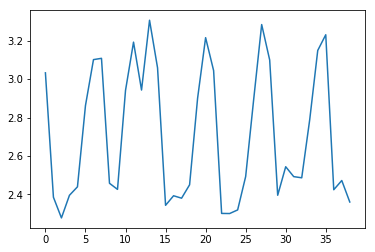

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.892053   
air_0164b9927d20bcc3_2017-04-23              1.481277   
air_0241aa3964b7f861_2017-04-23              2.434010   
air_0328696196e46f18_2017-04-23              2.183541   
air_034a3d5b40d5b1b1_2017-04-23              3.401917   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.632975  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.398558  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.404525  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.877686  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.021604

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')